In [699]:
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
import seaborn as sns 
plt.style.use('ggplot')
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, auc, f1_score, roc_curve, precision_score, recall_score

## Loading the Real-world dataset

In [700]:
df = pd.read_csv("...",
                 sep=',')
print(df.shape)

(12406, 94)


In [703]:
len(pd.unique(df['patient_id']))

92

In [704]:
len(df.columns)

94

0 - euthymic
2 - manic
1 - depressive

In [712]:
df['cgic'].value_counts()

cgic
-1    9660
 1    1486
 0     935
 2     174
 3     151
Name: count, dtype: int64

In [713]:
df['cgic'] = df['cgic'].apply(lambda x: 1 if x not in [-1, 0] else x)
df['cgic']=df['cgic'].replace(-1, np.nan)
df['cgic'].value_counts()

cgic
1.0    1811
0.0     935
Name: count, dtype: int64

## Chosing the Patient ID for Experiments

In [717]:
explain_1058 = df[df['patient_id'] == 1058]
explain_1058 = explain_1058.drop('patient_id', axis=1)
explain_1058 = explain_1058.drop('Unnamed: 0', axis=1)
explain_1058 = explain_1058.dropna()

In [718]:
explain_1058['cgi'].value_counts()

cgi
0.0    40
1.0    39
Name: count, dtype: int64

In [720]:
df_1, df_res = train_test_split(explain_1058, test_size=0.75, random_state=2025)
print(df_1.shape)
print(df_res.shape)

(19, 91)
(60, 91)


In [721]:
df_2, df_res = train_test_split(df_res, test_size=0.66, random_state=2025)
print(df_2.shape)
print(df_res.shape)

(20, 91)
(40, 91)


In [722]:
df_3, df_4 = train_test_split(df_res, test_size=0.5, random_state=2025)
print(df_3.shape)
print(df_4.shape)

(20, 91)
(20, 91)


In [723]:
print(df_1.shape)
print(df_2.shape)
print(df_3.shape)
print(df_4.shape)

(19, 91)
(20, 91)
(20, 91)
(20, 91)


In [724]:
print(df_1['cgi'].value_counts())
print(df_2['cgi'].value_counts())
print(df_3['cgi'].value_counts())
print(df_4['cgi'].value_counts())

cgi
0.0    13
1.0     6
Name: count, dtype: int64
cgi
0.0    10
1.0    10
Name: count, dtype: int64
cgi
1.0    11
0.0     9
Name: count, dtype: int64
cgi
1.0    12
0.0     8
Name: count, dtype: int64


In [725]:
df_1_train, df_1_test = train_test_split(df_1, test_size=0.55, random_state=2025)
df_2_train, df_2_test = train_test_split(df_2, test_size=0.6, random_state=2025)
df_3_train, df_3_test = train_test_split(df_3, test_size=0.6, random_state=2025)
df_4_train, df_4_test = train_test_split(df_4, test_size=0.6, random_state=2025)

In [726]:
print(df_1_train.shape)
print(df_1_test.shape)
print(df_2_train.shape)
print(df_2_test.shape)
print(df_3_train.shape)
print(df_3_test.shape)
print(df_4_train.shape)
print(df_4_test.shape)

(8, 91)
(11, 91)
(8, 91)
(12, 91)
(8, 91)
(12, 91)
(8, 91)
(12, 91)


## Stability Metric

In [727]:
def compute_stability_metric(feature_importance, model_performance=None, lambda_smoothing=0.7, epsilon=1e-6, standardize=False):
    """
    Computes a scale-aware Stability Metric (SM) for feature importance values over time.

    Parameters:
    - feature_importance (pd.DataFrame): Rows represent time points, columns represent features.
    - model_performance (pd.Series or None): Optional series containing model performance at each time point.
    - lambda_smoothing (float): Smoothing factor for EWMA (0 ≤ λ ≤ 1).
    - epsilon (float): Small constant to prevent division by zero.
    - standardize (bool): If True, standardizes feature importance values before computing stability.

    Returns:
    - pd.Series: Stability metric for each feature.
    """
    feature_importance = feature_importance.sort_index()

    # Standardize feature importance values if requested
    if standardize:
        feature_importance = (feature_importance - feature_importance.mean()) / feature_importance.std(ddof=0)

    # Compute EWMA manually
    S_t = feature_importance.copy()
    S_t.iloc[0] = feature_importance.iloc[0]

    for t in range(1, len(feature_importance)):
        S_t.iloc[t] = lambda_smoothing * S_t.iloc[t - 1] + (1 - lambda_smoothing) * feature_importance.iloc[t]

    # Compute normalized squared differences
    scaled_differences = ((feature_importance - S_t) ** 2) / (np.abs(feature_importance) + np.abs(S_t) + epsilon)

    if model_performance is not None:
        if isinstance(model_performance, np.ndarray):
            model_performance = pd.Series(model_performance, index=feature_importance.index)

        model_performance = model_performance.sort_index()

        # Compute weighted sum (excluding first time point)
        weighted_sum = (model_performance.iloc[1:].values @ scaled_differences.iloc[1:].values)
    else:
        # If no model_performance, take the mean of scaled differences
        weighted_sum = scaled_differences.iloc[1:].sum(axis=0)

    # Normalize by number of time points
    stability_metric = 1 - (weighted_sum / (len(feature_importance) - 1))

    return pd.Series(stability_metric, index=feature_importance.columns)

## Experiments for Real-world Dataset

In [753]:
explain_1058 = df[df['patient_id'] == 1058]
explain_1058 = explain_1058.drop('patient_id', axis=1)
explain_1058 = explain_1058.drop('Unnamed: 0', axis=1)
explain_1058 = explain_1058.dropna()

columns_to_keep = ['energy_mean', 'energy_std', 'pitch_mean', 'pitch_std', 'localjitter', 'localshimmer', 'rising_f0_slope_max', 'cgi']
columns_to_keep = [col for col in columns_to_keep if col in explain_1058.columns]
explain_1058 = explain_1058[columns_to_keep]

df_1, df_res = train_test_split(explain_1058, test_size=0.75, random_state=2025)
df_2, df_res = train_test_split(df_res, test_size=0.66, random_state=2025)
df_3, df_4 = train_test_split(df_res, test_size=0.5, random_state=2025)

df_1_train, df_1_test = train_test_split(df_1, test_size=0.55, random_state=2025)
df_2_train, df_2_test = train_test_split(df_2, test_size=0.6, random_state=2025)
df_3_train, df_3_test = train_test_split(df_3, test_size=0.6, random_state=2025)
df_4_train, df_4_test = train_test_split(df_4, test_size=0.6, random_state=2025)

### Step 1

In [754]:
# Train XGBoost model
model = XGBClassifier(random_state=2025, eval_metric="logloss", objective='binary:logistic')
model.fit(df_1_train.drop('cgi', axis=1), df_1_train['cgi'])

# Get predicted probabilities for ROC AUC
y_pred_proba = model.predict_proba(df_1_test.drop(['cgi'], axis=1))[:, 0]
roc_auc = roc_auc_score(df_1_test['cgi'], y_pred_proba)
roc_auc

0.5

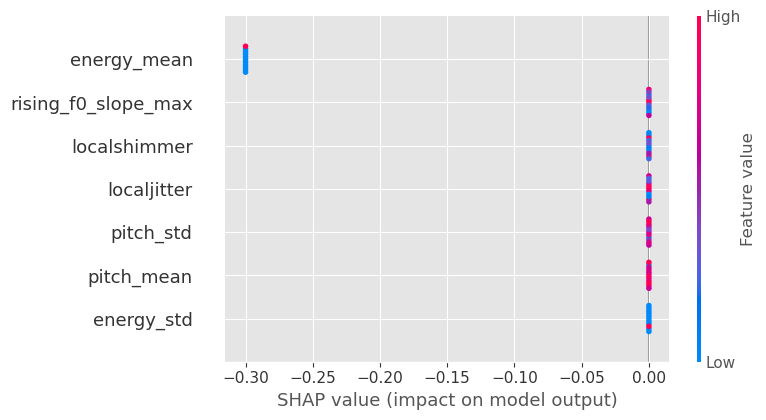

In [755]:
# Compute SHAP values
explainer = shap.Explainer(model, df_1_train.drop('cgi', axis=1))
shap_values = explainer(df_1_test.drop('cgi', axis=1))

shap.summary_plot(shap_values, df_1_test.drop('cgi', axis=1))

In [756]:
# Initialize an empty DataFrame with a time index and SHAP columns using feature names
feature_names = df_1_train.drop('cgi', axis=1).columns
num_features = len(feature_names)

# Initialize the results dataframe with proper column names
results_df_smol = pd.DataFrame(columns=["time_index", "roc_auc"] + [f"shap_{feature}" for feature in feature_names])

# Extract SHAP values directly 
shap_values_list = shap_values.values

# Flatten SHAP values 
shap_values_flat = shap_values_list.mean(axis=0)

# If the length of shap_values_flat matches num_features, continue
if len(shap_values_flat) != num_features:
    raise ValueError(f"Mismatch in SHAP values count: expected {num_features}, got {len(shap_values_flat)}")

# Get the next time index 
time_index = len(results_df_smol) + 1

# Store results in DataFrame
new_entry = pd.DataFrame([[time_index, roc_auc] + shap_values_flat.tolist()],
                         columns=results_df_smol.columns)

# Append new entry to results DataFrame
results_df_smol = pd.concat([results_df_smol, new_entry], ignore_index=True)

In [757]:
results_df_smol

time_index  roc_auc  shap_energy_mean  shap_energy_std  shap_pitch_mean  \
0          1      0.5              -0.3              0.0              0.0   

   shap_pitch_std  shap_localjitter  shap_localshimmer  \
0             0.0               0.0                0.0   

   shap_rising_f0_slope_max  
0                       0.0

In [758]:
# Initialize an empty DataFrame for feature importance
results_df_smol_FI = pd.DataFrame(columns=["time_index", "roc_auc"] + [f"FI_{feature}" for feature in feature_names])

# Get feature importance scores from the trained XGBoost model
feature_importance_values = model.feature_importances_

# Ensure the number of feature importance scores matches the number of features
if len(feature_importance_values) != num_features:
    raise ValueError(f"Mismatch in feature importance count: expected {num_features}, got {len(feature_importance_values)}")

# Store results in DataFrame
new_entry_FI = pd.DataFrame([[time_index, roc_auc] + feature_importance_values.tolist()],
                            columns=results_df_smol_FI.columns)

# Append new entry to results DataFrame
results_df_smol_FI = pd.concat([results_df_smol_FI, new_entry_FI], ignore_index=True)

In [759]:
results_df_smol_FI

time_index  roc_auc  FI_energy_mean  FI_energy_std  FI_pitch_mean  \
0          1      0.5             1.0            0.0            0.0   

   FI_pitch_std  FI_localjitter  FI_localshimmer  FI_rising_f0_slope_max  
0           0.0             0.0              0.0                     0.0

### Step 2

In [760]:
df_2_train = pd.concat([df_2_train, df_1_train, df_1_test], axis=0, ignore_index=True)
print(df_2_train.shape)

(27, 8)


In [761]:
# Train XGBoost model
model = XGBClassifier(random_state=2025, eval_metric="logloss", objective='binary:logistic')
model.fit(df_2_train.drop('cgi', axis=1), df_2_train['cgi'])

# Get predicted probabilities for ROC AUC
y_pred_proba = model.predict_proba(df_2_test.drop(['cgi'], axis=1))[:, 1]
roc_auc = roc_auc_score(df_2_test['cgi'], y_pred_proba)
roc_auc

0.8571428571428571

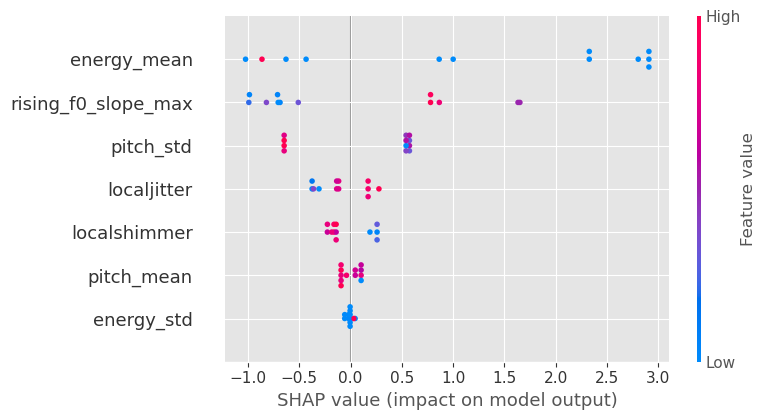

In [762]:
# Compute SHAP values
explainer = shap.Explainer(model, df_2_train.drop('cgi', axis=1))
shap_values = explainer(df_2_test.drop('cgi', axis=1))

shap.summary_plot(shap_values, df_2_test.drop('cgi', axis=1))

In [763]:
# Extract SHAP values directly (not the mean)
shap_values_list = shap_values.values

# Flatten SHAP values 
shap_values_flat = shap_values_list.mean(axis=0)

# If the length of shap_values_flat matches num_features, continue
if len(shap_values_flat) != num_features:
    raise ValueError(f"Mismatch in SHAP values count: expected {num_features}, got {len(shap_values_flat)}")

# Get the next time index (increment from last index)
time_index = len(results_df_smol) + 1

# Store results in DataFrame
new_entry = pd.DataFrame([[time_index, roc_auc] + shap_values_flat.tolist()],
                         columns=results_df_smol.columns)

# Append new entry to results DataFrame
results_df_smol = pd.concat([results_df_smol, new_entry], ignore_index=True)

In [764]:
results_df_smol

time_index   roc_auc  shap_energy_mean  shap_energy_std  shap_pitch_mean  \
0          1  0.500000         -0.300000         0.000000         0.000000   
1          2  0.857143          1.257461        -0.009527        -0.001018   

   shap_pitch_std  shap_localjitter  shap_localshimmer  \
0        0.000000          0.000000           0.000000   
1        0.154927         -0.095378          -0.035768   

   shap_rising_f0_slope_max  
0                  0.000000  
1                  0.023571

In [765]:
# Get feature importance scores from the trained XGBoost model
feature_importance_values = model.feature_importances_

# Ensure the number of feature importance scores matches the number of features
if len(feature_importance_values) != num_features:
    raise ValueError(f"Mismatch in feature importance count: expected {num_features}, got {len(feature_importance_values)}")

# Store results in DataFrame
new_entry_FI = pd.DataFrame([[time_index, roc_auc] + feature_importance_values.tolist()],
                            columns=results_df_smol_FI.columns)

# Append new entry to results DataFrame
results_df_smol_FI = pd.concat([results_df_smol_FI, new_entry_FI], ignore_index=True)

In [766]:
results_df_smol_FI

time_index   roc_auc  FI_energy_mean  FI_energy_std  FI_pitch_mean  \
0          1  0.500000        1.000000       0.000000       0.000000   
1          2  0.857143        0.281925       0.047743       0.059877   

   FI_pitch_std  FI_localjitter  FI_localshimmer  FI_rising_f0_slope_max  
0      0.000000        0.000000         0.000000                0.000000  
1      0.154496        0.051923         0.225618                0.178419

### Step 3

In [767]:
df_3_train = pd.concat([df_3_train, df_2_train, df_2_test], axis=0, ignore_index=True)
print(df_3_train.shape)

(47, 8)


In [768]:
# Train XGBoost model
model = XGBClassifier(random_state=2025, eval_metric="logloss", objective='binary:logistic')
model.fit(df_3_train.drop('cgi', axis=1), df_3_train['cgi'])

# Get predicted probabilities for ROC AUC
y_pred_proba = model.predict_proba(df_3_test.drop(['cgi'], axis=1))[:, 1]
roc_auc = roc_auc_score(df_3_test['cgi'], y_pred_proba)
roc_auc

0.8571428571428572

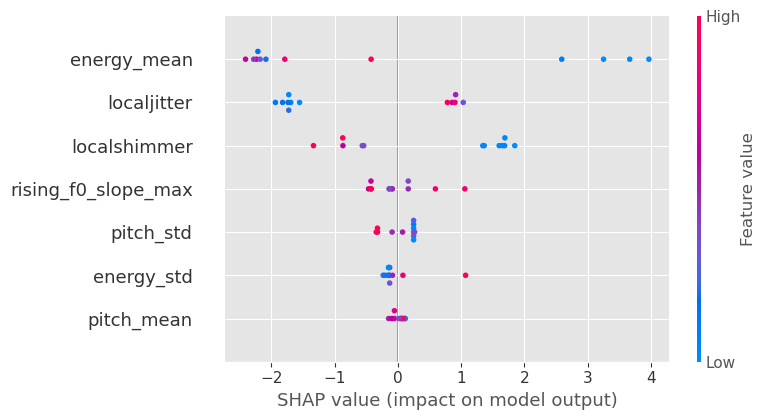

In [769]:
# Compute SHAP values
explainer = shap.Explainer(model, df_3_train.drop('cgi', axis=1))
shap_values = explainer(df_3_test.drop('cgi', axis=1))

shap.summary_plot(shap_values, df_3_test.drop('cgi', axis=1))

In [770]:
# Extract SHAP values directly 
shap_values_list = shap_values.values

# Flatten SHAP values 
shap_values_flat = shap_values_list.mean(axis=0)

# If the length of shap_values_flat matches num_features, continue
if len(shap_values_flat) != num_features:
    raise ValueError(f"Mismatch in SHAP values count: expected {num_features}, got {len(shap_values_flat)}")

# Get the next time index (increment from last index)
time_index = len(results_df_smol) + 1

# Store results in DataFrame
new_entry = pd.DataFrame([[time_index, roc_auc] + shap_values_flat.tolist()],
                         columns=results_df_smol.columns)

# Append new entry to results DataFrame
results_df_smol = pd.concat([results_df_smol, new_entry], ignore_index=True)

In [771]:
results_df_smol

time_index   roc_auc  shap_energy_mean  shap_energy_std  shap_pitch_mean  \
0          1  0.500000         -0.300000         0.000000         0.000000   
1          2  0.857143          1.257461        -0.009527        -0.001018   
2          3  0.857143         -0.178554        -0.030402         0.019663   

   shap_pitch_std  shap_localjitter  shap_localshimmer  \
0        0.000000          0.000000           0.000000   
1        0.154927         -0.095378          -0.035768   
2        0.062175         -0.642761           0.583717   

   shap_rising_f0_slope_max  
0                  0.000000  
1                  0.023571  
2                 -0.018352

In [772]:
# Get feature importance scores from the trained XGBoost model
feature_importance_values = model.feature_importances_

# Ensure the number of feature importance scores matches the number of features
if len(feature_importance_values) != num_features:
    raise ValueError(f"Mismatch in feature importance count: expected {num_features}, got {len(feature_importance_values)}")

# Store results in DataFrame
new_entry_FI = pd.DataFrame([[time_index, roc_auc] + feature_importance_values.tolist()],
                            columns=results_df_smol_FI.columns)

# Append new entry to results DataFrame
results_df_smol_FI = pd.concat([results_df_smol_FI, new_entry_FI], ignore_index=True)

In [773]:
results_df_smol_FI

time_index   roc_auc  FI_energy_mean  FI_energy_std  FI_pitch_mean  \
0          1  0.500000        1.000000       0.000000       0.000000   
1          2  0.857143        0.281925       0.047743       0.059877   
2          3  0.857143        0.628467       0.139473       0.034570   

   FI_pitch_std  FI_localjitter  FI_localshimmer  FI_rising_f0_slope_max  
0      0.000000        0.000000         0.000000                0.000000  
1      0.154496        0.051923         0.225618                0.178419  
2      0.018888        0.033088         0.057214                0.088299

### Step 4

In [774]:
df_4_train = pd.concat([df_4_train, df_3_train, df_3_test], axis=0, ignore_index=True)
print(df_4_train.shape)

(67, 8)


In [775]:
# Train XGBoost model
model = XGBClassifier(random_state=2025, eval_metric="logloss", objective='binary:logistic')
model.fit(df_4_train.drop('cgi', axis=1), df_4_train['cgi'])

# Get predicted probabilities for ROC AUC
y_pred_proba = model.predict_proba(df_4_test.drop(['cgi'], axis=1))[:, 1]
roc_auc = roc_auc_score(df_4_test['cgi'], y_pred_proba)
roc_auc

0.75

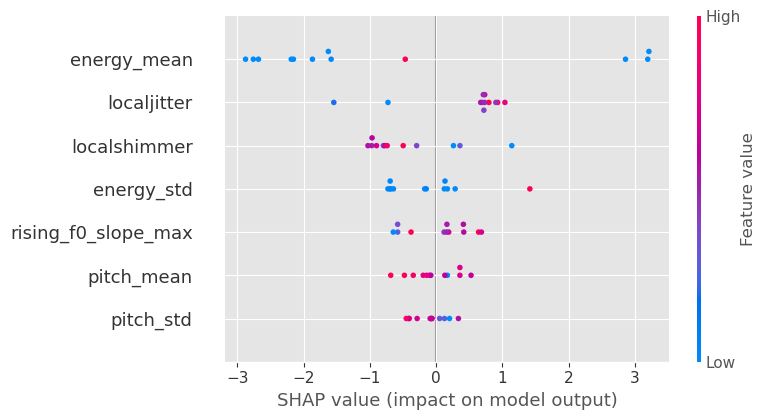

In [776]:
# Compute SHAP values
explainer = shap.Explainer(model, df_4_train.drop('cgi', axis=1))
shap_values = explainer(df_4_test.drop('cgi', axis=1))

shap.summary_plot(shap_values, df_4_test.drop('cgi', axis=1))

In [777]:
# Extract SHAP values directly 
shap_values_list = shap_values.values

# Flatten SHAP values
shap_values_flat = shap_values_list.mean(axis=0)

# If the length of shap_values_flat matches num_features, continue
if len(shap_values_flat) != num_features:
    raise ValueError(f"Mismatch in SHAP values count: expected {num_features}, got {len(shap_values_flat)}")

# Get the next time index (increment from last index)
time_index = len(results_df_smol) + 1

# Store results in DataFrame
new_entry = pd.DataFrame([[time_index, roc_auc] + shap_values_flat.tolist()],
                         columns=results_df_smol.columns)

# Append new entry to results DataFrame
results_df_smol = pd.concat([results_df_smol, new_entry], ignore_index=True)

In [778]:
results_df_smol

time_index   roc_auc  shap_energy_mean  shap_energy_std  shap_pitch_mean  \
0          1  0.500000         -0.300000         0.000000         0.000000   
1          2  0.857143          1.257461        -0.009527        -0.001018   
2          3  0.857143         -0.178554        -0.030402         0.019663   
3          4  0.750000         -0.745361        -0.137283        -0.040488   

   shap_pitch_std  shap_localjitter  shap_localshimmer  \
0        0.000000          0.000000           0.000000   
1        0.154927         -0.095378          -0.035768   
2        0.062175         -0.642761           0.583717   
3       -0.095820          0.471265          -0.434754   

   shap_rising_f0_slope_max  
0                  0.000000  
1                  0.023571  
2                 -0.018352  
3                  0.049046

In [779]:
# Get feature importance scores from the trained XGBoost model
feature_importance_values = model.feature_importances_

# Ensure the number of feature importance scores matches the number of features
if len(feature_importance_values) != num_features:
    raise ValueError(f"Mismatch in feature importance count: expected {num_features}, got {len(feature_importance_values)}")

# Store results in DataFrame
new_entry_FI = pd.DataFrame([[time_index, roc_auc] + feature_importance_values.tolist()],
                            columns=results_df_smol_FI.columns)

# Append new entry to results DataFrame
results_df_smol_FI = pd.concat([results_df_smol_FI, new_entry_FI], ignore_index=True)

In [780]:
results_df_smol_FI

time_index   roc_auc  FI_energy_mean  FI_energy_std  FI_pitch_mean  \
0          1  0.500000        1.000000       0.000000       0.000000   
1          2  0.857143        0.281925       0.047743       0.059877   
2          3  0.857143        0.628467       0.139473       0.034570   
3          4  0.750000        0.527847       0.113795       0.085397   

   FI_pitch_std  FI_localjitter  FI_localshimmer  FI_rising_f0_slope_max  
0      0.000000        0.000000         0.000000                0.000000  
1      0.154496        0.051923         0.225618                0.178419  
2      0.018888        0.033088         0.057214                0.088299  
3      0.056531        0.061489         0.067914                0.087028

### Stability Metric Calculation

In [782]:
# 1. Extract SHAP values (all columns except 'time_index' and 'roc_auc')
shap_values_df_smol = results_df_smol.drop(columns=['time_index', 'roc_auc'])

# 2. Extract ROC AUC values (model performance) as a Pandas Series
model_performance = results_df_smol['roc_auc']

# 3. Call compute_stability_metric function
stability_metric = compute_stability_metric(shap_values_df_smol, model_performance, standardize=False)

# 4. Display the stability metric for each feature
print(stability_metric)

shap_energy_mean            0.605789
shap_energy_std             0.985948
shap_pitch_mean             0.992321
shap_pitch_std              0.957285
shap_localjitter            0.808292
shap_localshimmer           0.831058
shap_rising_f0_slope_max    0.987920
dtype: float64


In [783]:
# 1. Extract SHAP values (all columns except 'time_index' and 'roc_auc')
FI_df_smol = results_df_smol_FI.drop(columns=['time_index', 'roc_auc'])

# 3. Call compute_stability_metric function
compute_stability_metric(FI_df_smol, results_df_smol_FI['roc_auc'], standardize=False)

FI_energy_mean            0.925328
FI_energy_std             0.980849
FI_pitch_mean             0.989121
FI_pitch_std              0.981095
FI_localjitter            0.991470
FI_localshimmer           0.975566
FI_rising_f0_slope_max    0.979261
dtype: float64

In [784]:
results_df_smol

time_index   roc_auc  shap_energy_mean  shap_energy_std  shap_pitch_mean  \
0          1  0.500000         -0.300000         0.000000         0.000000   
1          2  0.857143          1.257461        -0.009527        -0.001018   
2          3  0.857143         -0.178554        -0.030402         0.019663   
3          4  0.750000         -0.745361        -0.137283        -0.040488   

   shap_pitch_std  shap_localjitter  shap_localshimmer  \
0        0.000000          0.000000           0.000000   
1        0.154927         -0.095378          -0.035768   
2        0.062175         -0.642761           0.583717   
3       -0.095820          0.471265          -0.434754   

   shap_rising_f0_slope_max  
0                  0.000000  
1                  0.023571  
2                 -0.018352  
3                  0.049046

In [785]:
results_df_smol_FI

time_index   roc_auc  FI_energy_mean  FI_energy_std  FI_pitch_mean  \
0          1  0.500000        1.000000       0.000000       0.000000   
1          2  0.857143        0.281925       0.047743       0.059877   
2          3  0.857143        0.628467       0.139473       0.034570   
3          4  0.750000        0.527847       0.113795       0.085397   

   FI_pitch_std  FI_localjitter  FI_localshimmer  FI_rising_f0_slope_max  
0      0.000000        0.000000         0.000000                0.000000  
1      0.154496        0.051923         0.225618                0.178419  
2      0.018888        0.033088         0.057214                0.088299  
3      0.056531        0.061489         0.067914                0.087028

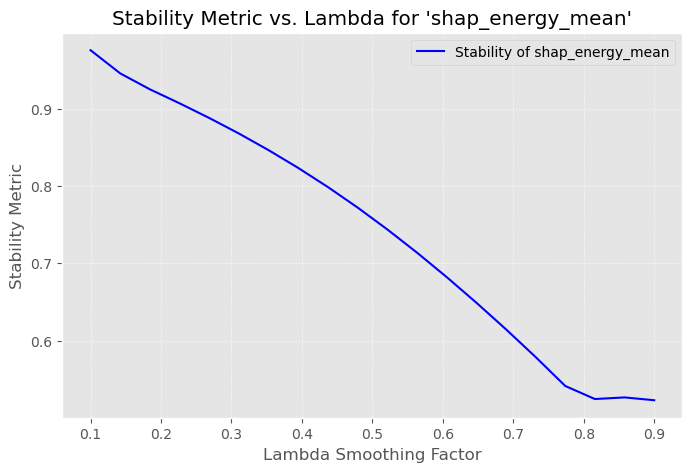

In [786]:
# Define the feature to analyze
feature_name = "shap_energy_mean"

# Define lambda values to test (from 0.1 to 0.9)
lambda_values = np.linspace(0.1, 0.9, 20)

# Compute stability metric for each lambda value
stability_scores = [
    compute_stability_metric(shap_values_df_smol, model_performance, lambda_smoothing=l)[feature_name]
    for l in lambda_values
]

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(lambda_values, stability_scores, linestyle='-', color='b', label=f"Stability of {feature_name}")
plt.xlabel("Lambda Smoothing Factor")
plt.ylabel("Stability Metric")
plt.title(f"Stability Metric vs. Lambda for '{feature_name}'")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
plt.show()

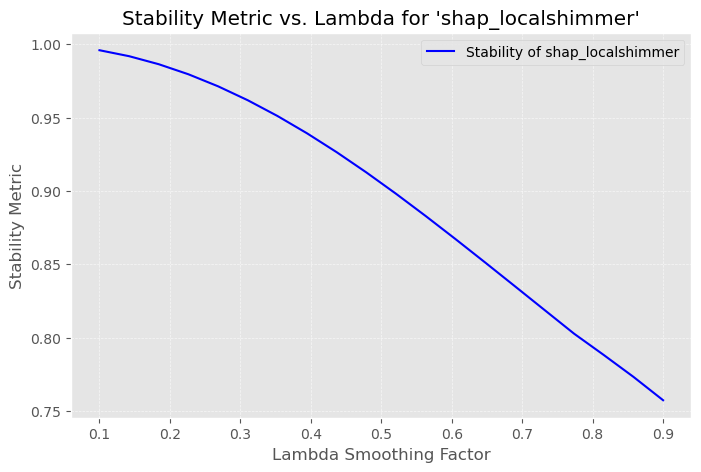

In [787]:
# Define the feature to analyze
feature_name = "shap_localshimmer"

# Define lambda values to test (from 0.1 to 0.9)
lambda_values = np.linspace(0.1, 0.9, 20)

# Compute stability metric for each lambda value
stability_scores = [
    compute_stability_metric(shap_values_df_smol, model_performance, lambda_smoothing=l)[feature_name]
    for l in lambda_values
]

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(lambda_values, stability_scores, linestyle='-', color='b', label=f"Stability of {feature_name}")
plt.xlabel("Lambda Smoothing Factor")
plt.ylabel("Stability Metric")
plt.title(f"Stability Metric vs. Lambda for '{feature_name}'")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
plt.show()

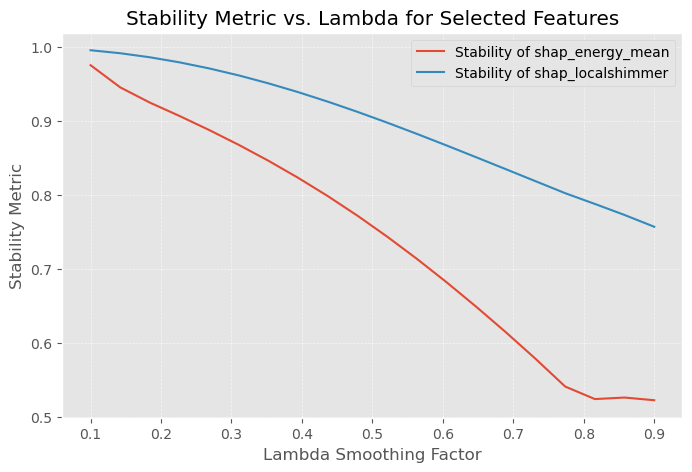

In [788]:
# Define the features to analyze
feature_names = ["shap_energy_mean", "shap_localshimmer"] 

# Define lambda values to test (from 0.1 to 0.9)
lambda_values = np.linspace(0.1, 0.9, 20)

# Compute stability metric for each lambda value and each feature
stability_scores = {feature: [] for feature in feature_names}

for l in lambda_values:
    stability_metric = compute_stability_metric(shap_values_df_smol, model_performance, lambda_smoothing=l)
    for feature in feature_names:
        stability_scores[feature].append(stability_metric[feature])

# Plot results
plt.figure(figsize=(8, 5))

for feature in feature_names:
    plt.plot(lambda_values, stability_scores[feature], linestyle='-', label=f"Stability of {feature}")

# Customize plot appearance
plt.xlabel("Lambda Smoothing Factor")
plt.ylabel("Stability Metric")
plt.title("Stability Metric vs. Lambda for Selected Features")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
plt.show()

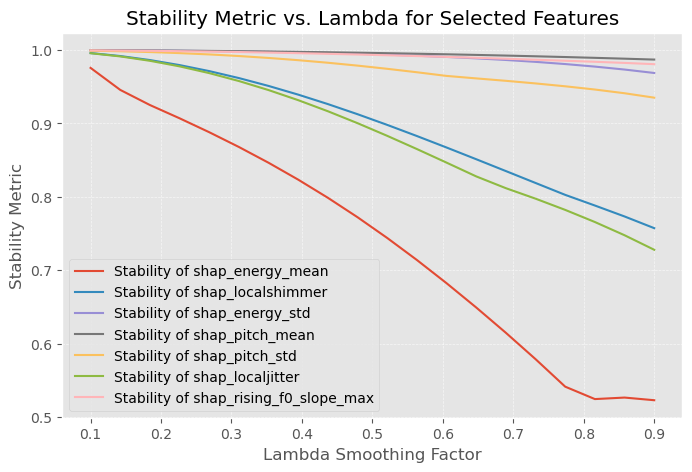

In [789]:
# Define the features to analyze
feature_names = ["shap_energy_mean", "shap_localshimmer", "shap_energy_std", "shap_pitch_mean", "shap_pitch_std", "shap_localjitter", "shap_rising_f0_slope_max"] 

# Define lambda values to test (from 0.1 to 0.9)
lambda_values = np.linspace(0.1, 0.9, 20)

# Compute stability metric for each lambda value and each feature
stability_scores = {feature: [] for feature in feature_names}

for l in lambda_values:
    stability_metric = compute_stability_metric(shap_values_df_smol, model_performance, lambda_smoothing=l)
    for feature in feature_names:
        stability_scores[feature].append(stability_metric[feature])

# Plot results
plt.figure(figsize=(8, 5))

for feature in feature_names:
    plt.plot(lambda_values, stability_scores[feature], linestyle='-', label=f"Stability of {feature}")

# Customize plot appearance
plt.xlabel("Lambda Smoothing Factor")
plt.ylabel("Stability Metric")
plt.title("Stability Metric vs. Lambda for Selected Features")
plt.legend(loc="lower left")
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
plt.show()

In [790]:
def plot_shap_values_over_time(shap_values_df):
    """
    Plots Shapley values over time for all features.

    Parameters:
    - shap_values_df (pd.DataFrame): DataFrame with time as index and Shapley values for each feature as columns.
    """
    plt.figure(figsize=(12, 6))

    for feature in shap_values_df.columns:
        plt.plot(shap_values_df.index, shap_values_df[feature], label=feature, alpha=0.7)

    plt.xlabel("Time")
    plt.ylabel("Shapley Value")
    plt.title("Shapley Values Over Time")
    plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1))  # Move legend outside
    plt.grid(True)
    plt.show()

In [791]:
def plot_FI_over_time(shap_values_df):
    """
    Plots feature importance over time for all features.

    Parameters:
    - shap_values_df (pd.DataFrame): DataFrame with time as index and Shapley values for each feature as columns.
    """
    plt.figure(figsize=(12, 6))

    for feature in shap_values_df.columns:
        plt.plot(shap_values_df.index, shap_values_df[feature], label=feature, alpha=0.7)

    plt.xlabel("Time")
    plt.ylabel("Feature Importance")
    plt.title("Feature Importance Over Time")
    plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1))  # Move legend outside
    plt.grid(True)
    plt.show()

In [792]:
def plot_shap_values_scatter(shap_values_df):
    """
    Plots Shapley values over time for all features using scatter points.

    Parameters:
    - shap_values_df (pd.DataFrame): DataFrame with time as index and Shapley values for each feature as columns.
    """
    plt.figure(figsize=(12, 6))

    for feature in shap_values_df.columns:
        plt.scatter(shap_values_df.index, shap_values_df[feature], label=feature, alpha=0.7, s=20)

    plt.xlabel("Time")
    plt.ylabel("Shapley Value")
    plt.title("Shapley Values Over Time (Scatter Plot)")
    plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1))
    plt.grid(True)
    plt.show()

In [793]:
def plot_FI_scatter(shap_values_df):
    """
    Plots Feature Importance over time for all features using scatter points.

    Parameters:
    - shap_values_df (pd.DataFrame): DataFrame with time as index and Shapley values for each feature as columns.
    """
    plt.figure(figsize=(12, 6))

    for feature in shap_values_df.columns:
        plt.scatter(shap_values_df.index, shap_values_df[feature], label=feature, alpha=0.7, s=20)

    plt.xlabel("Time")
    plt.ylabel("Feature Importance")
    plt.title("Feature Importance Over Time (Scatter Plot)")
    plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1))
    plt.grid(True)
    plt.show()

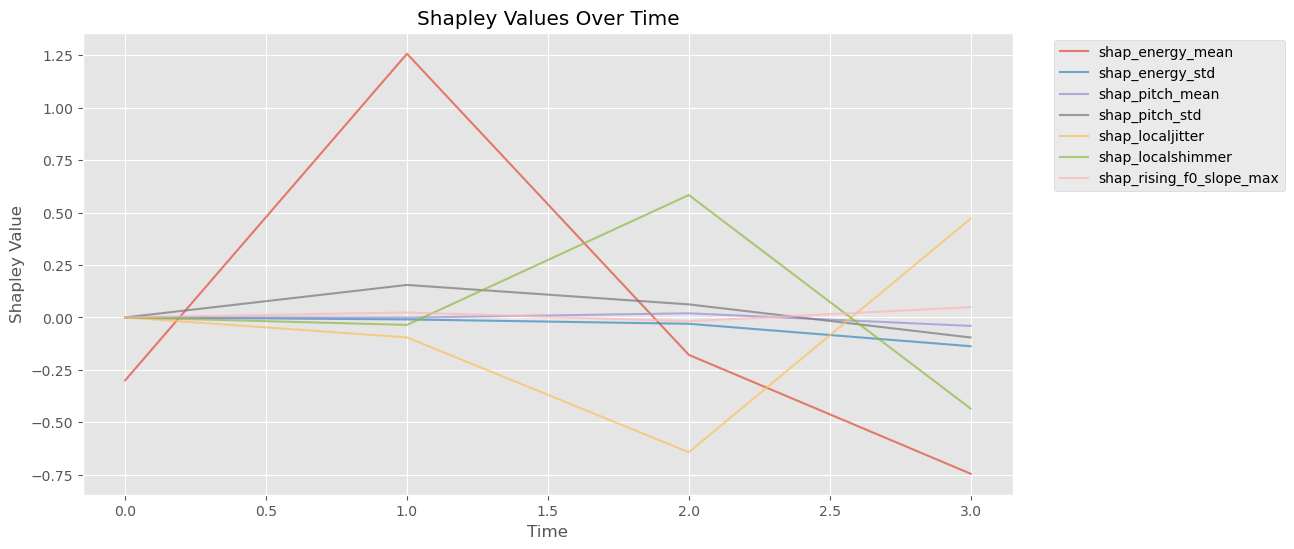

In [794]:
# Call the function to plot
plot_shap_values_over_time(shap_values_df_smol)

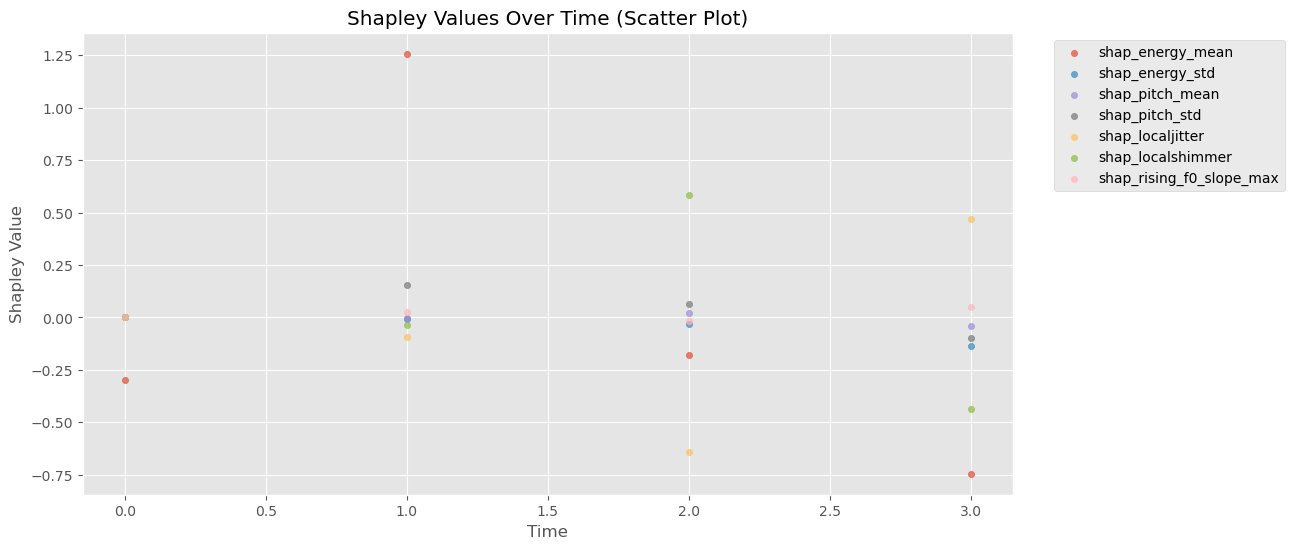

In [795]:
plot_shap_values_scatter(shap_values_df_smol)

## Simulations

### 1 Year

#### Data Simulation

Euthymic: 155
Depressive: 48
Manic: 162


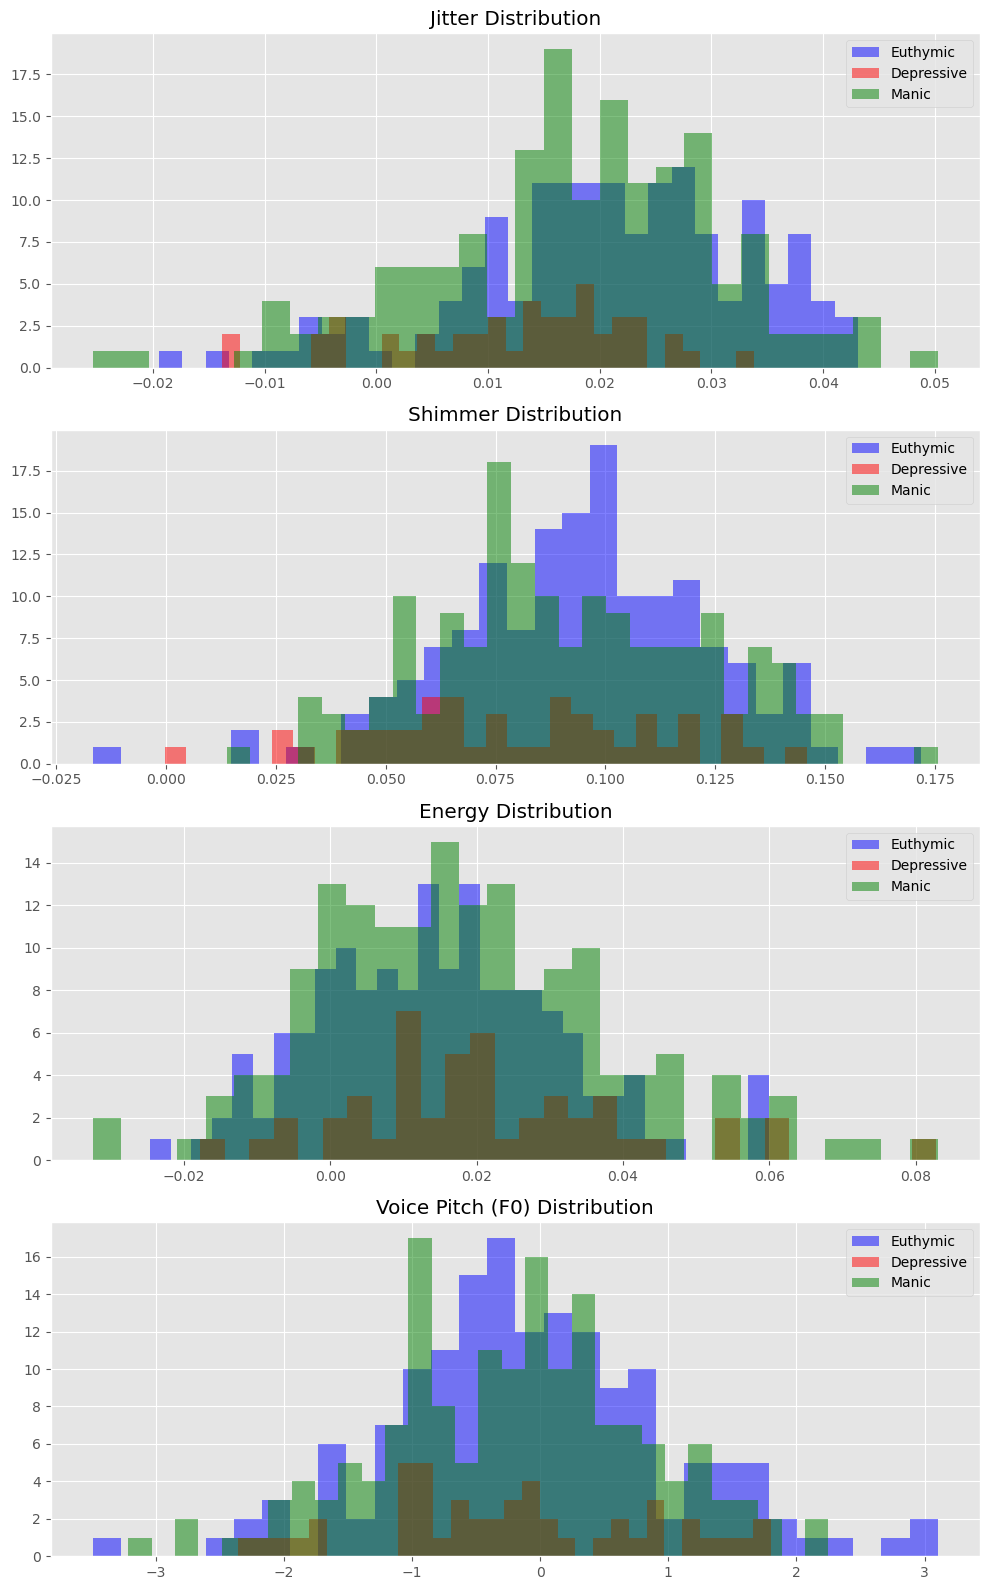

In [821]:
# Parameters for each voice state
states = ['Euthymic', 'Depressive', 'Manic']

# Jitter Distribution
jitter_means = [0.022, 0.023+0.01, 0.021-0.01]
jitter_stds = [0.007, 0.008, 0.012]

# Shimmer Distribution 
shimmer_means = [0.096, 0.099+0.01, 0.086-0.01]
shimmer_stds = [0.027, 0.029, 0.031]

# Energy Distribution 
energy_means = [0.014, 0.007-0.003, 0.017+0.01]
energy_stds = [0.014, 0.012, 0.022]

# Voice Pitch (F0) Distribution
f0_means = [-0.139, -0.131+0.03, -0.170-0.03]  
f0_stds = [1.023, 1.088, 0.982]

# Define states
HEALTHY = 0
DEPRESSED = 1
MANIC = 2

# Seasonal influence function
def seasonality(day_of_year):
    if 1 <= day_of_year <= 90 or 335 <= day_of_year <= 365:
        return {'depression': 1.1, 'mania': 0.9}  # Winter: higher depression
    elif 91 <= day_of_year <= 150:
        return {'depression': 0.9, 'mania': 1.1}  # Spring: higher mania
    else:
        return {'depression': 1.0, 'mania': 1.0}  # Neutral periods

# Logistic function for transition probability (adjusting k and x0)
def logistic(x, k=2, x0=30):  
    return 1 / (1 + np.exp(-k * (x - x0)))

# Generate a year of mood transitions with voice features
def generate_mood_series(days=365):
    mood_states = np.zeros(days, dtype=int)
    voice_features = {'jitter': [], 'shimmer': [], 'energy': [], 'f0': []}
    mood_states[0] = np.random.choice([HEALTHY, DEPRESSED, MANIC])
    days_in_state = 0

    for day in range(1, days):  
        season = seasonality(day)
        current_state = mood_states[day - 1]
        
        # Generate voice features for the current state
        if current_state == HEALTHY:
            jitter = np.random.normal(jitter_means[0], jitter_stds[0])
            shimmer = np.random.normal(shimmer_means[0], shimmer_stds[0])
            energy = np.random.normal(energy_means[0], energy_stds[0])
            f0 = np.random.normal(f0_means[0], f0_stds[0])
        elif current_state == DEPRESSED:
            jitter = np.random.normal(jitter_means[1], jitter_stds[1])
            shimmer = np.random.normal(shimmer_means[1], shimmer_stds[1])
            energy = np.random.normal(energy_means[1], energy_stds[1])
            f0 = np.random.normal(f0_means[1], f0_stds[1])
        elif current_state == MANIC:
            jitter = np.random.normal(jitter_means[2], jitter_stds[2])
            shimmer = np.random.normal(shimmer_means[2], shimmer_stds[2])
            energy = np.random.normal(energy_means[2], energy_stds[2])
            f0 = np.random.normal(f0_means[2], f0_stds[2])

        # Add voice features for the day
        voice_features['jitter'].append(jitter)
        voice_features['shimmer'].append(shimmer)
        voice_features['energy'].append(energy)
        voice_features['f0'].append(f0)

        # Base transition probabilities
        if current_state == HEALTHY:
            p_depressed = 0.05 * season['depression'] * logistic(days_in_state, 2, 30)  
            p_manic = 0.05 * season['mania'] * logistic(days_in_state, 2, 30)        
            p_healthy = 1 - (p_depressed + p_manic)
            probs = [p_healthy, p_depressed, p_manic]
        elif current_state == DEPRESSED:
            p_healthy = 0.05 * logistic(days_in_state, 2, 30)  
            p_depressed = 1 - p_healthy
            probs = [p_healthy, p_depressed, 0]
        elif current_state == MANIC:
            p_healthy = 0.05 * logistic(days_in_state, 2, 30)  
            p_manic = 1 - p_healthy
            probs = [p_healthy, 0, p_manic]
        
        new_state = np.random.choice([HEALTHY, DEPRESSED, MANIC], p=probs)
        mood_states[day] = new_state
        
        days_in_state = 0 if new_state != current_state else days_in_state + 1

    # Add voice features for the 365th day 
    current_state = mood_states[days - 1] 
    if current_state == HEALTHY:
        jitter = np.random.normal(jitter_means[0], jitter_stds[0])
        shimmer = np.random.normal(shimmer_means[0], shimmer_stds[0])
        energy = np.random.normal(energy_means[0], energy_stds[0])
        f0 = np.random.normal(f0_means[0], f0_stds[0])
    elif current_state == DEPRESSED:
        jitter = np.random.normal(jitter_means[1], jitter_stds[1])
        shimmer = np.random.normal(shimmer_means[1], shimmer_stds[1])
        energy = np.random.normal(energy_means[1], energy_stds[1])
        f0 = np.random.normal(f0_means[1], f0_stds[1])
    elif current_state == MANIC:
        jitter = np.random.normal(jitter_means[2], jitter_stds[2])
        shimmer = np.random.normal(shimmer_means[2], shimmer_stds[2])
        energy = np.random.normal(energy_means[2], energy_stds[2])
        f0 = np.random.normal(f0_means[2], f0_stds[2])

    # Add the voice features for the last day (365th day)
    voice_features['jitter'].append(jitter)
    voice_features['shimmer'].append(shimmer)
    voice_features['energy'].append(energy)
    voice_features['f0'].append(f0)

    # Count observations in each state
    state_counts = np.bincount(mood_states)
    print(f"Euthymic: {state_counts[HEALTHY]}")
    print(f"Depressive: {state_counts[DEPRESSED]}")
    print(f"Manic: {state_counts[MANIC]}")

    return mood_states, voice_features, state_counts

# Simulate a year of mood changes with voice features
mood_series, voice_features, state_counts = generate_mood_series()

fig, axs = plt.subplots(4, 1, figsize=(10, 16))

# Jitter plot
axs[0].hist(voice_features['jitter'][:state_counts[HEALTHY]], bins=30, alpha=0.5, label='Euthymic', color='blue')
axs[0].hist(voice_features['jitter'][state_counts[HEALTHY]:state_counts[HEALTHY] + state_counts[DEPRESSED]], bins=30, alpha=0.5, label='Depressive', color='red')
axs[0].hist(voice_features['jitter'][-state_counts[MANIC]:], bins=30, alpha=0.5, label='Manic', color='green')
axs[0].set_title('Jitter Distribution')
axs[0].legend()

# Shimmer plot
axs[1].hist(voice_features['shimmer'][:state_counts[HEALTHY]], bins=30, alpha=0.5, label='Euthymic', color='blue')
axs[1].hist(voice_features['shimmer'][state_counts[HEALTHY]:state_counts[HEALTHY] + state_counts[DEPRESSED]], bins=30, alpha=0.5, label='Depressive', color='red')
axs[1].hist(voice_features['shimmer'][-state_counts[MANIC]:], bins=30, alpha=0.5, label='Manic', color='green')
axs[1].set_title('Shimmer Distribution')
axs[1].legend()

# Energy plot
axs[2].hist(voice_features['energy'][:state_counts[HEALTHY]], bins=30, alpha=0.5, label='Euthymic', color='blue')
axs[2].hist(voice_features['energy'][state_counts[HEALTHY]:state_counts[HEALTHY] + state_counts[DEPRESSED]], bins=30, alpha=0.5, label='Depressive', color='red')
axs[2].hist(voice_features['energy'][-state_counts[MANIC]:], bins=30, alpha=0.5, label='Manic', color='green')
axs[2].set_title('Energy Distribution')
axs[2].legend()

# F0 (Voice Pitch) plot
axs[3].hist(voice_features['f0'][:state_counts[HEALTHY]], bins=30, alpha=0.5, label='Euthymic', color='blue')
axs[3].hist(voice_features['f0'][state_counts[HEALTHY]:state_counts[HEALTHY] + state_counts[DEPRESSED]], bins=30, alpha=0.5, label='Depressive', color='red')
axs[3].hist(voice_features['f0'][-state_counts[MANIC]:], bins=30, alpha=0.5, label='Manic', color='green')
axs[3].set_title('Voice Pitch (F0) Distribution')
axs[3].legend()

plt.tight_layout()
plt.show()

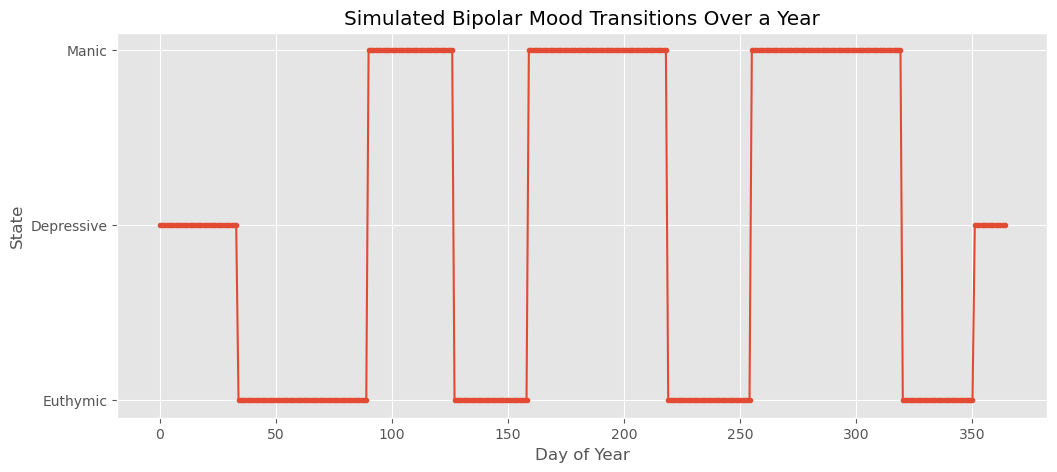

In [822]:
# Plot the results
plt.figure(figsize=(12, 5))
plt.plot(mood_series, marker='o', linestyle='-', markersize=3)
plt.yticks([HEALTHY, DEPRESSED, MANIC], ['Euthymic', 'Depressive', 'Manic'])
plt.xlabel("Day of Year")
plt.ylabel("State")
plt.title("Simulated Bipolar Mood Transitions Over a Year")
plt.show()

In [823]:
data = {
    'Day': np.arange(1, 366),
    'State': [states[state] for state in mood_series],
    'Jitter': voice_features['jitter'],
    'Shimmer': voice_features['shimmer'],
    'Energy': voice_features['energy'],
    'F0': voice_features['f0']
}

sim_df = pd.DataFrame(data)

sim_df.head(20)

Day       State    Jitter   Shimmer    Energy        F0
0     1  Depressive  0.036644  0.074465 -0.013076  0.431016
1     2  Depressive  0.031272  0.098566  0.001058 -1.021955
2     3  Depressive  0.035009  0.088455  0.020742 -0.633223
3     4  Depressive  0.026748  0.105663 -0.000994  1.834449
4     5  Depressive  0.037770  0.138326  0.010939  0.401637
5     6  Depressive  0.030023  0.078309  0.012411  2.687731
6     7  Depressive  0.039845  0.146513  0.001843 -0.639452
7     8  Depressive  0.032935  0.073133  0.001856 -2.308438
8     9  Depressive  0.031872  0.117158 -0.008377  3.103098
9    10  Depressive  0.021526  0.088506  0.001103 -2.510729
10   11  Depressive  0.038778  0.107067 -0.000578  0.820969
11   12  Depressive  0.042605  0.140910 -0.003572 -1.244470
12   13  Depressive  0.027955  0.146218  0.007795 -0.979979
13   14  Depressive  0.022359  0.132898 -0.002046 -0.637532
14   15  Depressive  0.035684  0.116809 -0.013056  1.713307
15   16  Depressive  0.043120  0.111218  0.008215  0.264307
16   17  Depressive  0.033403  0.108852 -0.007481 -0.195572
17   18  Depressive  0.041323  0.105111  0.009079 -0.666474
18   19  Depressive  0.032804  0.171829 -0.015836 -0.282365
19   20  Depressive  0.040571  0.075769 -0.008803 -0.232225

In [824]:
# Jitter Distribution
jitter_means_base = [0.022, 0.023, 0.021]
jitter_stds_base = [0.007, 0.008, 0.012]

# Shimmer Distribution 
shimmer_means_base = [0.096, 0.099, 0.086]
shimmer_stds_base = [0.027, 0.029, 0.031]

# Energy Distribution 
energy_means_base = [0.014, 0.007, 0.017]
energy_stds_base = [0.014, 0.012, 0.022]

# Voice Pitch (F0) Distribution
f0_means_base = [-0.139, -0.131, -0.170]  
f0_stds_base = [1.023, 1.088, 0.982] 

# Function to generate observations for each state
def generate_base_data(num_observations = 60):
    data = {
        'State': [],
        'Jitter': [],
        'Shimmer': [],
        'Energy': [],
        'F0': []
    }
    
    for state in [HEALTHY, DEPRESSED, MANIC]:
        # Generate data for each state
        for _ in range(num_observations):
            jitter = np.random.normal(jitter_means_base[state], jitter_stds_base[state])
            shimmer = np.random.normal(shimmer_means_base[state], shimmer_stds_base[state])
            energy = np.random.normal(energy_means_base[state], energy_stds_base[state])
            f0 = np.random.normal(f0_means_base[state], f0_stds_base[state])
            
            data['State'].append(states[state])
            data['Jitter'].append(jitter)
            data['Shimmer'].append(shimmer)
            data['Energy'].append(energy)
            data['F0'].append(f0)
    
    # Create DataFrame
    base_df = pd.DataFrame(data)
    return base_df

# Generate the base training dataset
base_df = generate_base_data()

# Display the first 20 rows to verify
print(base_df.head(20))

       State    Jitter   Shimmer    Energy        F0
0   Euthymic  0.023532  0.068630 -0.016079 -1.626585
1   Euthymic  0.024527  0.097767  0.014326 -0.230775
2   Euthymic  0.029429  0.081470  0.014296 -1.336770
3   Euthymic  0.015783  0.119977  0.000296 -0.219875
4   Euthymic  0.030015  0.048174  0.035643  0.785601
5   Euthymic  0.031510  0.130928  0.006531 -0.108114
6   Euthymic  0.020452  0.086544  0.001971 -1.360115
7   Euthymic  0.028652  0.116711  0.013022  0.163130
8   Euthymic  0.019261  0.068999  0.023046 -0.167606
9   Euthymic  0.022395  0.137326  0.013153  1.363990
10  Euthymic  0.018802  0.110803  0.016023  0.546139
11  Euthymic  0.015817  0.122354  0.022627 -1.555530
12  Euthymic  0.041728  0.097221  0.020682 -0.836845
13  Euthymic  0.013461  0.082899 -0.006734 -1.242929
14  Euthymic  0.018425  0.053162  0.020227  0.270578
15  Euthymic  0.029145  0.067313  0.018311 -0.644854
16  Euthymic  0.026735  0.118033  0.005510  0.996754
17  Euthymic  0.016294  0.127848  0.021494 -0.

In [825]:
# Replace "Healthy" by 0 and "Depressed", "Manic" by 1 in both sim_df and base_df
sim_df['State'] = sim_df['State'].replace({'Euthymic': 0, 'Depressive': 1, 'Manic': 1})
base_df['State'] = base_df['State'].replace({'Euthymic': 0, 'Depressive': 1, 'Manic': 1})

In [826]:
sim_df_model = sim_df.drop("Day", axis=1)

#### Loop Through 1 Year

In [827]:
# Define initial conditions
train_size_first = 9
test_size = 64
train_additional = 9
base_train_size = 180 

# Initialize results dataframe
feature_names = sim_df_model.drop('State', axis=1).columns
results_sim = pd.DataFrame(columns=["time_index", "model performance"] + [f"shap_{feature}" for feature in feature_names])
results_sim_FI = pd.DataFrame(columns=["time_index", "model performance"] + [f"FI_{feature}" for feature in feature_names])

# Initialize training data with base_df + first 9 observations
train_df = pd.concat([base_df, sim_df_model.iloc[:train_size_first]])

# Define rolling start point
start_idx = train_size_first
time_index = 1

# Loop through 1 year 
while start_idx + test_size <= len(sim_df_model):
    
    # Define test set
    test_df = sim_df_model.iloc[start_idx:start_idx + test_size]

    # Train XGBoost model
    model = XGBClassifier(random_state=2025, eval_metric="logloss", objective='binary:logistic')
    model.fit(train_df.drop('State', axis=1), train_df['State'])

    # Check if test set contains both classes
    if len(test_df['State'].unique()) > 1:
        y_pred_proba = model.predict_proba(test_df.drop(['State'], axis=1))[:, 1]
        roc_auc = roc_auc_score(test_df['State'], y_pred_proba)
    else:
        roc_auc = np.nan  # Assign NaN if only one class is present

    # If AUC is NaN, use F1 score instead
    if np.isnan(roc_auc):
        y_pred = model.predict(test_df.drop(['State'], axis=1))  
        f1 = f1_score(test_df['State'], y_pred)  
        roc_auc = f1  

    # Compute SHAP values
    explainer = shap.Explainer(model, train_df.drop('State', axis=1))
    shap_values = explainer(test_df.drop('State', axis=1))

    # Extract SHAP values
    shap_values_flat = shap_values.values.mean(axis=0)

    # Compute Feature Importance
    feature_importance_values = model.feature_importances_

    # Store results
    new_entry = pd.DataFrame([[time_index, roc_auc] + shap_values_flat.tolist()],
                             columns=results_sim.columns)
    results_sim = pd.concat([results_sim, new_entry], ignore_index=True)

    new_entry_FI = pd.DataFrame([[time_index, roc_auc] + feature_importance_values.tolist()],
                             columns=results_sim_FI.columns)
    results_sim_FI = pd.concat([results_sim_FI, new_entry_FI], ignore_index=True)

    # Update training set: Add previous training set, test set, and next 9 observations
    start_idx += (test_size + 9)  # Move to next window
    if start_idx + train_additional > len(sim_df_model):
        break  # Stop if there aren't enough data points left
    
    train_df = pd.concat([train_df, test_df, sim_df_model.iloc[start_idx:start_idx + train_additional]])

    time_index += 1  # Update time index
    print(f"Iteration {time_index}: start_idx={start_idx}, train_size={len(train_df)}, test_size={len(test_df)}")

# Display results
print(results_sim)
print(results_sim_FI)

Iteration 2: start_idx=82, train_size=262, test_size=64
Iteration 3: start_idx=155, train_size=335, test_size=64
Iteration 4: start_idx=228, train_size=408, test_size=64
Iteration 5: start_idx=301, train_size=481, test_size=64
  time_index  model performance  shap_Jitter  shap_Shimmer  shap_Energy  \
0          1           0.804103     0.341246     -0.216898     0.073954   
1          2           0.576577    -0.524234     -0.456429    -0.614228   
2          3           0.858333     0.277449      0.034814    -0.086749   
3          4           0.930931     0.021547      0.031760     0.192053   
4          5           0.869990     0.571120      0.208113     0.295932   

    shap_F0  
0 -0.043885  
1 -0.052338  
2  0.040069  
3 -0.029507  
4  0.195632  
  time_index  model performance  FI_Jitter  FI_Shimmer  FI_Energy     FI_F0
0          1           0.804103   0.334350    0.232856   0.244014  0.188781
1          2           0.576577   0.311045    0.218193   0.238410  0.232352
2         

#### Stability Metric Calculation

##### Without Performance-based Weighting

In [828]:
# 1. Extract SHAP values (all columns except 'time_index' and 'roc_auc')
shap_values_df_sim = results_sim.drop(columns=['time_index', 'model performance'])

# 2. Extract model performance 
model_performance = results_sim['model performance']

# 3. Call compute_stability_metric function
stability_metric = compute_stability_metric(shap_values_df_sim, model_performance=None, standardize=False)

# 4. Display the stability metric for each feature
print(stability_metric)

shap_Jitter     0.790933
shap_Shimmer    0.836607
shap_Energy     0.832158
shap_F0         0.959952
dtype: float64


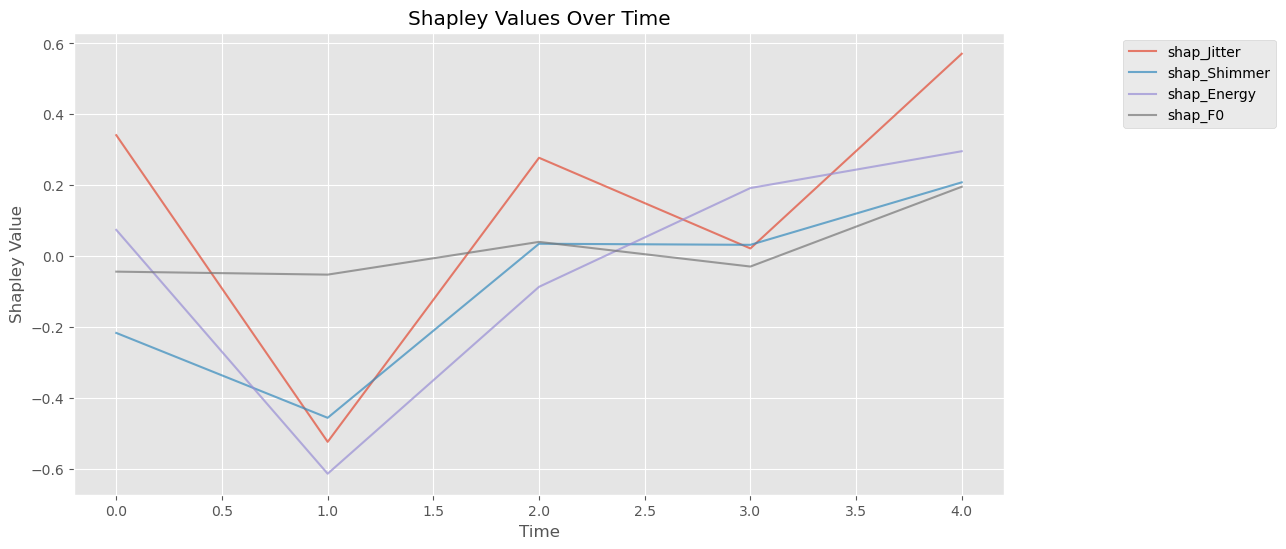

In [829]:
# Call the function to plot
plot_shap_values_over_time(shap_values_df_sim)

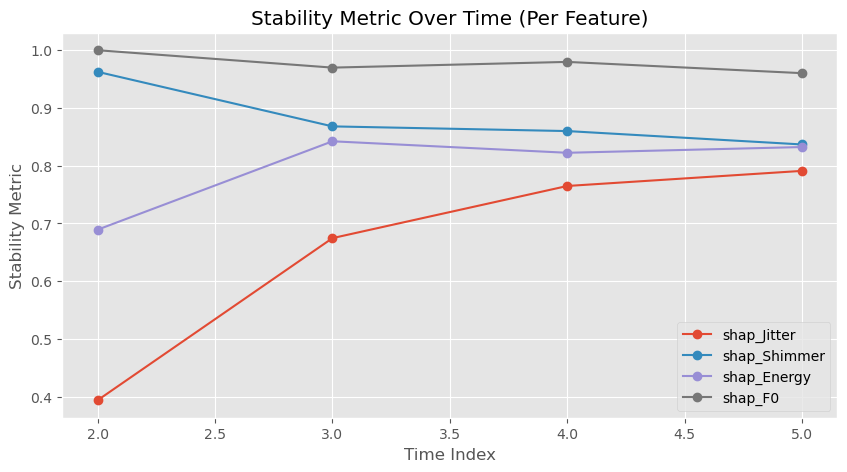

In [830]:
# Extract time index
time_index = results_sim['time_index']

# Align time index (excluding first value since stability is not defined for t=0)
time_index_trimmed = time_index[1:]

stability_values_SH = {feature: [] for feature in shap_values_df_sim.columns}

for t in range(1, len(time_index)):
    SH_subset = shap_values_df_sim.iloc[:t+1, :]
    
    stability_result = compute_stability_metric(SH_subset, model_performance=None, standardize=False)
    
    for feature, value in zip(shap_values_df_sim.columns, stability_result):
        stability_values_SH[feature].append(value)

# Plot each feature separately
plt.figure(figsize=(10, 5))
for feature, values in stability_values_SH.items():
    plt.plot(time_index_trimmed, values, marker='o', linestyle='-', label=feature)

plt.xlabel("Time Index")
plt.ylabel("Stability Metric")
plt.title("Stability Metric Over Time (Per Feature)")
plt.legend()
plt.grid(True)
plt.show()

In [831]:
# 1. Extract Feature Importance values (all columns except 'time_index' and 'roc_auc')
FI_df_sim = results_sim_FI.drop(columns=['time_index', 'model performance'])

# 2. Extract model performance
model_performance_FI = results_sim_FI['model performance']

# 3. Call compute_stability_metric function
stability_metric_FI = compute_stability_metric(FI_df_sim, model_performance=None, standardize=False)

# 4. Display the stability metric for each feature
print(stability_metric_FI)

FI_Jitter     0.999335
FI_Shimmer    0.999389
FI_Energy     0.999890
FI_F0         0.999395
dtype: float64


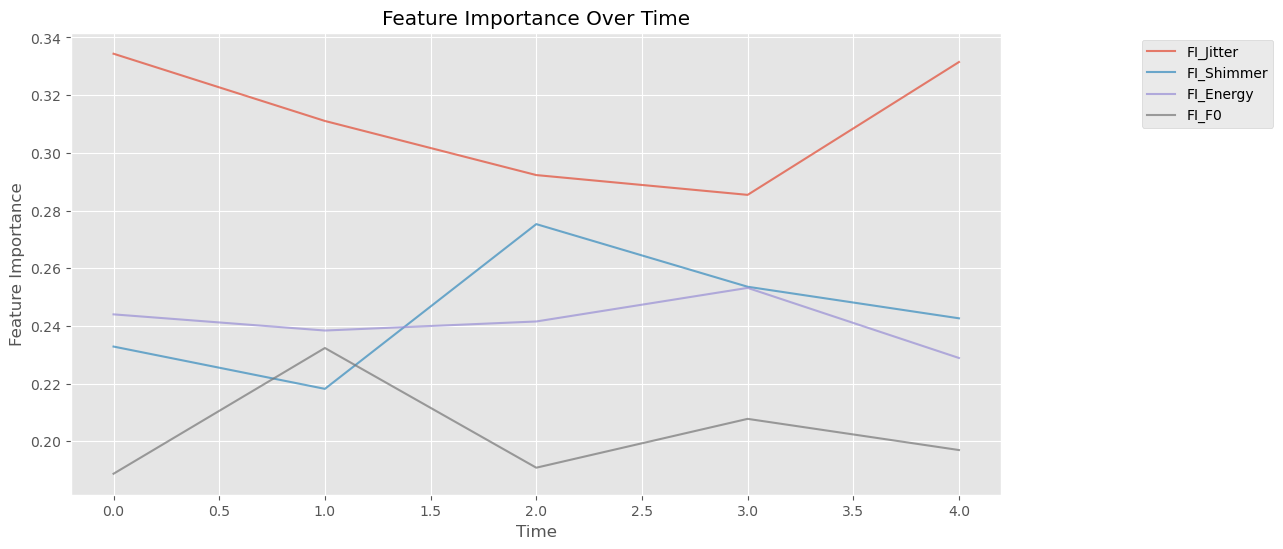

In [832]:
# Call the function to plot
plot_FI_over_time(FI_df_sim)

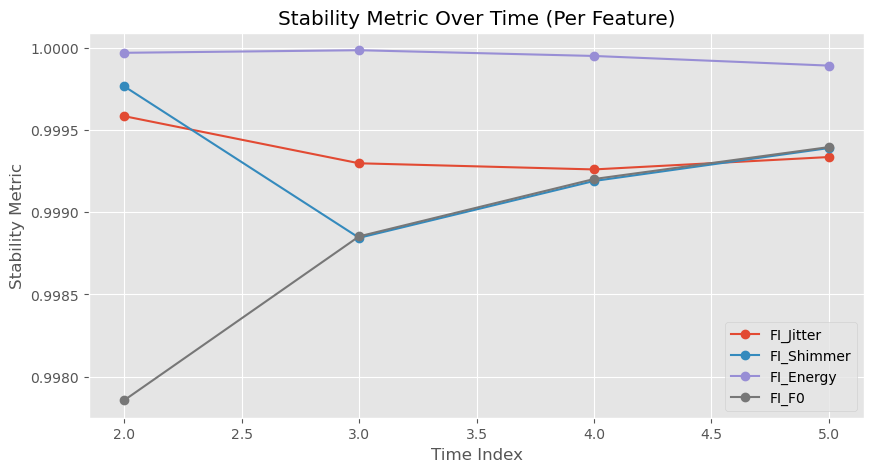

In [833]:
stability_values = {feature: [] for feature in FI_df_sim.columns}

for t in range(1, len(time_index)):
    FI_subset = FI_df_sim.iloc[:t+1, :]
    
    stability_result = compute_stability_metric(FI_subset, model_performance=None, standardize=False)
    
    for feature, value in zip(FI_df_sim.columns, stability_result):
        stability_values[feature].append(value)

# Plot each feature separately
plt.figure(figsize=(10, 5))
for feature, values in stability_values.items():
    plt.plot(time_index_trimmed, values, marker='o', linestyle='-', label=feature)

plt.xlabel("Time Index")
plt.ylabel("Stability Metric")
plt.title("Stability Metric Over Time (Per Feature)")
plt.legend()
plt.grid(True)
plt.show()

##### With Performance-based Weighting

In [834]:
# 1. Extract SHAP values (all columns except 'time_index' and 'roc_auc')
shap_values_df_sim = results_sim.drop(columns=['time_index', 'model performance'])

# 2. Extract model performance
model_performance = results_sim['model performance']

# 3. Call compute_stability_metric function
stability_metric = compute_stability_metric(shap_values_df_sim, model_performance, standardize=False)

# 4. Display the stability metric for each feature
print(stability_metric)

shap_Jitter     0.861851
shap_Shimmer    0.858894
shap_Energy     0.873475
shap_F0         0.965349
dtype: float64


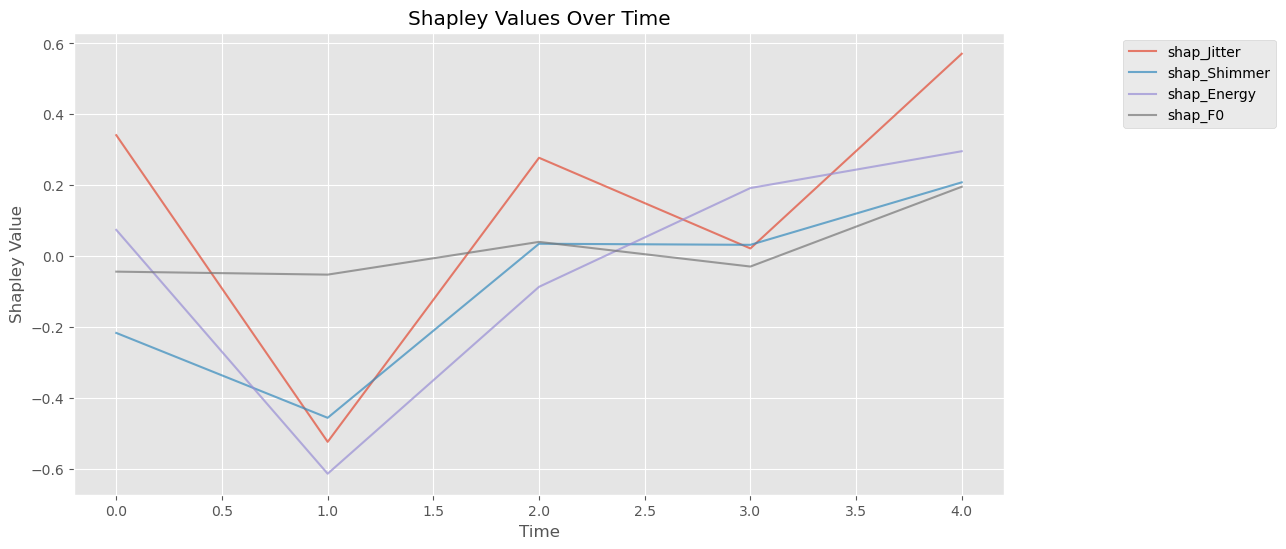

In [835]:
# Call the function to plot
plot_shap_values_over_time(shap_values_df_sim)

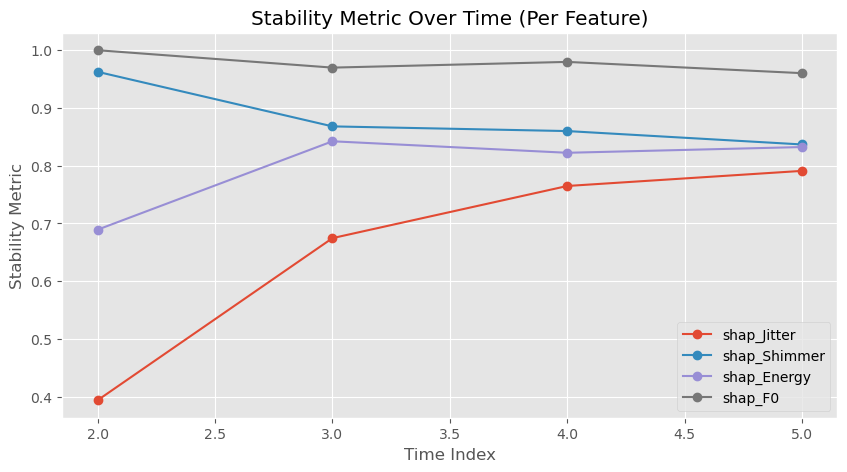

In [836]:
stability_values_SH = {feature: [] for feature in shap_values_df_sim.columns}

for t in range(1, len(time_index)):
    SH_subset = shap_values_df_sim.iloc[:t+1, :]
    
    stability_result = compute_stability_metric(SH_subset, model_performance=None, standardize=False)
    
    for feature, value in zip(shap_values_df_sim.columns, stability_result):
        stability_values_SH[feature].append(value)

# Plot each feature separately
plt.figure(figsize=(10, 5))
for feature, values in stability_values_SH.items():
    plt.plot(time_index_trimmed, values, marker='o', linestyle='-', label=feature)

plt.xlabel("Time Index")
plt.ylabel("Stability Metric")
plt.title("Stability Metric Over Time (Per Feature)")
plt.legend()
plt.grid(True)
plt.show()

In [837]:
# 1. Extract Feature Importance values (all columns except 'time_index' and 'roc_auc')
FI_df_sim = results_sim_FI.drop(columns=['time_index', 'model performance'])

# 2. Extract model performance
model_performance_FI = results_sim_FI['model performance']

# 3. Call compute_stability_metric function
stability_metric_FI = compute_stability_metric(FI_df_sim, model_performance_FI, standardize=False)

# 4. Display the stability metric for each feature
print(stability_metric_FI)

FI_Jitter     0.999442
FI_Shimmer    0.999490
FI_Energy     0.999905
FI_F0         0.999630
dtype: float64


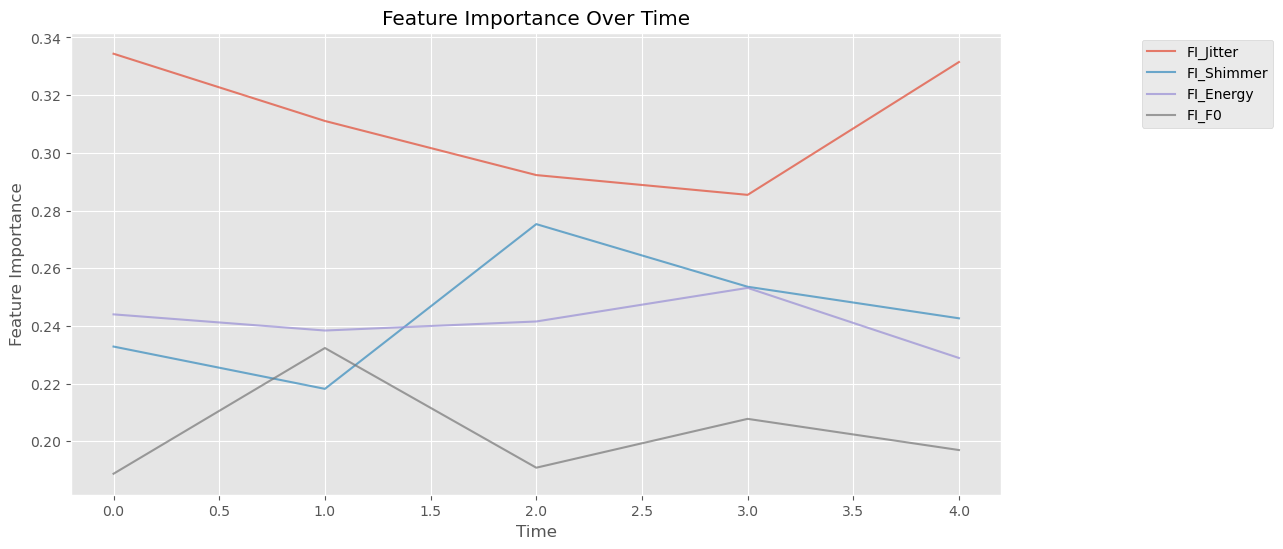

In [838]:
# Call the function to plot
plot_FI_over_time(FI_df_sim)

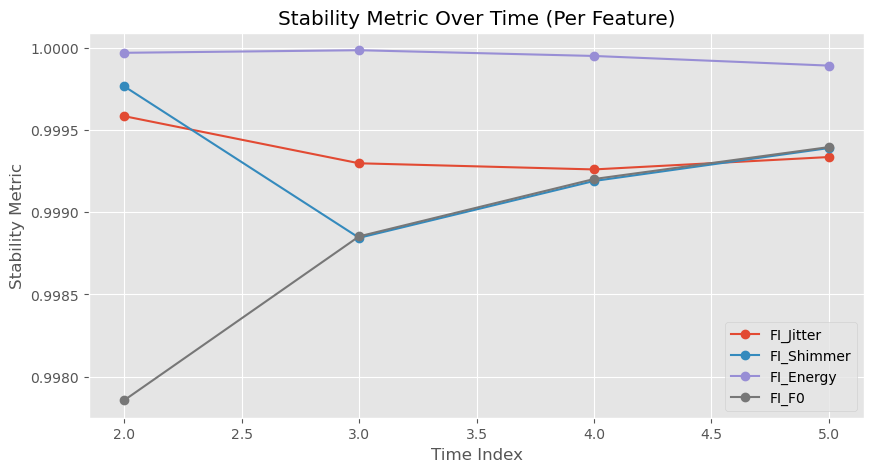

In [839]:
stability_values = {feature: [] for feature in FI_df_sim.columns}

for t in range(1, len(time_index)):
    FI_subset = FI_df_sim.iloc[:t+1, :]
    
    stability_result = compute_stability_metric(FI_subset, model_performance=None, standardize=False)
    
    for feature, value in zip(FI_df_sim.columns, stability_result):
        stability_values[feature].append(value)

# Plot each feature separately
plt.figure(figsize=(10, 5))
for feature, values in stability_values.items():
    plt.plot(time_index_trimmed, values, marker='o', linestyle='-', label=feature)

plt.xlabel("Time Index")
plt.ylabel("Stability Metric")
plt.title("Stability Metric Over Time (Per Feature)")
plt.legend()
plt.grid(True)
plt.show()

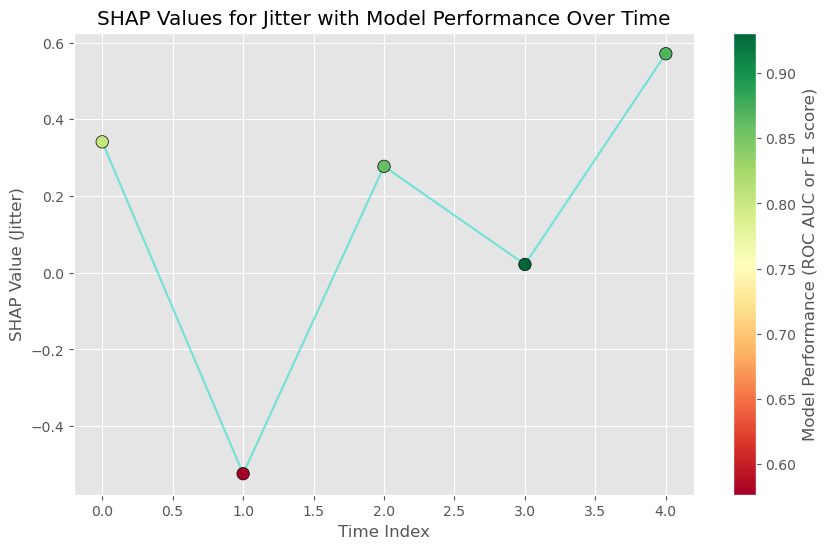

In [840]:
# Extract SHAP values for 'shap_jitter' and model performance 
shap_values_jitter = shap_values_df_sim['shap_Jitter']
roc_auc_values = model_performance

# Create a figure
fig, ax = plt.subplots(figsize=(10, 6))

# Create a colormap to color the markers by model performance values
scatter = ax.plot(range(len(shap_values_jitter)), shap_values_jitter, color='turquoise', marker='o', markersize=6, label='SHAP jitter', alpha=0.7)

# Use a scatter plot with colormap to color the markers by model performance
sc = ax.scatter(range(len(roc_auc_values)), shap_values_jitter, c=roc_auc_values, cmap='RdYlGn', edgecolors='k', s=80, zorder=5)

# Set the labels
ax.set_xlabel('Time Index')
ax.set_ylabel('SHAP Value (Jitter)')

# Add a colorbar for the model performance values
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Model Performance (ROC AUC or F1 score)')

# Add title
plt.title('SHAP Values for Jitter with Model Performance Over Time')

# Show the plot
plt.grid(True)
plt.show()

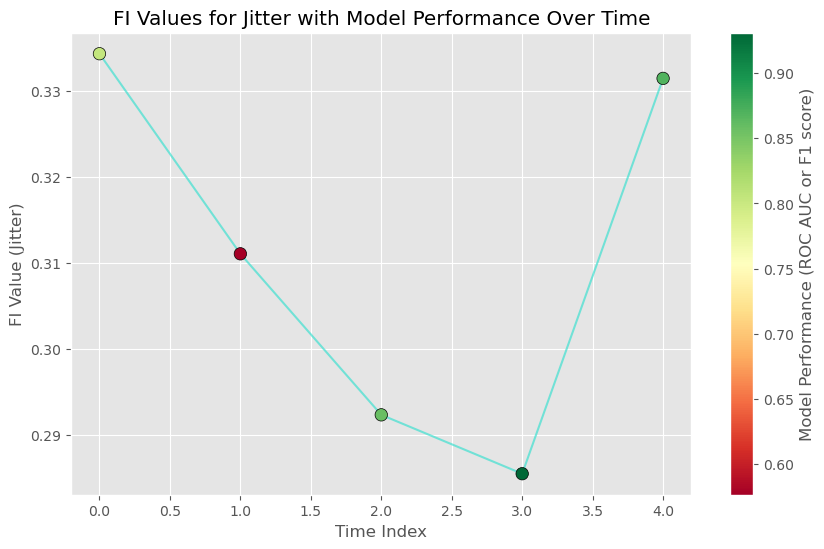

In [841]:
# Extract Feature Importance values for 'shap_jitter' and model performance
FI_jitter = FI_df_sim['FI_Jitter']
roc_auc_values = model_performance_FI

# Create a figure
fig, ax = plt.subplots(figsize=(10, 6))

# Create a colormap to color the markers by model performance values
scatter = ax.plot(range(len(FI_jitter)), FI_jitter, color='turquoise', marker='o', markersize=6, label='FI jitter', alpha=0.7)

# Use a scatter plot with colormap to color the markers by model performance
sc = ax.scatter(range(len(roc_auc_values)), FI_jitter, c=roc_auc_values, cmap='RdYlGn', edgecolors='k', s=80, zorder=5)

# Set the labels
ax.set_xlabel('Time Index')
ax.set_ylabel('FI Value (Jitter)')

# Add a colorbar for the mdoel performance values
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Model Performance (ROC AUC or F1 score)')

# Add title
plt.title('FI Values for Jitter with Model Performance Over Time')

# Show the plot
plt.grid(True)
plt.show()

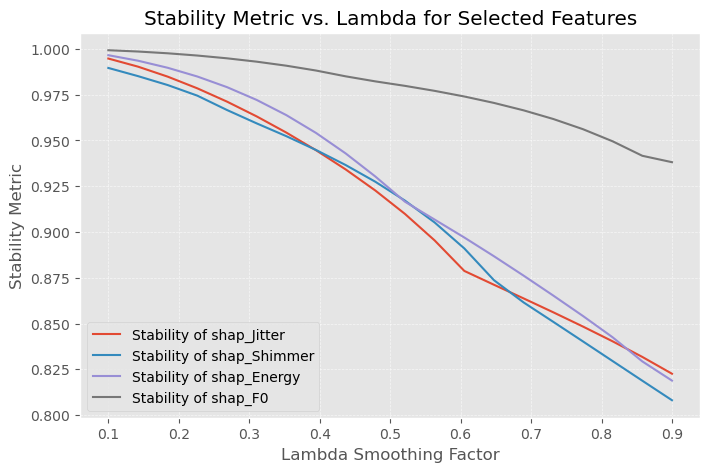

In [842]:
# Define the features to analyze
feature_names = ["shap_Jitter", "shap_Shimmer", "shap_Energy", "shap_F0"] 

# Define lambda values to test (from 0.1 to 0.9)
lambda_values = np.linspace(0.1, 0.9, 20)

# Compute stability metric for each lambda value and each feature
stability_scores = {feature: [] for feature in feature_names}

for l in lambda_values:
    stability_metric = compute_stability_metric(shap_values_df_sim, model_performance, lambda_smoothing=l)
    for feature in feature_names:
        stability_scores[feature].append(stability_metric[feature])

# Plot results
plt.figure(figsize=(8, 5))

for feature in feature_names:
    plt.plot(lambda_values, stability_scores[feature], linestyle='-', label=f"Stability of {feature}")

# Customize plot appearance
plt.xlabel("Lambda Smoothing Factor")
plt.ylabel("Stability Metric")
plt.title("Stability Metric vs. Lambda for Selected Features")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
plt.show()

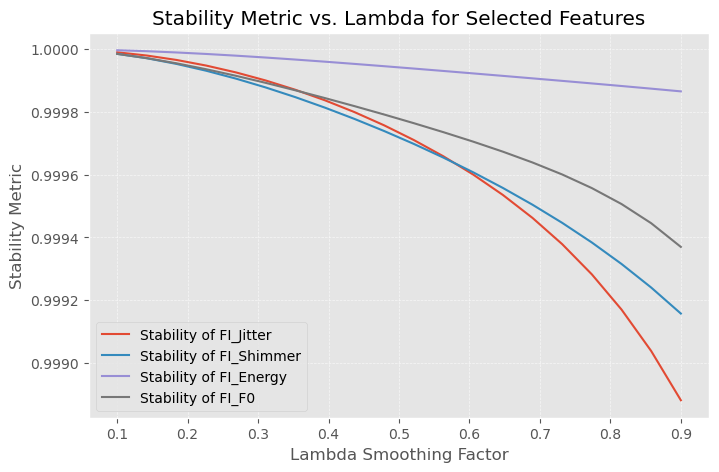

In [843]:
# Define the features to analyze
feature_names = ["FI_Jitter", "FI_Shimmer", "FI_Energy", "FI_F0"] 

# Define lambda values to test (from 0.1 to 0.9)
lambda_values = np.linspace(0.1, 0.9, 20)

# Compute stability metric for each lambda value and each feature
stability_scores_FI = {feature: [] for feature in feature_names}

for l in lambda_values:
    stability_metric_FI = compute_stability_metric(FI_df_sim, model_performance_FI, lambda_smoothing=l)
    for feature in feature_names:
        stability_scores_FI[feature].append(stability_metric_FI[feature])

# Plot results
plt.figure(figsize=(8, 5))

for feature in feature_names:
    plt.plot(lambda_values, stability_scores_FI[feature], linestyle='-', label=f"Stability of {feature}")

# Customize plot appearance
plt.xlabel("Lambda Smoothing Factor")
plt.ylabel("Stability Metric")
plt.title("Stability Metric vs. Lambda for Selected Features")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
plt.show()

### 5 Years

#### Data Simulation

Euthymic: 738
Depressive: 356
Manic: 731


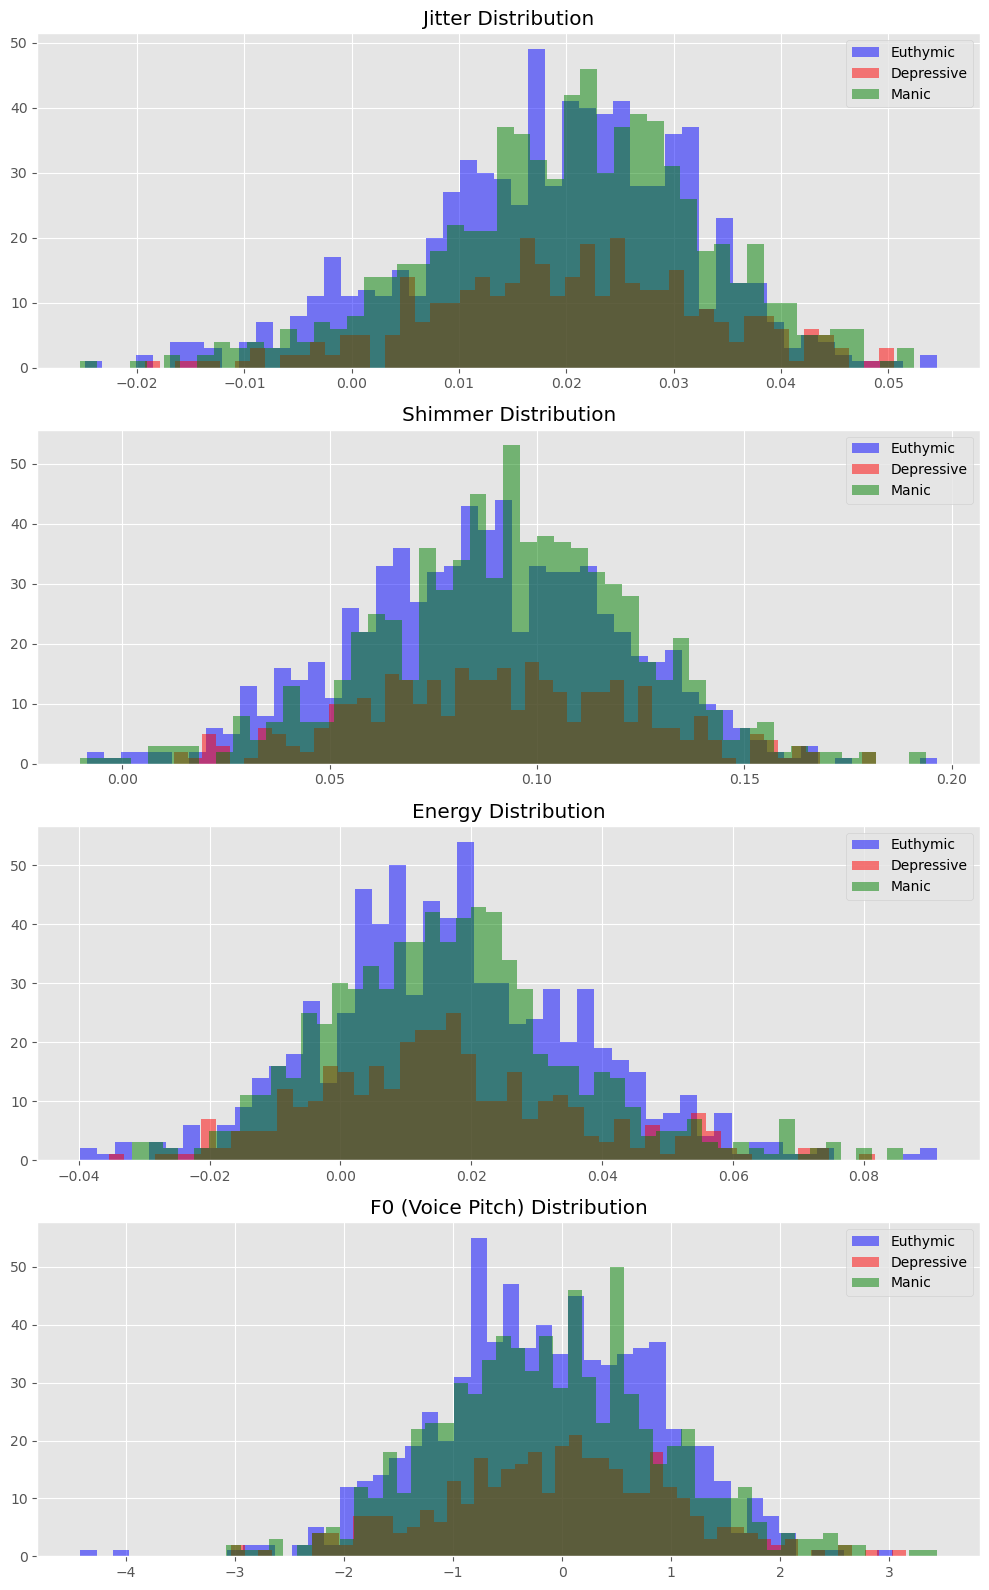

In [844]:
# Simulate 5 years of mood changes with voice features
mood_series_5y, voice_features_5y, state_counts_5y = generate_mood_series(days=1825)

fig, axs = plt.subplots(4, 1, figsize=(10, 16))

# Jitter plot
axs[0].hist(voice_features_5y['jitter'][:state_counts_5y[HEALTHY]], bins=50, alpha=0.5, label='Euthymic', color='blue')
axs[0].hist(voice_features_5y['jitter'][state_counts_5y[HEALTHY]:state_counts_5y[HEALTHY] + state_counts_5y[DEPRESSED]], bins=50, alpha=0.5, label='Depressive', color='red')
axs[0].hist(voice_features_5y['jitter'][-state_counts_5y[MANIC]:], bins=50, alpha=0.5, label='Manic', color='green')
axs[0].set_title('Jitter Distribution')
axs[0].legend()

# Shimmer plot
axs[1].hist(voice_features_5y['shimmer'][:state_counts_5y[HEALTHY]], bins=50, alpha=0.5, label='Euthymic', color='blue')
axs[1].hist(voice_features_5y['shimmer'][state_counts_5y[HEALTHY]:state_counts_5y[HEALTHY] + state_counts_5y[DEPRESSED]], bins=50, alpha=0.5, label='Depressive', color='red')
axs[1].hist(voice_features_5y['shimmer'][-state_counts_5y[MANIC]:], bins=50, alpha=0.5, label='Manic', color='green')
axs[1].set_title('Shimmer Distribution')
axs[1].legend()

# Energy plot
axs[2].hist(voice_features_5y['energy'][:state_counts_5y[HEALTHY]], bins=50, alpha=0.5, label='Euthymic', color='blue')
axs[2].hist(voice_features_5y['energy'][state_counts_5y[HEALTHY]:state_counts_5y[HEALTHY] + state_counts_5y[DEPRESSED]], bins=50, alpha=0.5, label='Depressive', color='red')
axs[2].hist(voice_features_5y['energy'][-state_counts_5y[MANIC]:], bins=50, alpha=0.5, label='Manic', color='green')
axs[2].set_title('Energy Distribution')
axs[2].legend()

# F0 (Voice Pitch) plot
axs[3].hist(voice_features_5y['f0'][:state_counts_5y[HEALTHY]], bins=50, alpha=0.5, label='Euthymic', color='blue')
axs[3].hist(voice_features_5y['f0'][state_counts_5y[HEALTHY]:state_counts_5y[HEALTHY] + state_counts_5y[DEPRESSED]], bins=50, alpha=0.5, label='Depressive', color='red')
axs[3].hist(voice_features_5y['f0'][-state_counts_5y[MANIC]:], bins=50, alpha=0.5, label='Manic', color='green')
axs[3].set_title('F0 (Voice Pitch) Distribution')
axs[3].legend()

plt.tight_layout()
plt.show()

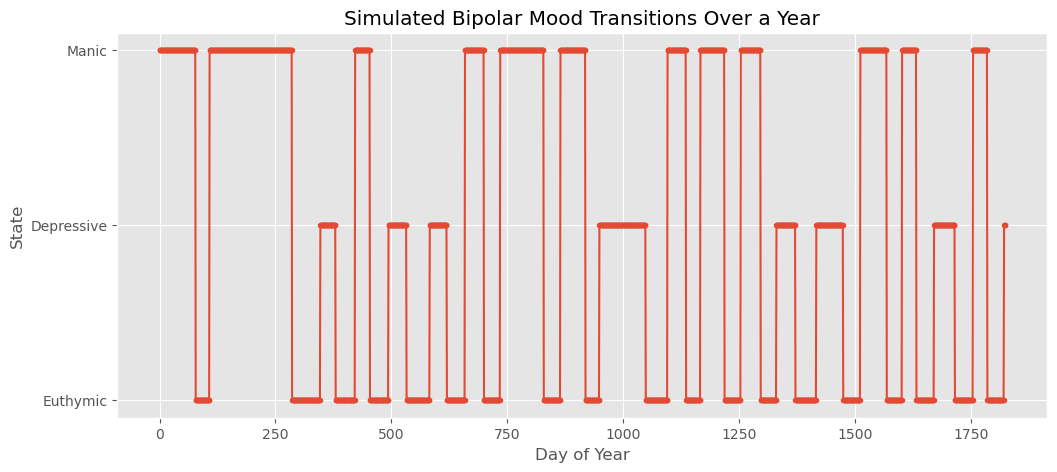

In [845]:
# Plot the results
plt.figure(figsize=(12, 5))
plt.plot(mood_series_5y, marker='o', linestyle='-', markersize=3)
plt.yticks([HEALTHY, DEPRESSED, MANIC], ['Euthymic', 'Depressive', 'Manic'])
plt.xlabel("Day of Year")
plt.ylabel("State")
plt.title("Simulated Bipolar Mood Transitions Over a Year")
plt.show()

In [846]:
data = {
    'Day': np.arange(1, 1826),
    'State': [states[state] for state in mood_series_5y],
    'Jitter': voice_features_5y['jitter'],
    'Shimmer': voice_features_5y['shimmer'],
    'Energy': voice_features_5y['energy'],
    'F0': voice_features_5y['f0']
}

sim_df = pd.DataFrame(data)

sim_df.head(20)

Day  State    Jitter   Shimmer    Energy        F0
0     1  Manic  0.010923  0.074584  0.010325 -0.812928
1     2  Manic  0.011260  0.034872  0.041365 -0.835802
2     3  Manic  0.004828  0.070619  0.022016 -1.029353
3     4  Manic  0.025826  0.051240  0.020987 -2.183243
4     5  Manic  0.010420  0.038712 -0.007038 -1.869804
5     6  Manic  0.011490  0.101171  0.038415 -1.240554
6     7  Manic  0.020711  0.065745  0.017814 -0.069033
7     8  Manic  0.014325  0.091985  0.031065  0.591848
8     9  Manic  0.009021  0.124658  0.037471 -0.771955
9    10  Manic  0.022798  0.068061  0.024339 -0.220376
10   11  Manic -0.004097  0.099068  0.009583  1.795318
11   12  Manic  0.017866  0.076531  0.012144 -1.523505
12   13  Manic  0.034059  0.029308  0.009740 -0.048863
13   14  Manic  0.011973  0.066219  0.019046  0.939075
14   15  Manic -0.004780  0.112099  0.022827 -0.269151
15   16  Manic  0.031531  0.048675  0.006611 -0.889052
16   17  Manic  0.005044  0.113285  0.053534 -2.146872
17   18  Manic -0.004948  0.064858  0.035766 -0.446969
18   19  Manic -0.007269  0.091570  0.048576  1.157857
19   20  Manic  0.007004  0.049772  0.070322  0.206519

In [847]:
# Jitter Distribution
jitter_means_base = [0.022, 0.023, 0.021]
jitter_stds_base = [0.007, 0.008, 0.012]

# Shimmer Distribution 
shimmer_means_base = [0.096, 0.099, 0.086]
shimmer_stds_base = [0.027, 0.029, 0.031]

# Energy Distribution 
energy_means_base = [0.014, 0.007, 0.017]
energy_stds_base = [0.014, 0.012, 0.022]

# Voice Pitch (F0) Distribution
f0_means_base = [-0.139, -0.131, -0.170]  
f0_stds_base = [1.023, 1.088, 0.982] 

# Function to generate observations for each state
def generate_base_data(num_observations = 60):
    data = {
        'State': [],
        'Jitter': [],
        'Shimmer': [],
        'Energy': [],
        'F0': []
    }
    
    for state in [HEALTHY, DEPRESSED, MANIC]:
        # Generate data for each state
        for _ in range(num_observations):
            jitter = np.random.normal(jitter_means_base[state], jitter_stds_base[state])
            shimmer = np.random.normal(shimmer_means_base[state], shimmer_stds_base[state])
            energy = np.random.normal(energy_means_base[state], energy_stds_base[state])
            f0 = np.random.normal(f0_means_base[state], f0_stds_base[state])
            
            data['State'].append(states[state])
            data['Jitter'].append(jitter)
            data['Shimmer'].append(shimmer)
            data['Energy'].append(energy)
            data['F0'].append(f0)
    
    # Create DataFrame
    base_df = pd.DataFrame(data)
    return base_df

# Generate the base training dataset
base_df = generate_base_data()

# Display the first 20 rows to verify
print(base_df.head(20))

       State    Jitter   Shimmer    Energy        F0
0   Euthymic  0.029737  0.097220  0.012388 -0.554960
1   Euthymic  0.002903  0.110389  0.028992 -0.094533
2   Euthymic  0.011825  0.150190  0.043973  0.094708
3   Euthymic  0.017319  0.144010  0.027061  0.810889
4   Euthymic  0.026992  0.065203  0.018439  1.284370
5   Euthymic  0.021360  0.066874  0.020160  2.168671
6   Euthymic  0.018386  0.082941 -0.002855  0.441031
7   Euthymic  0.023179  0.076529  0.020863 -0.077062
8   Euthymic  0.028570  0.070869  0.017369 -0.899108
9   Euthymic  0.014338  0.100248  0.021820  0.459367
10  Euthymic  0.007351  0.137978  0.008684  0.042730
11  Euthymic  0.018667  0.068005  0.027128 -0.116275
12  Euthymic  0.027214  0.058246  0.023431 -0.526672
13  Euthymic  0.026147  0.116004 -0.014801  0.241276
14  Euthymic  0.006231  0.080450  0.021224 -0.280967
15  Euthymic  0.012007  0.070447  0.018682 -0.482819
16  Euthymic  0.021014  0.144411  0.016125  0.535947
17  Euthymic  0.024539  0.100033  0.021639  0.

In [848]:
# Replace "Healthy" by 0 and "Depressed", "Manic" by 1 in both sim_df and base_df
sim_df['State'] = sim_df['State'].replace({'Euthymic': 0, 'Depressive': 1, 'Manic': 1})
base_df['State'] = base_df['State'].replace({'Euthymic': 0, 'Depressive': 1, 'Manic': 1})

In [849]:
sim_df_model = sim_df.drop("Day", axis=1)

#### Loop Through 5 Years

In [850]:
# Define initial conditions
train_size_first = 9
test_size = 64
train_additional = 9
base_train_size = 180 

# Initialize results dataframe
feature_names = sim_df_model.drop('State', axis=1).columns
results_sim = pd.DataFrame(columns=["time_index", "model performance"] + [f"shap_{feature}" for feature in feature_names])
results_sim_FI = pd.DataFrame(columns=["time_index", "model performance"] + [f"FI_{feature}" for feature in feature_names])

# Initialize training data with base_df + first 9 observations
train_df = pd.concat([base_df, sim_df_model.iloc[:train_size_first]])

# Define rolling start point
start_idx = train_size_first
time_index = 1

# Loop through 5 years 
while start_idx + test_size <= len(sim_df_model):
    
    # Define test set
    test_df = sim_df_model.iloc[start_idx:start_idx + test_size]

    # Train XGBoost model
    model = XGBClassifier(random_state=2025, eval_metric="logloss", objective='binary:logistic')
    model.fit(train_df.drop('State', axis=1), train_df['State'])

    # Check if test set contains both classes (0 and 1)
    if len(test_df['State'].unique()) > 1:
        y_pred_proba = model.predict_proba(test_df.drop(['State'], axis=1))[:, 1]
        roc_auc = roc_auc_score(test_df['State'], y_pred_proba)
    else:
        roc_auc = np.nan  # Assign NaN if only one class is present

    # If AUC is NaN, use F1 score instead
    if np.isnan(roc_auc):
        y_pred = model.predict(test_df.drop(['State'], axis=1))
        f1 = f1_score(test_df['State'], y_pred)
        roc_auc = f1 

    # Compute SHAP values
    explainer = shap.Explainer(model, train_df.drop('State', axis=1))
    shap_values = explainer(test_df.drop('State', axis=1))

    # Extract SHAP values
    shap_values_flat = shap_values.values.mean(axis=0)

    # Compute Feature Importance
    feature_importance_values = model.feature_importances_

    # Store results
    new_entry = pd.DataFrame([[time_index, roc_auc] + shap_values_flat.tolist()],
                             columns=results_sim.columns)
    results_sim = pd.concat([results_sim, new_entry], ignore_index=True)

    new_entry_FI = pd.DataFrame([[time_index, roc_auc] + feature_importance_values.tolist()],
                             columns=results_sim_FI.columns)
    results_sim_FI = pd.concat([results_sim_FI, new_entry_FI], ignore_index=True)

    # Update training set: Add previous training set, test set, and next 9 observations
    start_idx += (test_size + 9)  # Move to next window
    if start_idx + train_additional > len(sim_df_model):
        break  # Stop if there aren't enough data points left
    
    train_df = pd.concat([train_df, test_df, sim_df_model.iloc[start_idx:start_idx + train_additional]])

    time_index += 1  # Update time index
    print(f"Iteration {time_index}: start_idx={start_idx}, train_size={len(train_df)}, test_size={len(test_df)}")

# Display results
print(results_sim)
print(results_sim_FI)

Iteration 2: start_idx=82, train_size=262, test_size=64
Iteration 3: start_idx=155, train_size=335, test_size=64
Iteration 4: start_idx=228, train_size=408, test_size=64
Iteration 5: start_idx=301, train_size=481, test_size=64
Iteration 6: start_idx=374, train_size=554, test_size=64
Iteration 7: start_idx=447, train_size=627, test_size=64
Iteration 8: start_idx=520, train_size=700, test_size=64
Iteration 9: start_idx=593, train_size=773, test_size=64
Iteration 10: start_idx=666, train_size=846, test_size=64
Iteration 11: start_idx=739, train_size=919, test_size=64
Iteration 12: start_idx=812, train_size=992, test_size=64
Iteration 13: start_idx=885, train_size=1065, test_size=64
Iteration 14: start_idx=958, train_size=1138, test_size=64
Iteration 15: start_idx=1031, train_size=1211, test_size=64
Iteration 16: start_idx=1104, train_size=1284, test_size=64
Iteration 17: start_idx=1177, train_size=1357, test_size=64
Iteration 18: start_idx=1250, train_size=1430, test_size=64
Iteration 19:

#### Stability Metric Calculation

##### Without Performance-based Weighting

In [851]:
# 1. Extract SHAP values (all columns except 'time_index' and 'roc_auc')
shap_values_df_sim = results_sim.drop(columns=['time_index', 'model performance'])

# 2. Extract model performance
model_performance = results_sim['model performance']

# 3. Call compute_stability_metric function
stability_metric = compute_stability_metric(shap_values_df_sim, model_performance=None, standardize=False)

# 4. Display the stability metric for each feature
print(stability_metric)

shap_Jitter     0.823610
shap_Shimmer    0.895466
shap_Energy     0.872365
shap_F0         0.939699
dtype: float64


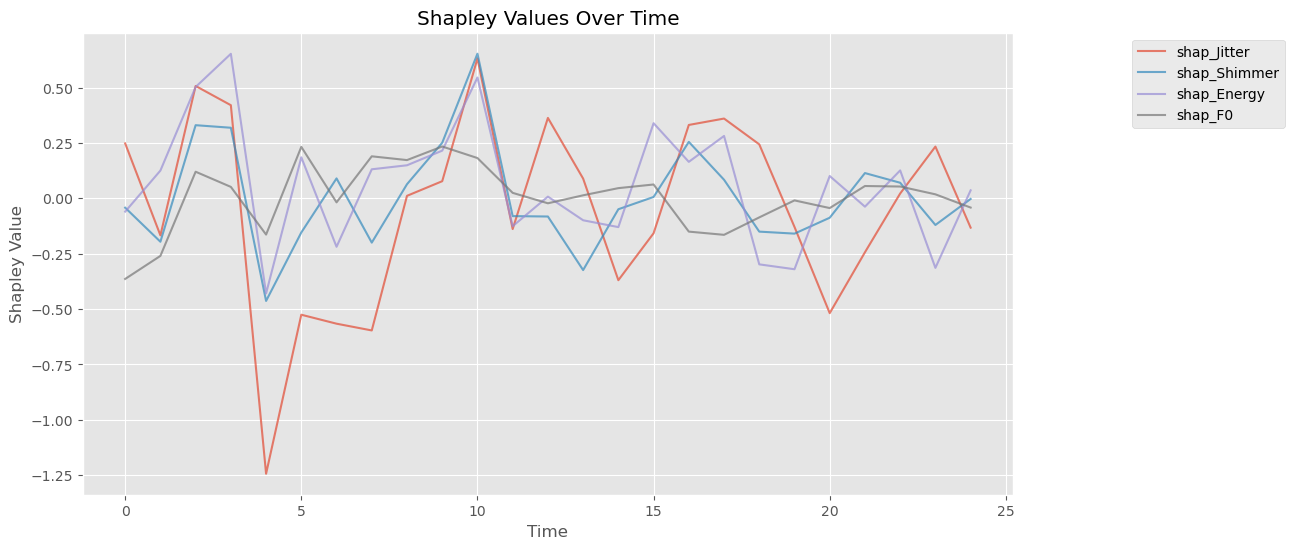

In [852]:
# Call the function to plot
plot_shap_values_over_time(shap_values_df_sim)

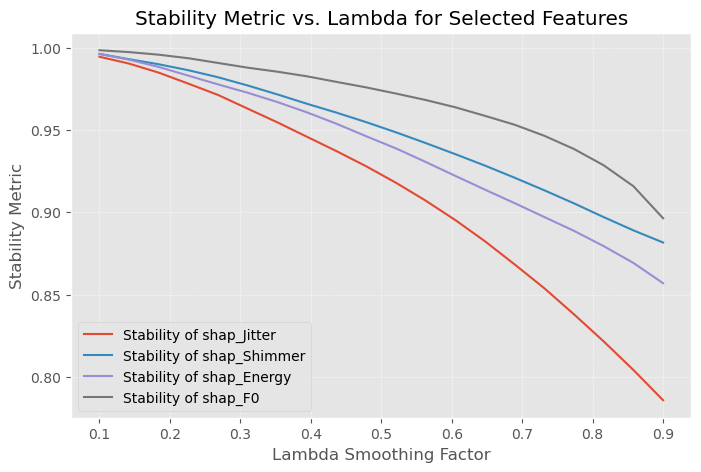

In [853]:
# Define the features to analyze
feature_names = ["shap_Jitter", "shap_Shimmer", "shap_Energy", "shap_F0"] 

# Define lambda values to test (from 0.1 to 0.9)
lambda_values = np.linspace(0.1, 0.9, 20)

# Compute stability metric for each lambda value and each feature
stability_scores = {feature: [] for feature in feature_names}

for l in lambda_values:
    stability_metric = compute_stability_metric(shap_values_df_sim, model_performance, lambda_smoothing=l)
    for feature in feature_names:
        stability_scores[feature].append(stability_metric[feature])

# Plot results
plt.figure(figsize=(8, 5))

for feature in feature_names:
    plt.plot(lambda_values, stability_scores[feature], linestyle='-', label=f"Stability of {feature}")

# Customize plot appearance
plt.xlabel("Lambda Smoothing Factor")
plt.ylabel("Stability Metric")
plt.title("Stability Metric vs. Lambda for Selected Features")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
plt.show()

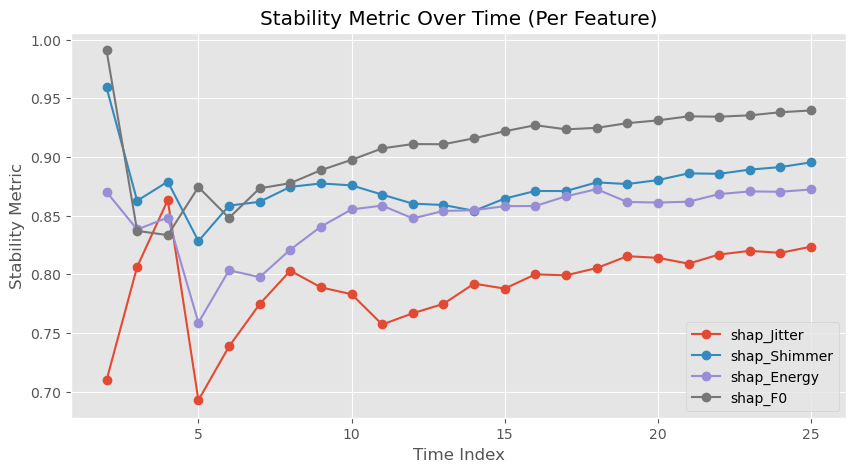

In [854]:
# Extract time index
time_index = results_sim['time_index']

# Align time index (excluding first value since stability is not defined for t=0)
time_index_trimmed = time_index[1:]

stability_values_SH = {feature: [] for feature in shap_values_df_sim.columns}

for t in range(1, len(time_index)):
    SH_subset = shap_values_df_sim.iloc[:t+1, :]
    
    stability_result = compute_stability_metric(SH_subset, model_performance=None, standardize=False)
    
    for feature, value in zip(shap_values_df_sim.columns, stability_result):
        stability_values_SH[feature].append(value)

# Plot each feature separately
plt.figure(figsize=(10, 5))
for feature, values in stability_values_SH.items():
    plt.plot(time_index_trimmed, values, marker='o', linestyle='-', label=feature)

plt.xlabel("Time Index")
plt.ylabel("Stability Metric")
plt.title("Stability Metric Over Time (Per Feature)")
plt.legend()
plt.grid(True)
plt.show()

In [855]:
# 1. Extract Feature Importance values (all columns except 'time_index' and 'roc_auc')
FI_df_sim = results_sim_FI.drop(columns=['time_index', 'model performance'])

# 2. Extract model performance
model_performance_FI = results_sim_FI['model performance']

# 3. Call compute_stability_metric function
stability_metric_FI = compute_stability_metric(FI_df_sim, model_performance=None, standardize=False)

# 4. Display the stability metric for each feature
print(stability_metric_FI)

FI_Jitter     0.999634
FI_Shimmer    0.999837
FI_Energy     0.999876
FI_F0         0.999857
dtype: float64


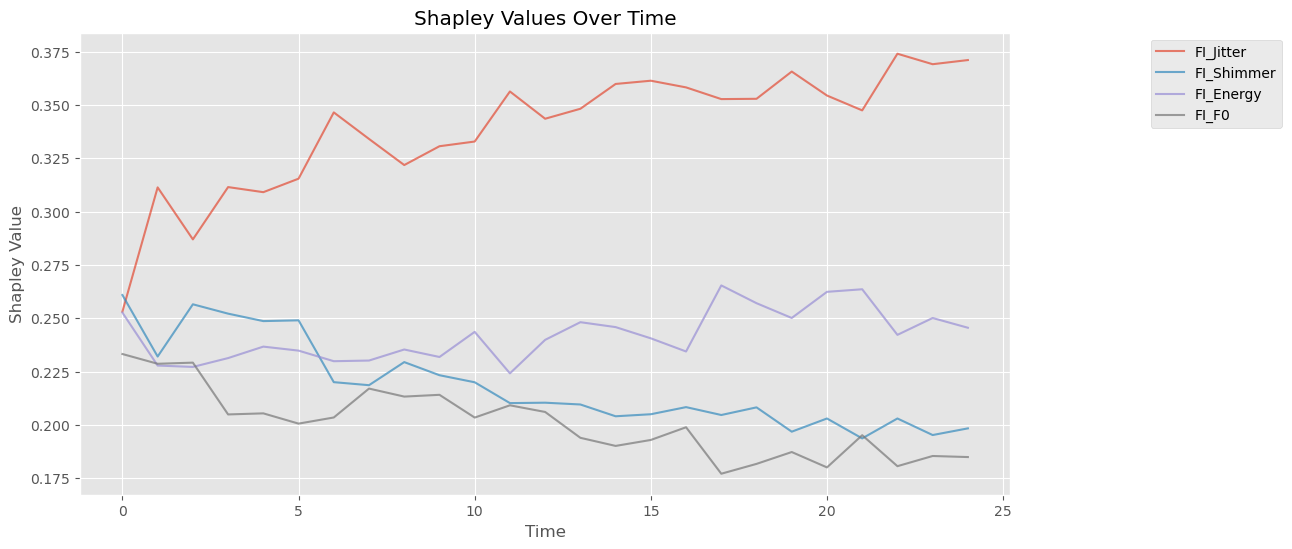

In [856]:
# Call the function to plot
plot_shap_values_over_time(FI_df_sim)

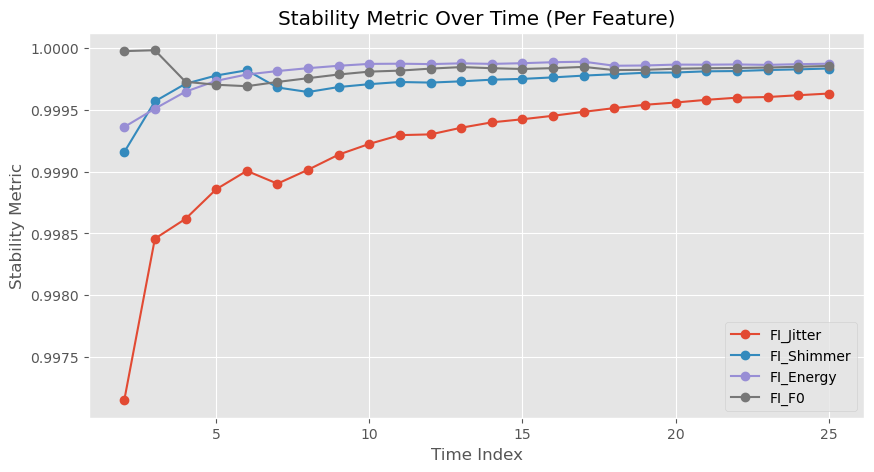

In [857]:
stability_values = {feature: [] for feature in FI_df_sim.columns}

for t in range(1, len(time_index)):
    FI_subset = FI_df_sim.iloc[:t+1, :]
    
    stability_result = compute_stability_metric(FI_subset, model_performance=None, standardize=False)
    
    for feature, value in zip(FI_df_sim.columns, stability_result):
        stability_values[feature].append(value)

# Plot each feature separately
plt.figure(figsize=(10, 5))
for feature, values in stability_values.items():
    plt.plot(time_index_trimmed, values, marker='o', linestyle='-', label=feature)

plt.xlabel("Time Index")
plt.ylabel("Stability Metric")
plt.title("Stability Metric Over Time (Per Feature)")
plt.legend()
plt.grid(True)
plt.show()

##### With Performance-based Weighting

In [858]:
# 1. Extract SHAP values (all columns except 'time_index' and 'roc_auc')
shap_values_df_sim = results_sim.drop(columns=['time_index', 'model performance'])

# 2. Extract model performance
model_performance = results_sim['model performance']

# 3. Call compute_stability_metric function
stability_metric = compute_stability_metric(shap_values_df_sim, model_performance, standardize=False)

# 4. Display the stability metric for each feature
print(stability_metric)

shap_Jitter     0.864633
shap_Shimmer    0.919106
shap_Energy     0.903540
shap_F0         0.951699
dtype: float64


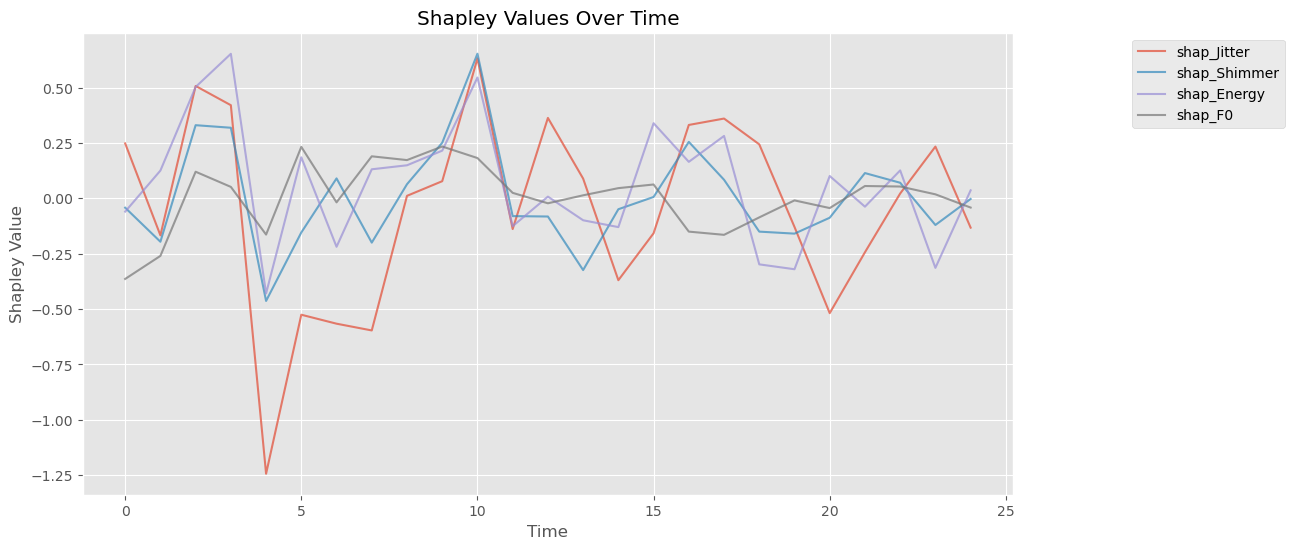

In [859]:
# Call the function to plot
plot_shap_values_over_time(shap_values_df_sim)

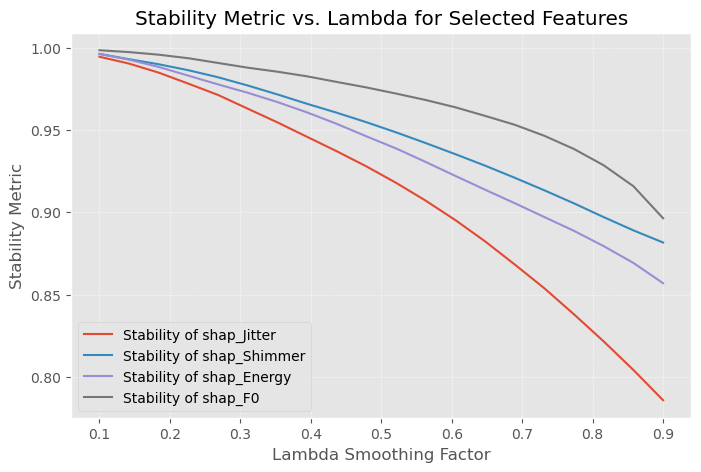

In [860]:
# Define the features to analyze
feature_names = ["shap_Jitter", "shap_Shimmer", "shap_Energy", "shap_F0"] 

# Define lambda values to test (from 0.1 to 0.9)
lambda_values = np.linspace(0.1, 0.9, 20)

# Compute stability metric for each lambda value and each feature
stability_scores = {feature: [] for feature in feature_names}

for l in lambda_values:
    stability_metric = compute_stability_metric(shap_values_df_sim, model_performance, lambda_smoothing=l)
    for feature in feature_names:
        stability_scores[feature].append(stability_metric[feature])

# Plot results
plt.figure(figsize=(8, 5))

for feature in feature_names:
    plt.plot(lambda_values, stability_scores[feature], linestyle='-', label=f"Stability of {feature}")

# Customize plot appearance
plt.xlabel("Lambda Smoothing Factor")
plt.ylabel("Stability Metric")
plt.title("Stability Metric vs. Lambda for Selected Features")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
plt.show()

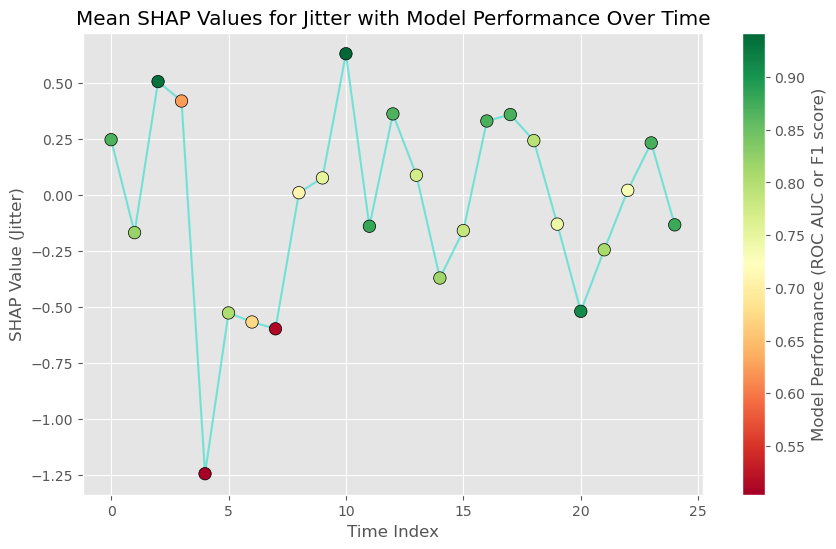

In [861]:
# Extract SHAP values for 'shap_jitter' and model performance 
shap_values_jitter = shap_values_df_sim['shap_Jitter']
roc_auc_values = model_performance

# Create a figure
fig, ax = plt.subplots(figsize=(10, 6))

# Create a colormap to color the markers by model performance values
scatter = ax.plot(range(len(shap_values_jitter)), shap_values_jitter, color='turquoise', marker='o', markersize=6, label='SHAP jitter', alpha=0.7)

# Use a scatter plot with colormap to color the markers by model performance
sc = ax.scatter(range(len(roc_auc_values)), shap_values_jitter, c=roc_auc_values, cmap='RdYlGn', edgecolors='k', s=80, zorder=5)

# Set the labels
ax.set_xlabel('Time Index')
ax.set_ylabel('SHAP Value (Jitter)')

# Add a colorbar for the model performance values
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Model Performance (ROC AUC or F1 score)')

# Add title
plt.title('Mean SHAP Values for Jitter with Model Performance Over Time')

# Show the plot
plt.grid(True)
plt.show()

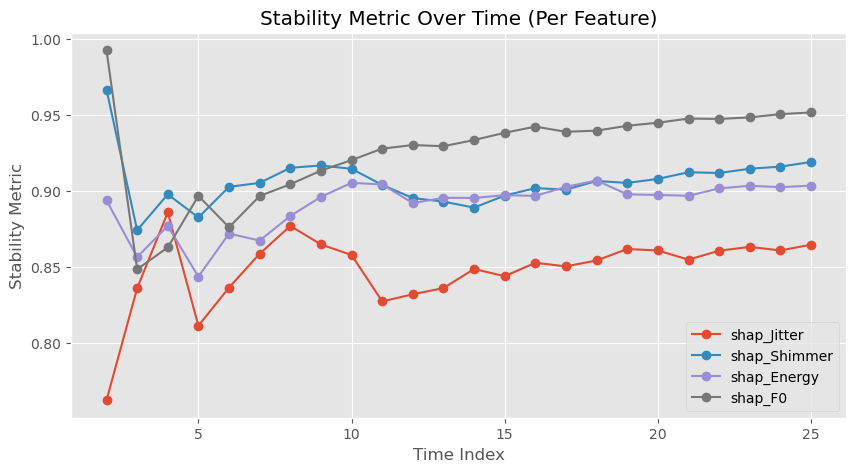

In [862]:
stability_values_SH = {feature: [] for feature in shap_values_df_sim.columns}

for t in range(1, len(time_index)):
    SH_subset = shap_values_df_sim.iloc[:t+1, :]
    
    stability_result = compute_stability_metric(SH_subset, model_performance.iloc[:t+1], standardize=False)
    
    for feature, value in zip(shap_values_df_sim.columns, stability_result):
        stability_values_SH[feature].append(value)

# Plot each feature separately
plt.figure(figsize=(10, 5))
for feature, values in stability_values_SH.items():
    plt.plot(time_index_trimmed, values, marker='o', linestyle='-', label=feature)

plt.xlabel("Time Index")
plt.ylabel("Stability Metric")
plt.title("Stability Metric Over Time (Per Feature)")
plt.legend()
plt.grid(True)
plt.show()

In [863]:
# 1. Extract Feature Importance values (all columns except 'time_index' and 'roc_auc')
FI_df_sim = results_sim_FI.drop(columns=['time_index', 'model performance'])

# 2. Extract model performance 
model_performance_FI = results_sim_FI['model performance']

# 3. Call compute_stability_metric function
stability_metric_FI = compute_stability_metric(FI_df_sim, model_performance=model_performance_FI, standardize=False)

# 4. Display the stability metric for each feature
print(stability_metric_FI)

FI_Jitter     0.999727
FI_Shimmer    0.999880
FI_Energy     0.999896
FI_F0         0.999895
dtype: float64


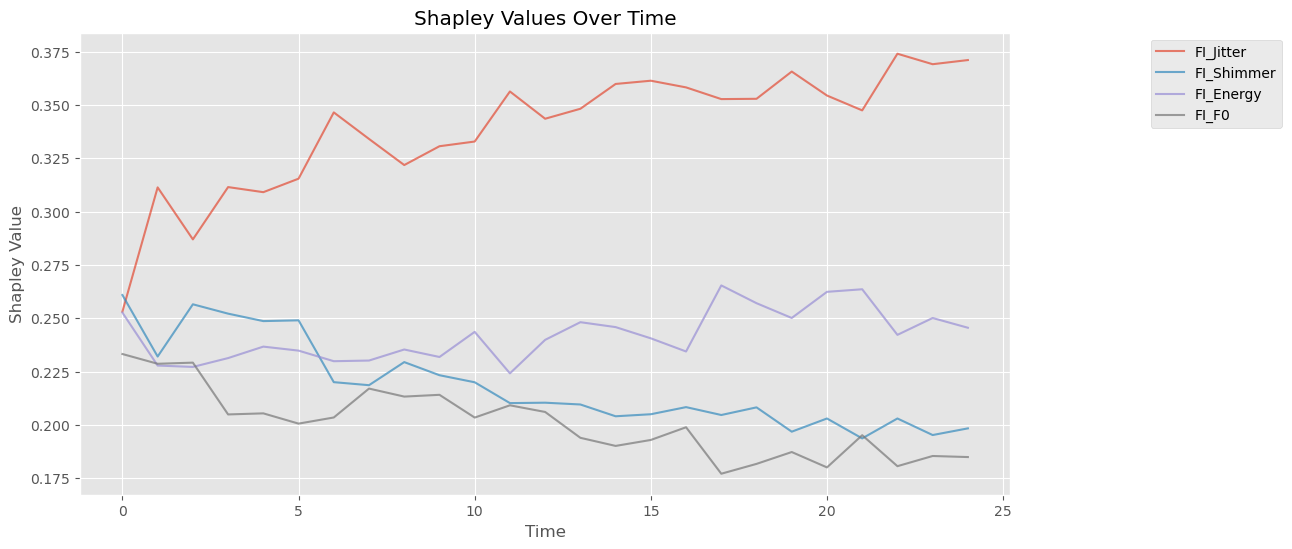

In [864]:
# Call the function to plot
plot_shap_values_over_time(FI_df_sim)

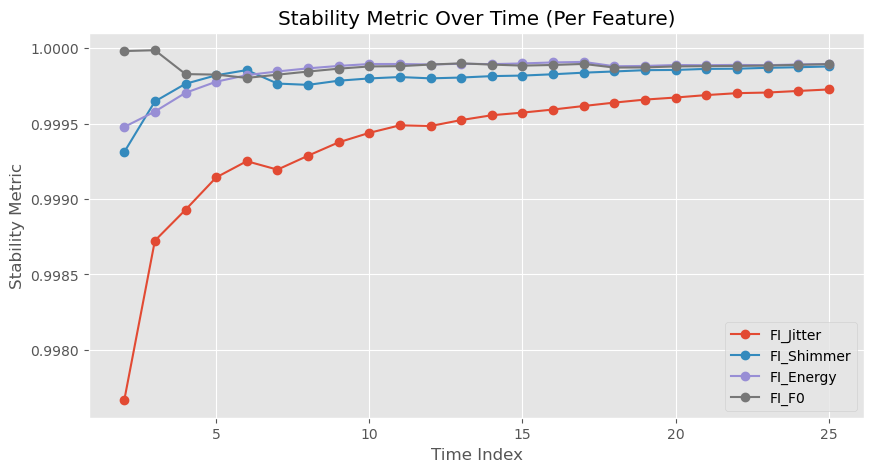

In [865]:
stability_values = {feature: [] for feature in FI_df_sim.columns}

for t in range(1, len(time_index)):
    FI_subset = FI_df_sim.iloc[:t+1, :]
    
    stability_result = compute_stability_metric(FI_subset, model_performance=model_performance_FI.iloc[:t+1], standardize=False)
    
    for feature, value in zip(FI_df_sim.columns, stability_result):
        stability_values[feature].append(value)

# Plot each feature separately
plt.figure(figsize=(10, 5))
for feature, values in stability_values.items():
    plt.plot(time_index_trimmed, values, marker='o', linestyle='-', label=feature)

plt.xlabel("Time Index")
plt.ylabel("Stability Metric")
plt.title("Stability Metric Over Time (Per Feature)")
plt.legend()
plt.grid(True)
plt.show()

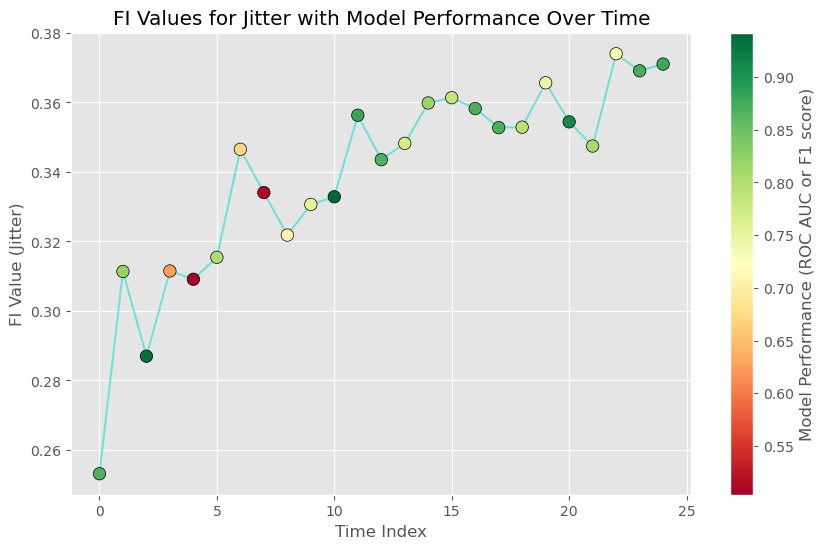

In [866]:
# Extract Feature Importance values for 'shap_jitter' and model performance 
FI_jitter = FI_df_sim['FI_Jitter']
roc_auc_values = model_performance_FI

# Create a figure
fig, ax = plt.subplots(figsize=(10, 6))

# Create a colormap to color the markers by model performance values
scatter = ax.plot(range(len(FI_jitter)), FI_jitter, color='turquoise', marker='o', markersize=6, label='FI jitter', alpha=0.7)

# Use a scatter plot with colormap to color the markers by model performance
sc = ax.scatter(range(len(roc_auc_values)), FI_jitter, c=roc_auc_values, cmap='RdYlGn', edgecolors='k', s=80, zorder=5)

# Set the labels
ax.set_xlabel('Time Index')
ax.set_ylabel('FI Value (Jitter)')

# Add a colorbar for the model performance values
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Model Performance (ROC AUC or F1 score)')

# Add title
plt.title('FI Values for Jitter with Model Performance Over Time')

# Show the plot
plt.grid(True)
plt.show()

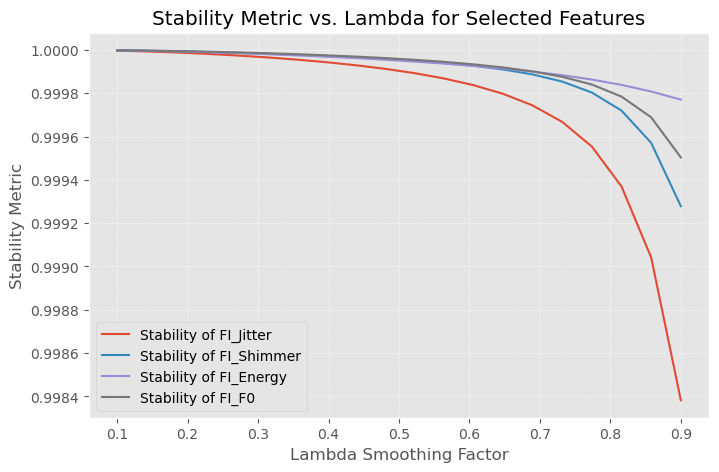

In [867]:
# Define the features to analyze
feature_names = ["FI_Jitter", "FI_Shimmer", "FI_Energy", "FI_F0"] 

# Define lambda values to test (from 0.1 to 0.9)
lambda_values = np.linspace(0.1, 0.9, 20)

# Compute stability metric for each lambda value and each feature
stability_scores_FI = {feature: [] for feature in feature_names}

for l in lambda_values:
    stability_metric_FI = compute_stability_metric(FI_df_sim, model_performance_FI, lambda_smoothing=l)
    for feature in feature_names:
        stability_scores_FI[feature].append(stability_metric_FI[feature])

# Plot results
plt.figure(figsize=(8, 5))

for feature in feature_names:
    plt.plot(lambda_values, stability_scores_FI[feature], linestyle='-', label=f"Stability of {feature}")

# Customize plot appearance
plt.xlabel("Lambda Smoothing Factor")
plt.ylabel("Stability Metric")
plt.title("Stability Metric vs. Lambda for Selected Features")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
plt.show()

## Rocket League Dataset

#### Loading Data and Loop Through the Intervals

In [868]:
df = pd.read_csv("...", delimiter=" ")
df.head()

BallAcceleration      Time  DistanceWall  DistanceCeil  DistanceBall  \
0          6.000000       NaN           NaN           NaN           NaN   
1       1636.798772  0.000000       3498.01       2012.98    299.668270   
2       3198.029397  0.138893       3494.08       2012.98    229.896780   
3          0.000000  0.173617       3494.08       2012.98    237.350599   
4       9914.766242  0.312510       3500.08       2012.98    151.880921   

     PlayerSpeed      BallSpeed   up  accelerate  slow  goal  left  boost  \
0            NaN            NaN  NaN         NaN   NaN   NaN   NaN    NaN   
1  104267.426232   99035.849337  0.0         0.0   0.0   0.0   0.0    0.0   
2  124248.031988  102233.878734  0.0         0.0   0.0   0.0   0.0    1.0   
3  124248.031988  102968.358990  0.0         0.0   0.0   0.0   0.0    1.0   
4  115248.016009  112883.125231  0.0         0.0   0.0   0.0   0.0    0.0   

   camera  down  right  slide  jump  Unnamed: 18  
0     NaN   NaN    NaN    NaN   NaN          NaN  
1     0.0   0.0    1.0    0.0   1.0          NaN  
2     0.0   0.0    1.0    0.0   1.0          NaN  
3     0.0   0.0    0.0    0.0   0.0          NaN  
4     0.0   0.0    1.0    0.0   0.0          NaN

In [869]:
df = df[1:]
df = df.drop('Unnamed: 18', axis=1)
df = df.drop('Time', axis=1)

In [870]:
num_intervals = (df['BallAcceleration'] == -1).sum() + 1

print(f"Number of intervals: {num_intervals}")

Number of intervals: 44


In [871]:
df.shape

(7189, 17)

In [872]:
df['goal'].value_counts()

goal
0.0    6043
1.0     849
Name: count, dtype: int64

In [873]:
# Identify separator rows: BallAcceleration == -1 and all other columns are NaN
separator_indices = df[(df['BallAcceleration'] == -1) & df.iloc[:, 1:].isna().all(axis=1)].index.tolist()

# Adjust for 1-based index: start_idx should also be adjusted by -1 to align properly with the slicing
intervals = []
start_idx = 1  

for idx in separator_indices:
    if start_idx < idx:  # Avoid empty intervals
        interval = df.iloc[start_idx-1:idx-1]  # Slice before the separator (adjust indices)
        if not interval.empty:
            intervals.append(interval)  # Only add if not empty
    start_idx = idx + 1  # Move start index after separator

# Add the last segment if valid (and also remove separator if present)
if start_idx <= len(df):  # Ensure the last segment is handled
    last_interval = df.iloc[start_idx-1:]  # Adjust to 1-based indexing
    if not last_interval.empty and not (
        last_interval.iloc[-1]['BallAcceleration'] == -1 and last_interval.iloc[-1, 1:].isna().all()
    ):
        intervals.append(last_interval)

# Ensure no empty intervals
intervals = [interval for interval in intervals if not interval.empty]

# Print interval count for verification
print(f"Total intervals: {len(intervals)}")

Total intervals: 44


In [874]:
intervals[0]

BallAcceleration  DistanceWall  DistanceCeil  DistanceBall    PlayerSpeed  \
1        1636.798772       3498.01       2012.98    299.668270  104267.426232   
2        3198.029397       3494.08       2012.98    229.896780  124248.031988   
3           0.000000       3494.08       2012.98    237.350599  124248.031988   
4        9914.766242       3500.08       2012.98    151.880921  115248.016009   
5        5907.747166       3521.65       2013.00    154.556104  125091.256173   
6           0.000000       3533.40       2013.10    149.496614  134706.206676   
7        -581.095135       3548.04       2013.00    148.715162  125937.158238   
8         647.244755       3548.04       2013.00    192.940752  125937.158238   
9           0.000000       3576.77       2013.03    221.113553  126848.413924   
10      12766.909897       3693.18       2013.15    155.587193  151895.307874   
11       -337.206552       3736.42       2013.05    143.671574  150965.603089   
12        740.454596       3781.40       2013.06    139.339802  146909.566295   
13        860.105988       3869.59       2013.14    192.752924  145352.915526   
14       4154.888174       3968.51       2013.09    175.696282  158377.185238   
15       2909.194981       4019.92       2013.00    158.841813  157493.823644   
16       -648.578314       3967.36       2013.01    145.825141  148187.792331   
17      -1554.775387       3925.57       2013.11    149.183325  146921.802538   
18       -875.153308       3889.69       2013.16    151.308845  151460.410596   
19       8347.386886       3864.04       2013.16    189.922248  158823.879782   
20          0.000000       3830.95       2013.08    167.632352  177024.811114   
21          0.000000       3829.96       2013.15    153.461730  172570.004190   
22       -403.762568       3840.91       2013.10    144.313922  167269.984606   
23          0.000000       3925.61       2010.67    215.195076  150952.876687   
24      -1125.672054       3945.12       1986.90    206.443527  148911.012450   
25          0.000000       3970.36       1960.75    238.540115  197271.879735   
26      33405.144871       4015.56       1937.96    238.223567  192221.353020   
27      -4319.103108       3892.04       1948.52    336.909819  192416.658310   
28       -585.174527       3842.44       1972.00    359.848795  193543.010241   
29    -195896.923082       3802.64       2005.09   5586.826337  188025.314461   
30       2163.000000       3804.80       1997.84   5743.826950  191541.338906   
31      -3648.000000       3784.07       1854.11   5978.528855  159439.709398   
32          0.000000       3750.84       1567.31   5868.428915  140658.608915   

        BallSpeed   up  accelerate  slow  goal  left  boost  camera  down  \
1    99035.849337  0.0         0.0   0.0   0.0   0.0    0.0     0.0   0.0   
2   102233.878734  0.0         0.0   0.0   0.0   0.0    1.0     0.0   0.0   
3   102968.358990  0.0         0.0   0.0   0.0   0.0    1.0     0.0   0.0   
4   112883.125231  0.0         0.0   0.0   0.0   0.0    0.0     0.0   0.0   
5   118790.872398  0.0         0.0   0.0   0.0   0.0    0.0     0.0   0.0   
6   128733.311070  0.0         0.0   0.0   0.0   0.0    1.0     0.0   0.0   
7   128152.215935  0.0         0.0   0.0   0.0   0.0    0.0     0.0   0.0   
8   128799.460690  0.0         0.0   0.0   0.0   0.0    1.0     0.0   0.0   
9   132047.850725  0.0         0.0   0.0   0.0   0.0    0.0     0.0   0.0   
10  144814.760622  0.0         0.0   0.0   0.0   0.0    0.0     0.0   0.0   
11  144477.554070  0.0         0.0   0.0   0.0   0.0    1.0     0.0   0.0   
12  145218.008666  0.0         0.0   0.0   0.0   0.0    0.0     0.0   0.0   
13  146078.114654  0.0         0.0   0.0   0.0   0.0    0.0     0.0   0.0   
14  150233.002829  0.0         0.0   0.0   0.0   0.0    0.0     0.0   0.0   
15  153142.197810  0.0         0.0   0.0   0.0   0.0    0.0     0.0   0.0   
16  152493.619496  0.0         0.0   0.0   0.0   0.0    0.0     0.0   0.0   
17  150938.844109  0.

In [875]:
# Initialize results 
feature_names = df.drop('goal', axis=1).columns
results_sim = pd.DataFrame(columns=["interval_index", "model performance"] + [f"shap_{feature}" for feature in feature_names])
results_sim_FI = pd.DataFrame(columns=["interval_index", "model performance"] + [f"FI_{feature}" for feature in feature_names])

# Initialize training with the first interval
train_df = intervals[0]

# Loop through intervals
for interval_index in range(1, len(intervals)):  # Start from the second interval
    test_df = intervals[interval_index]  # Current interval as test set

    # Train XGBoost model
    model = XGBClassifier(random_state=2025, eval_metric="logloss", objective='binary:logistic')
    model.fit(train_df.drop('goal', axis=1), train_df['goal'])

    # Check if test_df['goal'] contains NaN values and remove those rows
    if test_df['goal'].isna().any():
        test_df = test_df.dropna(subset=['goal'])
    
    # Ensure there are still both classes (0 and 1)
    if len(test_df['goal'].unique()) > 1:
        y_pred_proba = model.predict_proba(test_df.drop(['goal'], axis=1))[:, 1]
        roc_auc = roc_auc_score(test_df['goal'], y_pred_proba)
    else:
        roc_auc = np.nan  # Assign NaN if only one class is present
    
    # If AUC is NaN, use F1 score instead
    if np.isnan(roc_auc):
        y_pred = model.predict(test_df.drop(['goal'], axis=1))  

        f1 = f1_score(test_df['goal'], y_pred, zero_division=0) 
    
        # If F1 is still NaN or 0, fall back to accuracy score
        if np.isnan(f1) or f1 == 0:
            accuracy = accuracy_score(test_df['goal'], y_pred)
            roc_auc = accuracy  # Use accuracy as fallback
        else:
            roc_auc = f1  # Replace AUC with F1 score

    # Compute SHAP values
    explainer = shap.Explainer(model, train_df.drop('goal', axis=1))
    shap_values = explainer(test_df.drop('goal', axis=1), check_additivity=False)

    # Extract SHAP values
    shap_values_flat = shap_values.values.mean(axis=0)

    # Compute Feature Importance
    feature_importance_values = model.feature_importances_

    # Store results
    new_entry = pd.DataFrame([[interval_index, roc_auc] + shap_values_flat.tolist()], 
                             columns=results_sim.columns)
    results_sim = pd.concat([results_sim, new_entry], ignore_index=True)

    new_entry_FI = pd.DataFrame([[interval_index, roc_auc] + feature_importance_values.tolist()], 
                                columns=results_sim_FI.columns)
    results_sim_FI = pd.concat([results_sim_FI, new_entry_FI], ignore_index=True)

    # Update training set by adding the current test set
    train_df = pd.concat([train_df, test_df])

    print(f"Iteration {interval_index}: train_size={len(train_df)}, test_size={len(test_df)}")

# Display results
print(results_sim)
print(results_sim_FI)

Iteration 1: train_size=71, test_size=39
Iteration 2: train_size=105, test_size=34
Iteration 3: train_size=128, test_size=23
Iteration 4: train_size=484, test_size=356
Iteration 5: train_size=4549, test_size=4065
Iteration 6: train_size=4569, test_size=20
Iteration 7: train_size=4604, test_size=35
Iteration 8: train_size=4624, test_size=20
Iteration 9: train_size=4703, test_size=79
Iteration 10: train_size=4724, test_size=21
Iteration 11: train_size=4735, test_size=11
Iteration 12: train_size=4743, test_size=8
Iteration 13: train_size=4883, test_size=140
Iteration 14: train_size=4896, test_size=13
Iteration 15: train_size=4975, test_size=79
Iteration 16: train_size=5033, test_size=58
Iteration 17: train_size=5070, test_size=37
Iteration 18: train_size=5118, test_size=48
Iteration 19: train_size=5168, test_size=50
Iteration 20: train_size=5207, test_size=39
Iteration 21: train_size=5325, test_size=118
Iteration 22: train_size=5415, test_size=90
Iteration 23: train_size=5430, test_size=1

### Stability Metric Calculation

#### Without Performance-based Weigthing

In [876]:
# 1. Extract SHAP values (all columns except 'time_index' and 'roc_auc')
shap_values_df_sim = results_sim.drop(columns=['interval_index', 'model performance'])

# 2. Extract model performance
model_performance = results_sim['model performance']

# 3. Call compute_stability_metric function
stability_metric = compute_stability_metric(shap_values_df_sim, model_performance=None, standardize=False)

# 4. Display the stability metric for each feature
print(stability_metric)

shap_BallAcceleration    0.899945
shap_DistanceWall        0.896618
shap_DistanceCeil        0.699544
shap_DistanceBall        0.884641
shap_PlayerSpeed         0.922030
shap_BallSpeed           0.894452
shap_up                  0.988322
shap_accelerate          0.661166
shap_slow                0.999765
shap_left                0.996264
shap_boost               0.987025
shap_camera              0.982865
shap_down                0.994797
shap_right               0.953896
shap_slide               0.980164
shap_jump                0.986764
dtype: float64


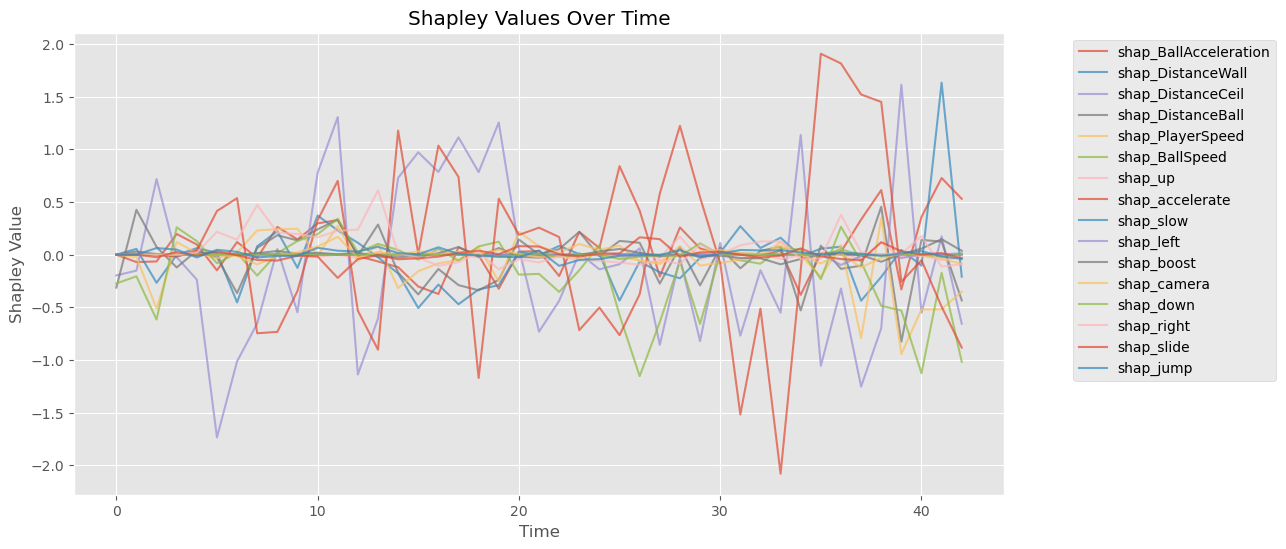

In [877]:
# Call the function to plot
plot_shap_values_over_time(shap_values_df_sim)

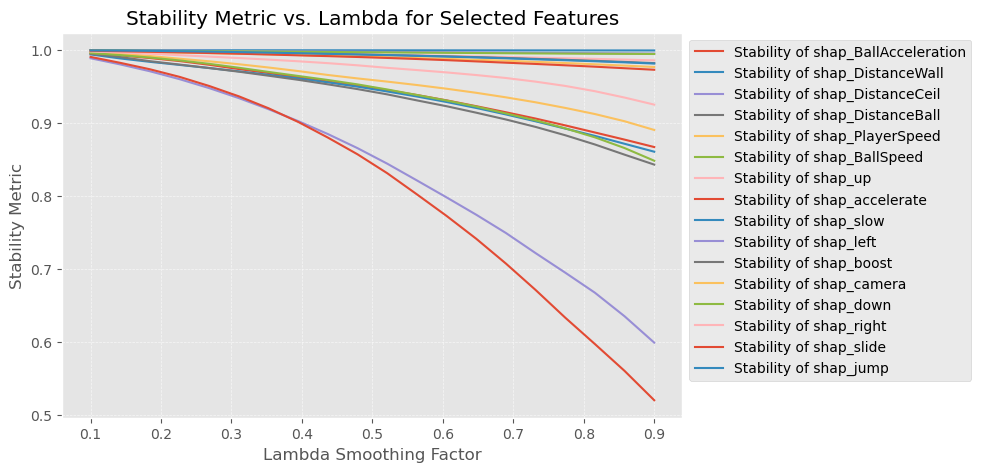

In [878]:
# Define the features to analyze
feature_names = shap_values_df_sim.columns

# Define lambda values to test (from 0.1 to 0.9)
lambda_values = np.linspace(0.1, 0.9, 20)

# Compute stability metric for each lambda value and each feature
stability_scores = {feature: [] for feature in feature_names}

for l in lambda_values:
    stability_metric = compute_stability_metric(shap_values_df_sim, model_performance, lambda_smoothing=l)
    for feature in feature_names:
        stability_scores[feature].append(stability_metric[feature])

# Plot results
plt.figure(figsize=(8, 5))

for feature in feature_names:
    plt.plot(lambda_values, stability_scores[feature], linestyle='-', label=f"Stability of {feature}")

# Customize plot appearance
plt.xlabel("Lambda Smoothing Factor")
plt.ylabel("Stability Metric")
plt.title("Stability Metric vs. Lambda for Selected Features")
plt.legend(bbox_to_anchor=(1, 1))
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
plt.show()

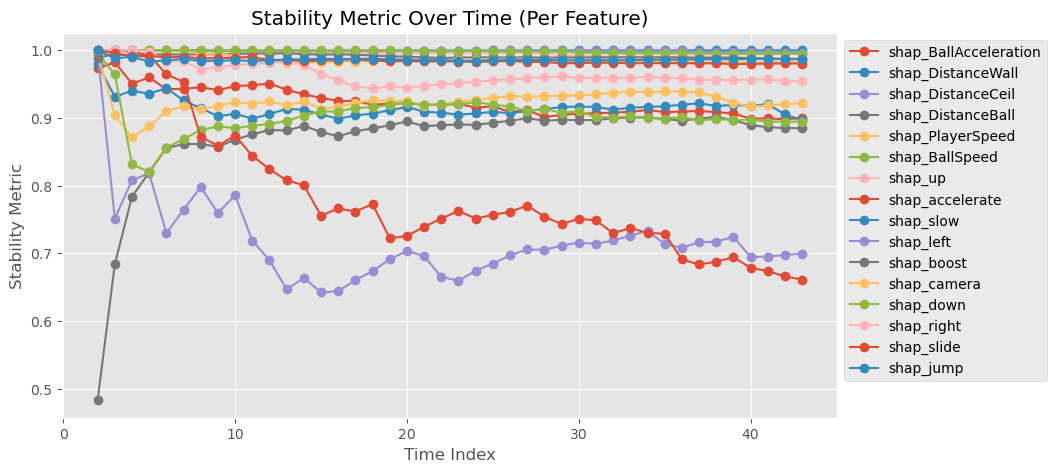

In [879]:
# Extract time index
time_index = results_sim['interval_index']

# Align time index (excluding first value since stability is not defined for t=0)
time_index_trimmed = time_index[1:]

stability_values_SH = {feature: [] for feature in shap_values_df_sim.columns}

for t in range(1, len(time_index)):
    SH_subset = shap_values_df_sim.iloc[:t+1, :]
    
    stability_result = compute_stability_metric(SH_subset, model_performance=None, standardize=False)
    
    for feature, value in zip(shap_values_df_sim.columns, stability_result):
        stability_values_SH[feature].append(value)

# Plot each feature separately
plt.figure(figsize=(10, 5))
for feature, values in stability_values_SH.items():
    plt.plot(time_index_trimmed, values, marker='o', linestyle='-', label=feature)

plt.xlabel("Time Index")
plt.ylabel("Stability Metric")
plt.title("Stability Metric Over Time (Per Feature)")
plt.legend(bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

In [880]:
# 1. Extract FEature Importance values (all columns except 'time_index' and 'roc_auc')
FI_df_sim = results_sim_FI.drop(columns=['interval_index', 'model performance'])

# 2. Extract model performance
model_performance_FI = results_sim_FI['model performance']

# 3. Call compute_stability_metric function
stability_metric_FI = compute_stability_metric(FI_df_sim, model_performance=None, standardize=False)

# 4. Display the stability metric for each feature
print(stability_metric_FI)

FI_BallAcceleration    0.996208
FI_DistanceWall        0.999410
FI_DistanceCeil        0.996264
FI_DistanceBall        0.996103
FI_PlayerSpeed         0.995497
FI_BallSpeed           0.996291
FI_up                  0.999062
FI_accelerate          0.992881
FI_slow                0.999618
FI_left                0.998955
FI_boost               0.998004
FI_camera              0.999010
FI_down                0.997343
FI_right               0.998429
FI_slide               0.997781
FI_jump                0.998868
dtype: float64


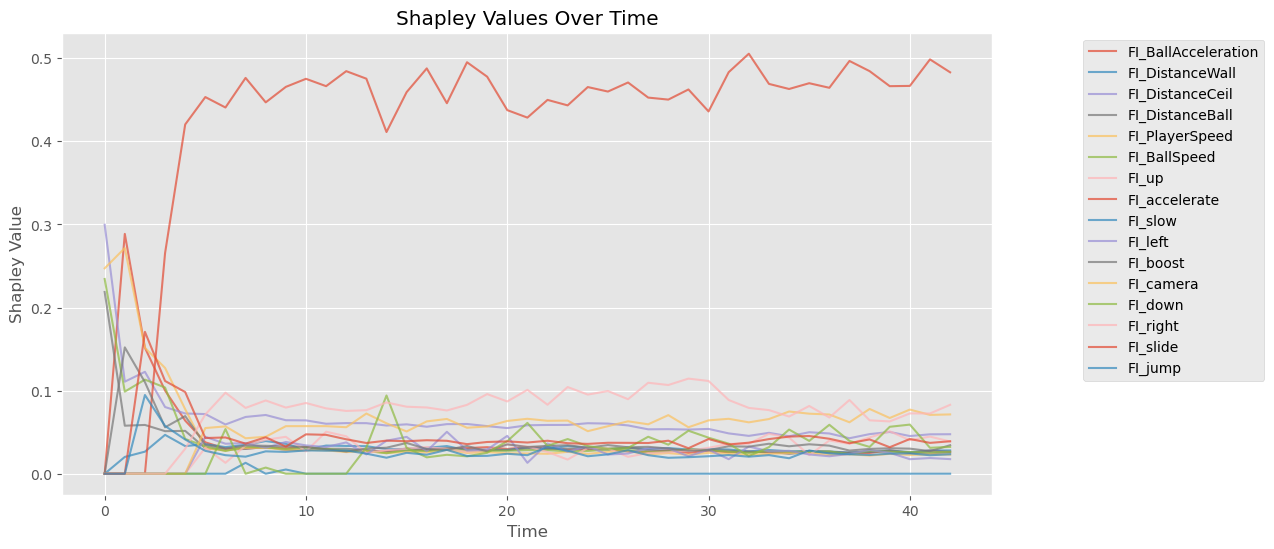

In [881]:
# Call the function to plot
plot_shap_values_over_time(FI_df_sim)

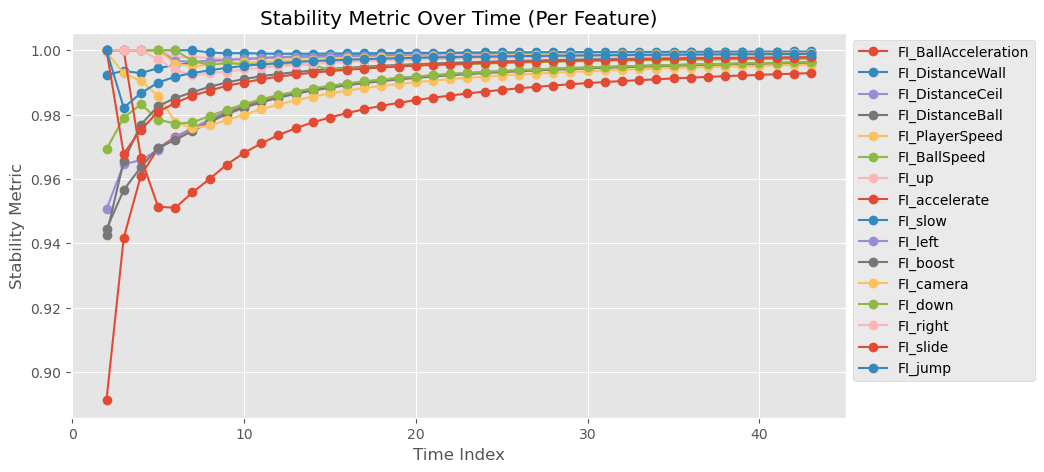

In [882]:
stability_values = {feature: [] for feature in FI_df_sim.columns}

for t in range(1, len(time_index)):
    FI_subset = FI_df_sim.iloc[:t+1, :]
    
    stability_result = compute_stability_metric(FI_subset, model_performance=None, standardize=False)
    
    for feature, value in zip(FI_df_sim.columns, stability_result):
        stability_values[feature].append(value)

# Plot each feature separately
plt.figure(figsize=(10, 5))
for feature, values in stability_values.items():
    plt.plot(time_index_trimmed, values, marker='o', linestyle='-', label=feature)

plt.xlabel("Time Index")
plt.ylabel("Stability Metric")
plt.title("Stability Metric Over Time (Per Feature)")
plt.legend(bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

#### With Performance-based Weighting

In [883]:
# 1. Extract SHAP values (all columns except 'time_index' and 'roc_auc')
shap_values_df_sim = results_sim.drop(columns=['interval_index', 'model performance'])

# 2. Extract model performance
model_performance = results_sim['model performance']

# 3. Call compute_stability_metric function
stability_metric = compute_stability_metric(shap_values_df_sim, model_performance, standardize=False)

# 4. Display the stability metric for each feature
print(stability_metric)

shap_BallAcceleration    0.912756
shap_DistanceWall        0.909573
shap_DistanceCeil        0.742777
shap_DistanceBall        0.902428
shap_PlayerSpeed         0.933677
shap_BallSpeed           0.910881
shap_up                  0.990433
shap_accelerate          0.698262
shap_slow                0.999777
shap_left                0.996556
shap_boost               0.989071
shap_camera              0.985143
shap_down                0.995788
shap_right               0.960711
shap_slide               0.982443
shap_jump                0.988576
dtype: float64


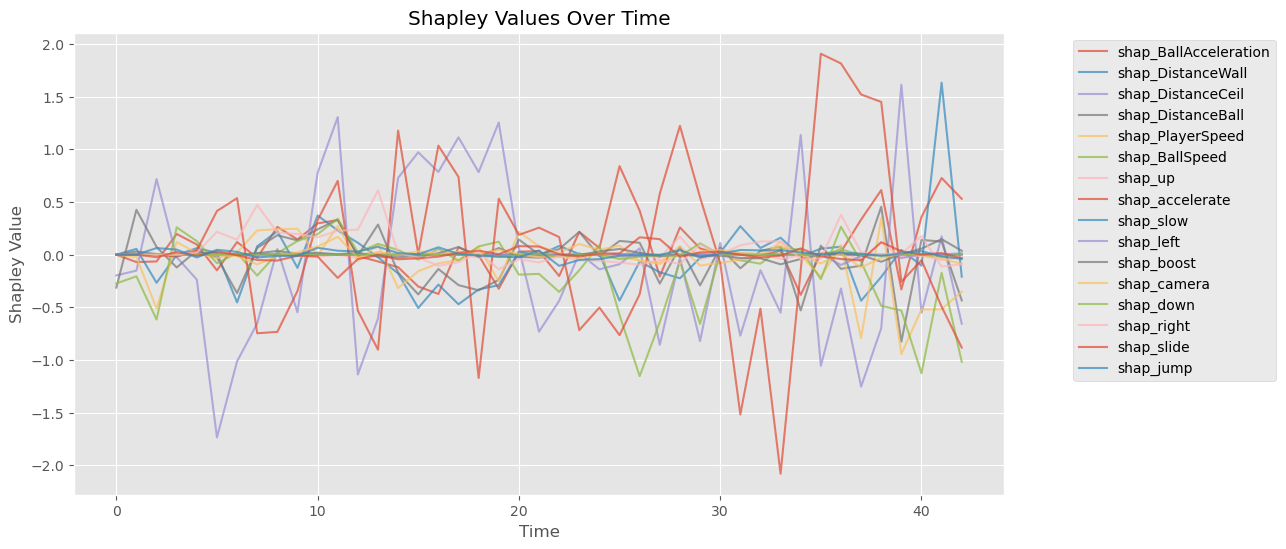

In [884]:
# Call the function to plot
plot_shap_values_over_time(shap_values_df_sim)

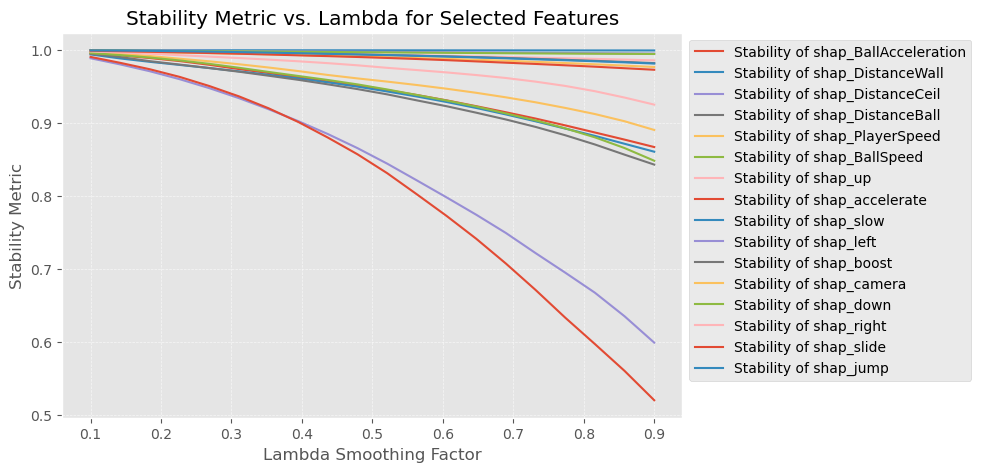

In [885]:
# Define the features to analyze
feature_names = shap_values_df_sim.columns 

# Define lambda values to test (from 0.1 to 0.9)
lambda_values = np.linspace(0.1, 0.9, 20)

# Compute stability metric for each lambda value and each feature
stability_scores = {feature: [] for feature in feature_names}

for l in lambda_values:
    stability_metric = compute_stability_metric(shap_values_df_sim, model_performance, lambda_smoothing=l)
    for feature in feature_names:
        stability_scores[feature].append(stability_metric[feature])

# Plot results
plt.figure(figsize=(8, 5))

for feature in feature_names:
    plt.plot(lambda_values, stability_scores[feature], linestyle='-', label=f"Stability of {feature}")

# Customize plot appearance
plt.xlabel("Lambda Smoothing Factor")
plt.ylabel("Stability Metric")
plt.title("Stability Metric vs. Lambda for Selected Features")
plt.legend(bbox_to_anchor=(1, 1))
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
plt.show()

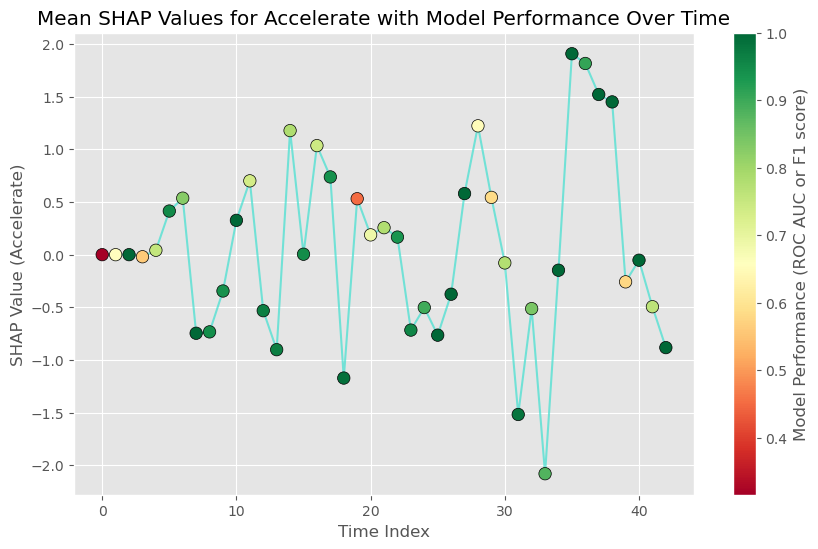

In [886]:
# Extract SHAP values for 'shap_jitter' and model performance
shap_values_jitter = shap_values_df_sim['shap_accelerate']
roc_auc_values = model_performance

# Create a figure
fig, ax = plt.subplots(figsize=(10, 6))

# Create a colormap to color the markers by model performance values
scatter = ax.plot(range(len(shap_values_jitter)), shap_values_jitter, color='turquoise', marker='o', markersize=6, label='SHAP accelerate', alpha=0.7)

# Use a scatter plot with colormap to color the markers by model performance
sc = ax.scatter(range(len(roc_auc_values)), shap_values_jitter, c=roc_auc_values, cmap='RdYlGn', edgecolors='k', s=80, zorder=5)

# Set the labels
ax.set_xlabel('Time Index')
ax.set_ylabel('SHAP Value (Accelerate)')

# Add a colorbar for the model performance values
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Model Performance (ROC AUC or F1 score)')

# Add title
plt.title('Mean SHAP Values for Accelerate with Model Performance Over Time')

# Show the plot
plt.grid(True)
plt.show()

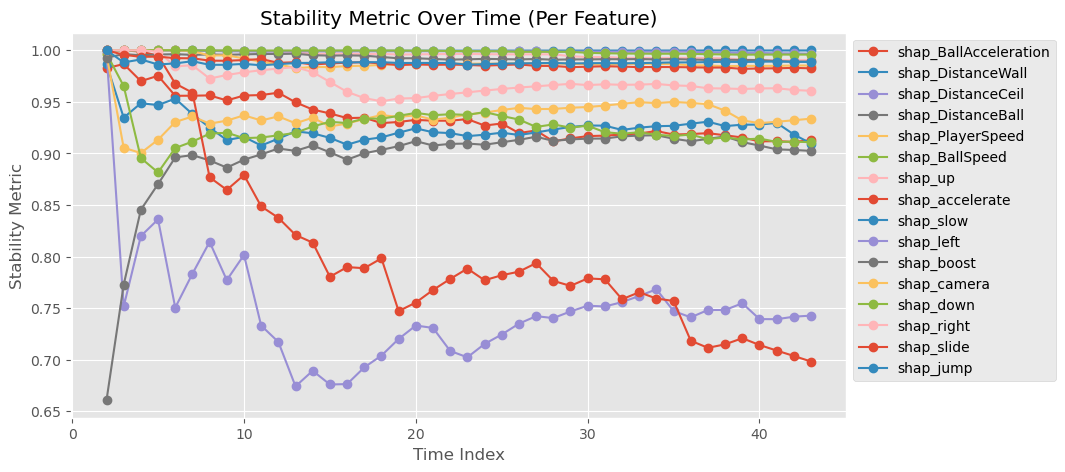

In [887]:
stability_values_SH = {feature: [] for feature in shap_values_df_sim.columns}

for t in range(1, len(time_index)):
    SH_subset = shap_values_df_sim.iloc[:t+1, :]
    
    stability_result = compute_stability_metric(SH_subset, model_performance.iloc[:t+1], standardize=False)
    
    for feature, value in zip(shap_values_df_sim.columns, stability_result):
        stability_values_SH[feature].append(value)

# Plot each feature separately
plt.figure(figsize=(10, 5))
for feature, values in stability_values_SH.items():
    plt.plot(time_index_trimmed, values, marker='o', linestyle='-', label=feature)

plt.xlabel("Time Index")
plt.ylabel("Stability Metric")
plt.title("Stability Metric Over Time (Per Feature)")
plt.legend(bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

In [888]:
# 1. Extract Feature Importance values (all columns except 'time_index' and 'roc_auc')
FI_df_sim = results_sim_FI.drop(columns=['interval_index', 'model performance'])

# 2. Extractmodel performance
model_performance_FI = results_sim_FI['model performance']

# 3. Call compute_stability_metric function
stability_metric_FI = compute_stability_metric(FI_df_sim, model_performance=model_performance_FI, standardize=False)

# 4. Display the stability metric for each feature
print(stability_metric_FI)

FI_BallAcceleration    0.997205
FI_DistanceWall        0.999570
FI_DistanceCeil        0.997199
FI_DistanceBall        0.996941
FI_PlayerSpeed         0.996065
FI_BallSpeed           0.996980
FI_up                  0.999127
FI_accelerate          0.994668
FI_slow                0.999642
FI_left                0.999065
FI_boost               0.998513
FI_camera              0.999094
FI_down                0.997708
FI_right               0.998627
FI_slide               0.997931
FI_jump                0.998933
dtype: float64


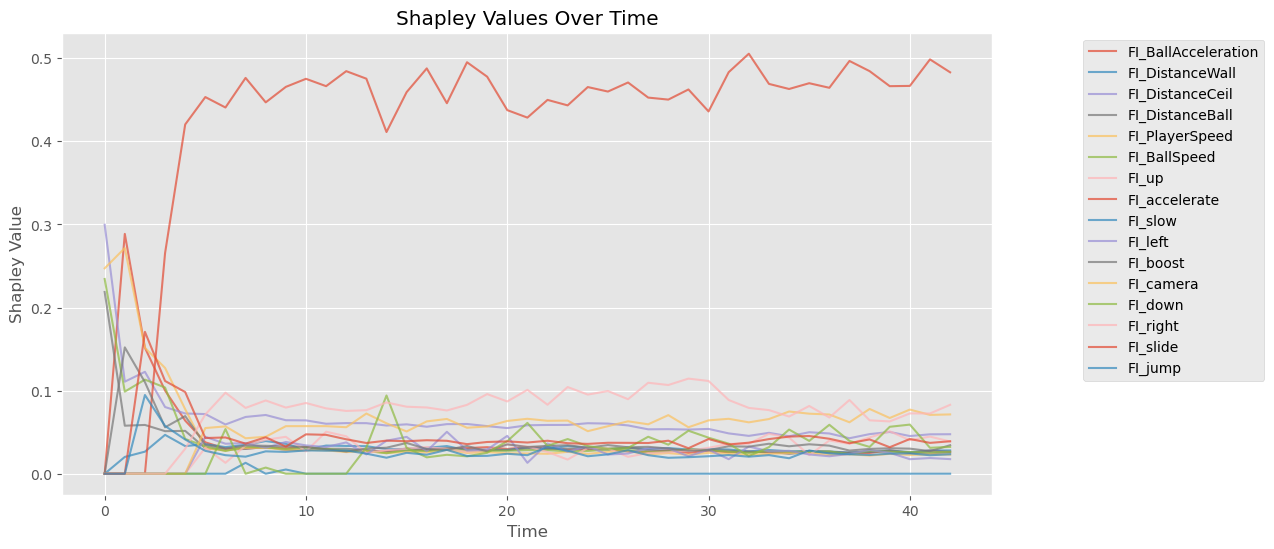

In [889]:
# Call the function to plot
plot_shap_values_over_time(FI_df_sim)

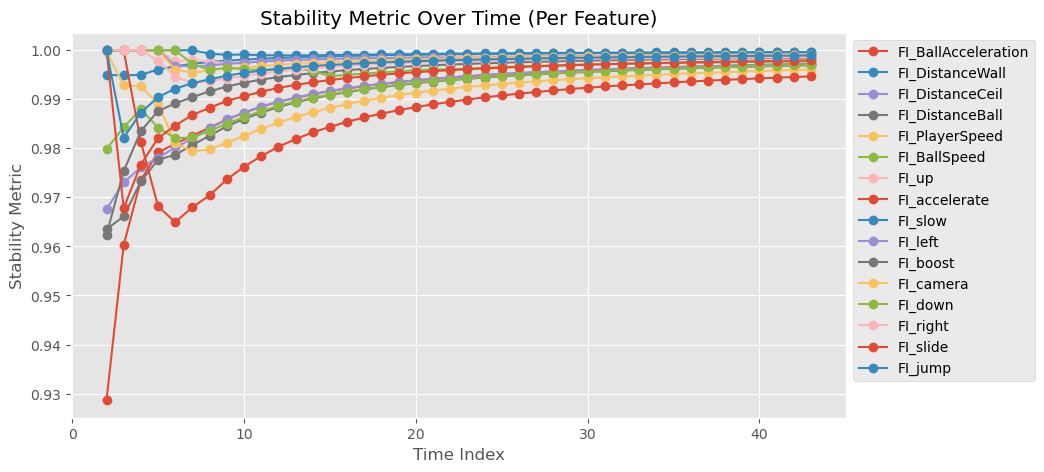

In [890]:
stability_values = {feature: [] for feature in FI_df_sim.columns}

for t in range(1, len(time_index)):
    FI_subset = FI_df_sim.iloc[:t+1, :]
    
    stability_result = compute_stability_metric(FI_subset, model_performance=model_performance_FI.iloc[:t+1], standardize=False)
    
    for feature, value in zip(FI_df_sim.columns, stability_result):
        stability_values[feature].append(value)

# Plot each feature separately
plt.figure(figsize=(10, 5))
for feature, values in stability_values.items():
    plt.plot(time_index_trimmed, values, marker='o', linestyle='-', label=feature)

plt.xlabel("Time Index")
plt.ylabel("Stability Metric")
plt.title("Stability Metric Over Time (Per Feature)")
plt.legend(bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

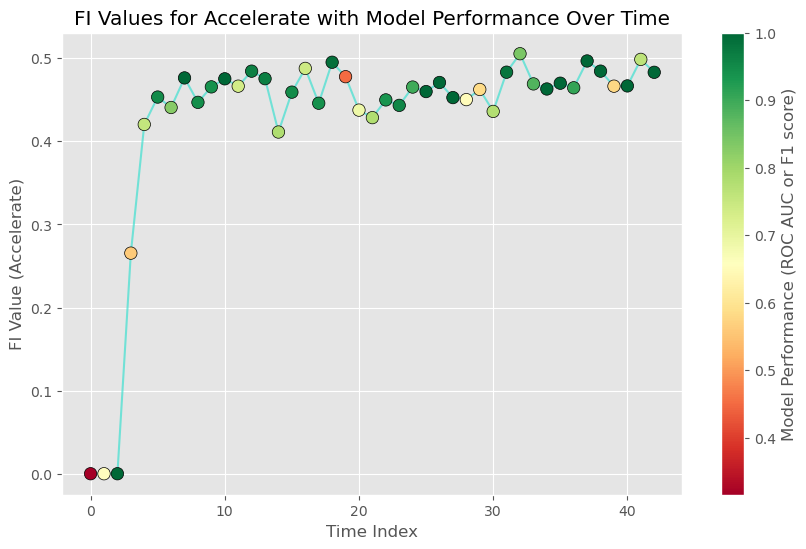

In [891]:
# Extract Feature Importance values for 'shap_jitter' and model performance
FI_jitter = FI_df_sim['FI_accelerate']
roc_auc_values = model_performance_FI

# Create a figure
fig, ax = plt.subplots(figsize=(10, 6))

# Create a colormap to color the markers by model performance values
scatter = ax.plot(range(len(FI_jitter)), FI_jitter, color='turquoise', marker='o', markersize=6, label='FI accelerate', alpha=0.7)

# Use a scatter plot with colormap to color the markers by model performance
sc = ax.scatter(range(len(roc_auc_values)), FI_jitter, c=roc_auc_values, cmap='RdYlGn', edgecolors='k', s=80, zorder=5)

# Set the labels
ax.set_xlabel('Time Index')
ax.set_ylabel('FI Value (Accelerate)')

# Add a colorbar for the model performance values
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Model Performance (ROC AUC or F1 score)')

# Add title
plt.title('FI Values for Accelerate with Model Performance Over Time')

# Show the plot
plt.grid(True)
plt.show()

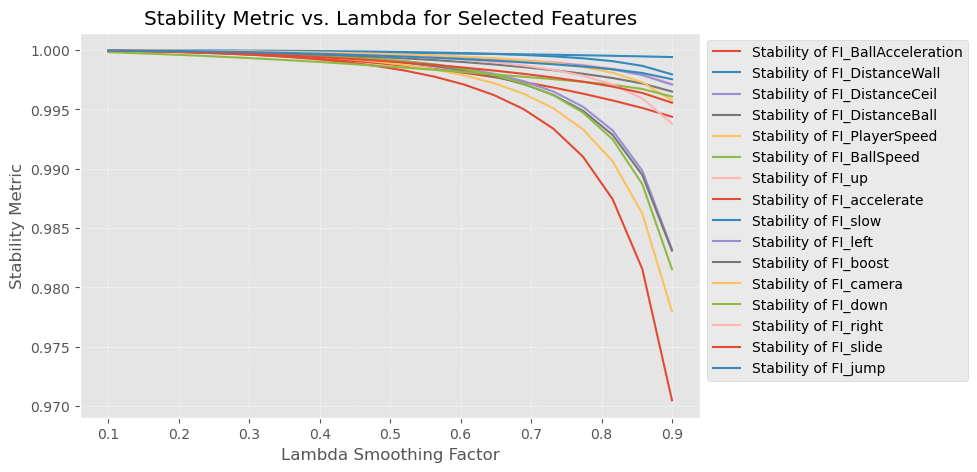

In [892]:
# Define the features to analyze
feature_names = FI_df_sim.columns

# Define lambda values to test (from 0.1 to 0.9)
lambda_values = np.linspace(0.1, 0.9, 20)

# Compute stability metric for each lambda value and each feature
stability_scores_FI = {feature: [] for feature in feature_names}

for l in lambda_values:
    stability_metric_FI = compute_stability_metric(FI_df_sim, model_performance_FI, lambda_smoothing=l)
    for feature in feature_names:
        stability_scores_FI[feature].append(stability_metric_FI[feature])

# Plot results
plt.figure(figsize=(8, 5))

for feature in feature_names:
    plt.plot(lambda_values, stability_scores_FI[feature], linestyle='-', label=f"Stability of {feature}")

# Customize plot appearance
plt.xlabel("Lambda Smoothing Factor")
plt.ylabel("Stability Metric")
plt.title("Stability Metric vs. Lambda for Selected Features")
plt.legend(bbox_to_anchor=(1, 1))
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
plt.show()

## Predictive Maintenance Dataset

### Loading Data and Loop Through the Intervals

In [893]:
df = pd.read_csv("...",
                 sep=',')
print(df.shape)

(10000, 14)


In [894]:
df = df.drop(['UDI', 'Product ID'], axis=1)

In [895]:
df = df.drop(['RNF', 'OSF', 'PWF', 'HDF', 'TWF'], axis=1)

In [896]:
df.head()

Type  Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0    M                298.1                    308.6                    1551   
1    L                298.2                    308.7                    1408   
2    L                298.1                    308.5                    1498   
3    L                298.2                    308.6                    1433   
4    L                298.2                    308.7                    1408   

   Torque [Nm]  Tool wear [min]  Machine failure  
0         42.8                0                0  
1         46.3                3                0  
2         49.4                5                0  
3         39.5                7                0  
4         40.0                9                0

In [897]:
df['Type'].value_counts()

Type
L    6000
M    2997
H    1003
Name: count, dtype: int64

In [898]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply the LabelEncoder to the "Type" column
df['Type'] = label_encoder.fit_transform(df['Type'])

In [899]:
df.head()

Type  Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0     2                298.1                    308.6                    1551   
1     1                298.2                    308.7                    1408   
2     1                298.1                    308.5                    1498   
3     1                298.2                    308.6                    1433   
4     1                298.2                    308.7                    1408   

   Torque [Nm]  Tool wear [min]  Machine failure  
0         42.8                0                0  
1         46.3                3                0  
2         49.4                5                0  
3         39.5                7                0  
4         40.0                9                0

In [900]:
df.rename(columns={
    'Type': 'Type',
    'Air temperature [K]': 'AirTemperature_K',
    'Process temperature [K]': 'ProcessTemperature_K',
    'Rotational speed [rpm]': 'RotationalSpeed_rpm',
    'Torque [Nm]': 'Torque_Nm',
    'Tool wear [min]': 'ToolWear_min',
    'Machine failure': 'MachineFailure'
}, inplace=True)

In [901]:
df['MachineFailure'].value_counts()

MachineFailure
0    9661
1     339
Name: count, dtype: int64

In [902]:
# Get basic statistics for the 'Tool wear [min]' column
tool_wear_stats = df['ToolWear_min'].describe()

# Display the statistics
print(tool_wear_stats)

count    10000.000000
mean       107.951000
std         63.654147
min          0.000000
25%         53.000000
50%        108.000000
75%        162.000000
max        253.000000
Name: ToolWear_min, dtype: float64


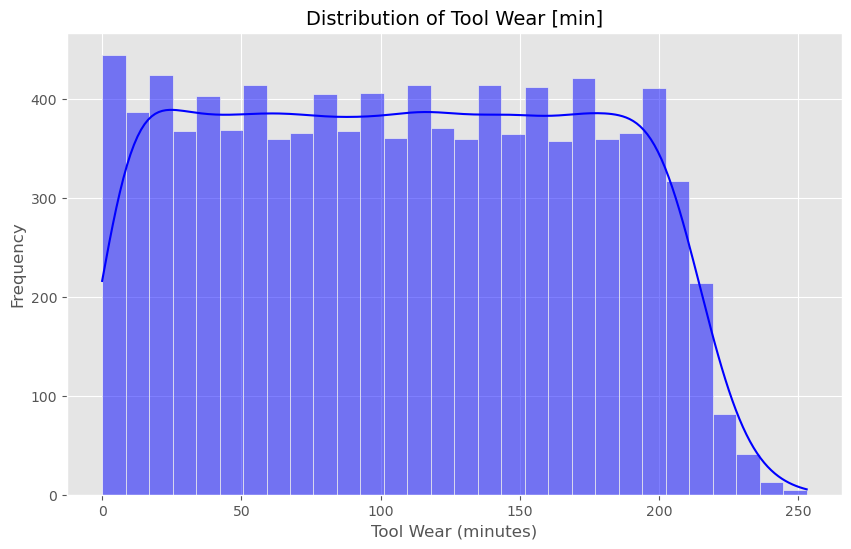

In [903]:
# Create the figure and axis
plt.figure(figsize=(10, 6))

# Histogram with KDE
sns.histplot(df['ToolWear_min'], bins=30, kde=True, color='blue')

# Add labels and title
plt.xlabel('Tool Wear (minutes)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Tool Wear [min]', fontsize=14)

# Show the plot
plt.show()

In [904]:
# Define interval size (30 minutes)
interval_size = 30

# Sort dataset by Tool wear [min] to ensure ordered intervals
df = df.sort_values(by="ToolWear_min").reset_index(drop=True)

# Create intervals by grouping data
df['interval'] = df["ToolWear_min"] // interval_size  # Assign interval index
intervals = [group for _, group in df.groupby('interval')]

In [905]:
# Initialize results 
feature_names = df.drop(['MachineFailure', 'interval'], axis=1).columns  # Drop interval from features
results_sim = pd.DataFrame(columns=["interval_index", "model performance"] + [f"shap_{feature}" for feature in feature_names])
results_sim_FI = pd.DataFrame(columns=["interval_index", "model performance"] + [f"FI_{feature}" for feature in feature_names])

# Initialize training with the first interval
train_df = intervals[0]

# Loop through intervals
for interval_index in range(1, len(intervals)):
    test_df = intervals[interval_index] 

    # Train XGBoost model
    model = XGBClassifier(random_state=2025, eval_metric="logloss", objective='binary:logistic')
    model.fit(train_df.drop(['MachineFailure', 'interval'], axis=1), train_df['MachineFailure'])

    # Remove NaN rows in 'MachineFailure' if any
    test_df = test_df.dropna(subset=['MachineFailure'])
    
    # Ensure there are both classes
    if len(test_df['MachineFailure'].unique()) > 1:
        y_pred_proba = model.predict_proba(test_df.drop(['MachineFailure', 'interval'], axis=1))[:, 1]
        roc_auc = roc_auc_score(test_df['MachineFailure'], y_pred_proba)
    else:
        roc_auc = np.nan  # Assign NaN if only one class is present
    
    # If AUC is NaN, use F1 score instead
    if np.isnan(roc_auc):
        y_pred = model.predict(test_df.drop(['MachineFailure', 'interval'], axis=1))
        f1 = f1_score(test_df['MachineFailure'], y_pred, zero_division=0)
    
        # If F1 is still NaN or 0, fall back to accuracy score
        if np.isnan(f1) or f1 == 0:
            accuracy = accuracy_score(test_df['MachineFailure'], y_pred)
            roc_auc = accuracy  # Use accuracy as fallback
        else:
            roc_auc = f1  # Replace AUC with F1 score

    # Compute SHAP values
    explainer = shap.Explainer(model, train_df.drop(['MachineFailure', 'interval'], axis=1))
    shap_values = explainer(test_df.drop(['MachineFailure', 'interval'], axis=1), check_additivity=False)

    # Extract SHAP values
    shap_values_flat = shap_values.values.mean(axis=0)

    # Compute Feature Importance
    feature_importance_values = model.feature_importances_

    # Store results
    new_entry = pd.DataFrame([[interval_index, roc_auc] + shap_values_flat.tolist()], 
                             columns=results_sim.columns)
    results_sim = pd.concat([results_sim, new_entry], ignore_index=True)

    new_entry_FI = pd.DataFrame([[interval_index, roc_auc] + feature_importance_values.tolist()], 
                                columns=results_sim_FI.columns)
    results_sim_FI = pd.concat([results_sim_FI, new_entry_FI], ignore_index=True)

    # Update training set by adding the current test set
    train_df = pd.concat([train_df, test_df])

    print(f"Iteration {interval_index}: train_size={len(train_df)}, test_size={len(test_df)}")

# Display results
print(results_sim)
print(results_sim_FI)

Iteration 1: train_size=2810, test_size=1376
Iteration 2: train_size=4167, test_size=1357
Iteration 3: train_size=5547, test_size=1380
Iteration 4: train_size=6910, test_size=1363
Iteration 5: train_size=8280, test_size=1370
Iteration 6: train_size=9606, test_size=1326
Iteration 7: train_size=9986, test_size=380
Iteration 8: train_size=10000, test_size=14
  interval_index  model performance  shap_Type  shap_AirTemperature_K  \
0              1           0.952447   0.011196              -0.248979   
1              2           0.984227  -0.004306               0.096218   
2              3           0.957486   0.013965               0.142596   
3              4           0.973373   0.015073               0.064399   
4              5           0.981486  -0.008006               0.121230   
5              6           0.727365  -0.001437               0.093935   
6              7           0.711496   0.071811              -0.056539   
7              8           0.975000  -0.064330            

### Stability Metric Calculation

#### Wihtout Performance-based Weighting

In [906]:
# 1. Extract SHAP values (all columns except 'time_index' and 'roc_auc')
shap_values_df_sim = results_sim.drop(columns=['interval_index', 'model performance'])

# 2. Extract model performance
model_performance = results_sim['model performance']

# 3. Call compute_stability_metric function
stability_metric = compute_stability_metric(shap_values_df_sim, model_performance=None, standardize=False)

# 4. Display the stability metric for each feature
print(stability_metric)

shap_Type                    0.984101
shap_AirTemperature_K        0.897153
shap_ProcessTemperature_K    0.932237
shap_RotationalSpeed_rpm     0.961994
shap_Torque_Nm               0.938367
shap_ToolWear_min            0.455330
dtype: float64


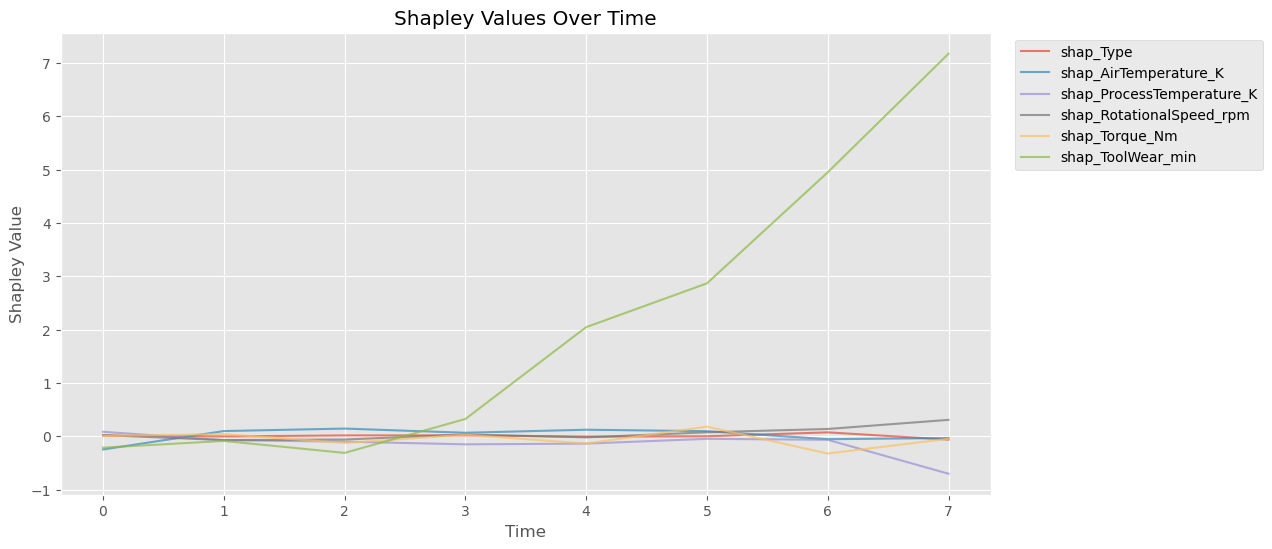

In [907]:
# Call the function to plot
plot_shap_values_over_time(shap_values_df_sim)

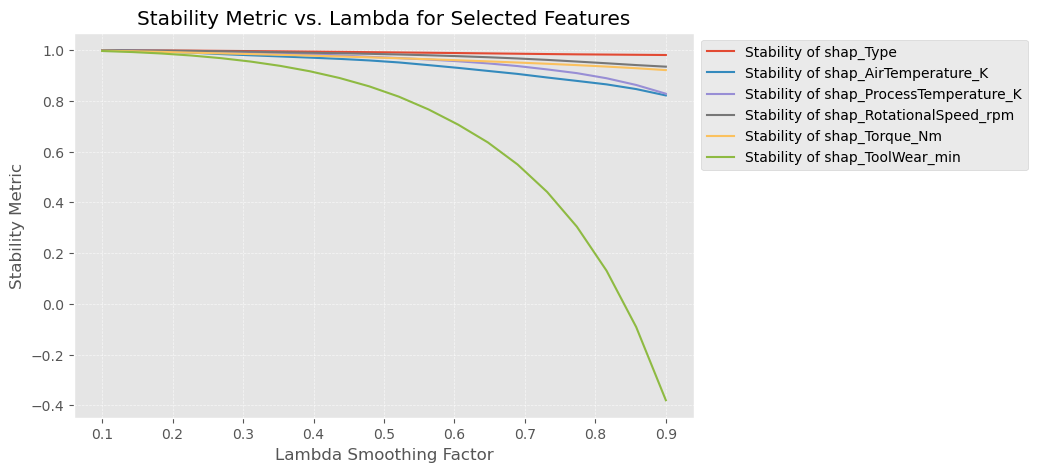

In [908]:
# Define the features to analyze
feature_names = shap_values_df_sim.columns

# Define lambda values to test (from 0.1 to 0.9)
lambda_values = np.linspace(0.1, 0.9, 20)

# Compute stability metric for each lambda value and each feature
stability_scores = {feature: [] for feature in feature_names}

for l in lambda_values:
    stability_metric = compute_stability_metric(shap_values_df_sim, model_performance, lambda_smoothing=l)
    for feature in feature_names:
        stability_scores[feature].append(stability_metric[feature])

# Plot results
plt.figure(figsize=(8, 5))

for feature in feature_names:
    plt.plot(lambda_values, stability_scores[feature], linestyle='-', label=f"Stability of {feature}")

# Customize plot appearance
plt.xlabel("Lambda Smoothing Factor")
plt.ylabel("Stability Metric")
plt.title("Stability Metric vs. Lambda for Selected Features")
plt.legend(bbox_to_anchor=(1, 1))
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
plt.show()

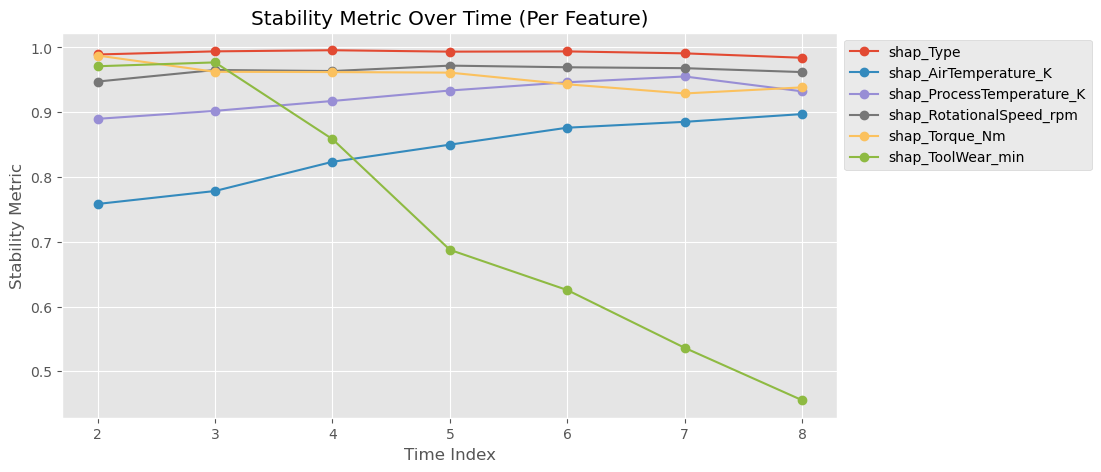

In [909]:
# Extract time index
time_index = results_sim['interval_index']

# Align time index (excluding first value since stability is not defined for t=0)
time_index_trimmed = time_index[1:]

stability_values_SH = {feature: [] for feature in shap_values_df_sim.columns}

for t in range(1, len(time_index)):
    SH_subset = shap_values_df_sim.iloc[:t+1, :]
    
    stability_result = compute_stability_metric(SH_subset, model_performance=None, standardize=False)
    
    for feature, value in zip(shap_values_df_sim.columns, stability_result):
        stability_values_SH[feature].append(value)

# Plot each feature separately
plt.figure(figsize=(10, 5))
for feature, values in stability_values_SH.items():
    plt.plot(time_index_trimmed, values, marker='o', linestyle='-', label=feature)

plt.xlabel("Time Index")
plt.ylabel("Stability Metric")
plt.title("Stability Metric Over Time (Per Feature)")
plt.legend(bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

In [910]:
# 1. Extract Feature Importance values (all columns except 'time_index' and 'roc_auc')
FI_df_sim = results_sim_FI.drop(columns=['interval_index', 'model performance'])

# 2. Extract (model performance
model_performance_FI = results_sim_FI['model performance']

# 3. Call compute_stability_metric function
stability_metric_FI = compute_stability_metric(FI_df_sim, model_performance=None, standardize=False)

# 4. Display the stability metric for each feature
print(stability_metric_FI)

FI_Type                    0.996913
FI_AirTemperature_K        0.998764
FI_ProcessTemperature_K    0.999217
FI_RotationalSpeed_rpm     0.996266
FI_Torque_Nm               0.998051
FI_ToolWear_min            0.993369
dtype: float64


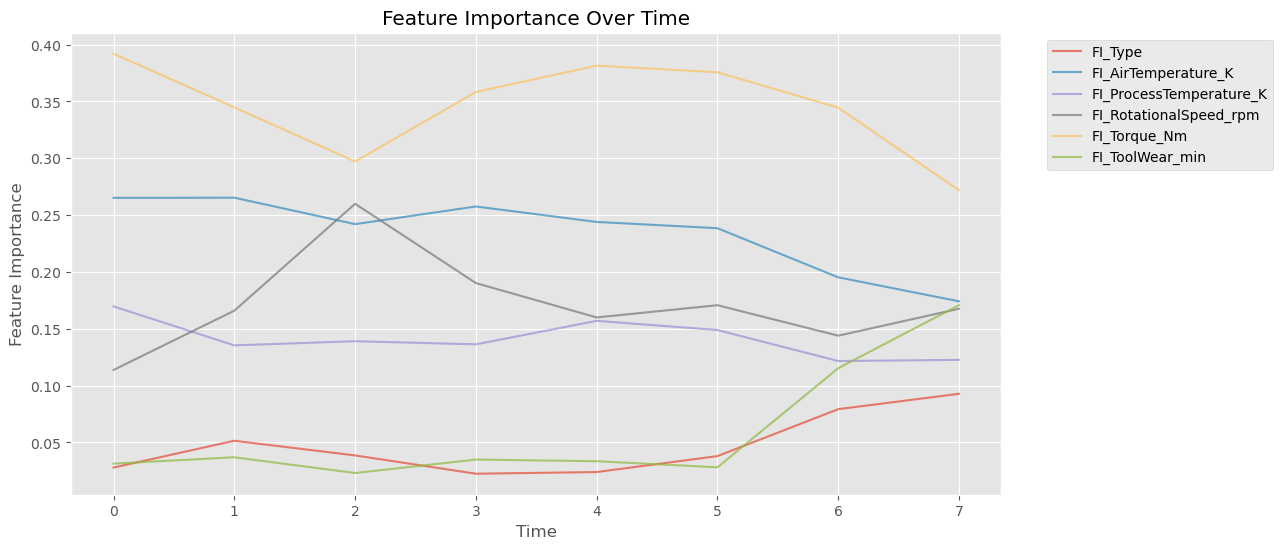

In [911]:
# Call the function to plot
plot_FI_over_time(FI_df_sim)

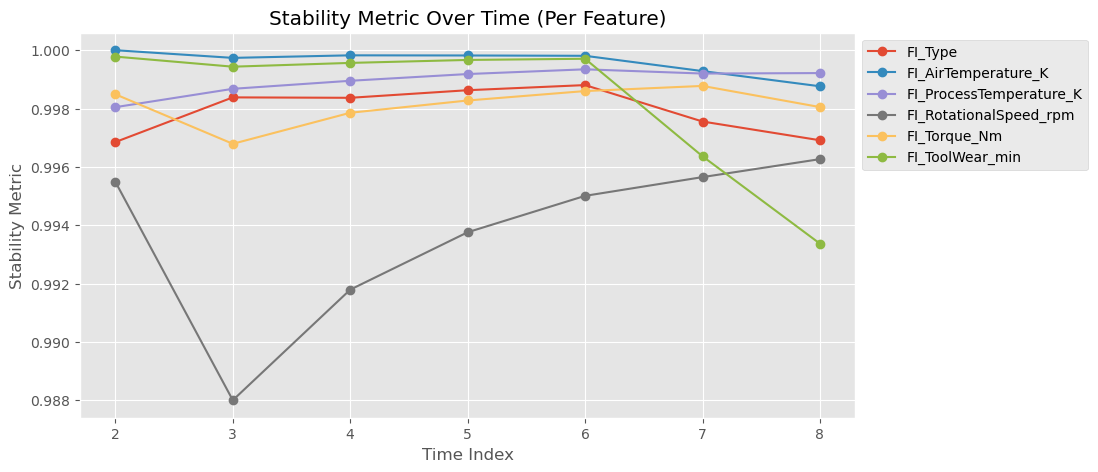

In [912]:
stability_values = {feature: [] for feature in FI_df_sim.columns}

for t in range(1, len(time_index)):
    FI_subset = FI_df_sim.iloc[:t+1, :]
    
    stability_result = compute_stability_metric(FI_subset, model_performance=None, standardize=False)
    
    for feature, value in zip(FI_df_sim.columns, stability_result):
        stability_values[feature].append(value)

# Plot each feature separately
plt.figure(figsize=(10, 5))
for feature, values in stability_values.items():
    plt.plot(time_index_trimmed, values, marker='o', linestyle='-', label=feature)

plt.xlabel("Time Index")
plt.ylabel("Stability Metric")
plt.title("Stability Metric Over Time (Per Feature)")
plt.legend(bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

#### With Performance-based Weighting

In [913]:
# 1. Extract SHAP values (all columns except 'time_index' and 'roc_auc')
shap_values_df_sim = results_sim.drop(columns=['interval_index', 'model performance'])

# 2. Extract model performance
model_performance = results_sim['model performance']

# 3. Call compute_stability_metric function
stability_metric = compute_stability_metric(shap_values_df_sim, model_performance, standardize=False)

# 4. Display the stability metric for each feature
print(stability_metric)

shap_Type                    0.985547
shap_AirTemperature_K        0.903158
shap_ProcessTemperature_K    0.934100
shap_RotationalSpeed_rpm     0.965830
shap_Torque_Nm               0.949917
shap_ToolWear_min            0.524570
dtype: float64


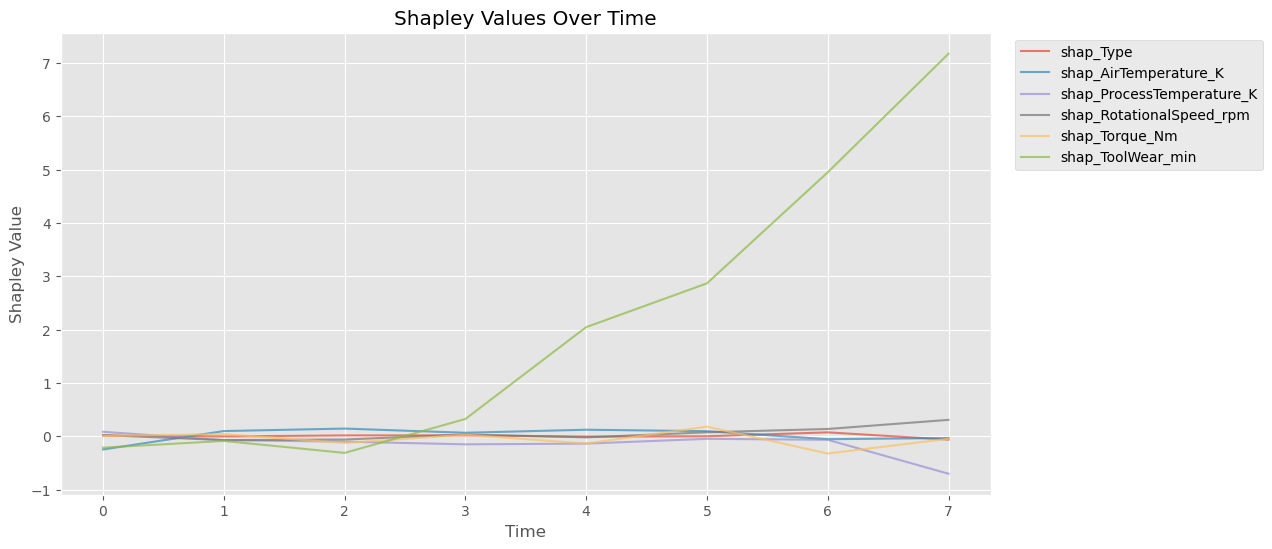

In [914]:
# Call the function to plot
plot_shap_values_over_time(shap_values_df_sim)

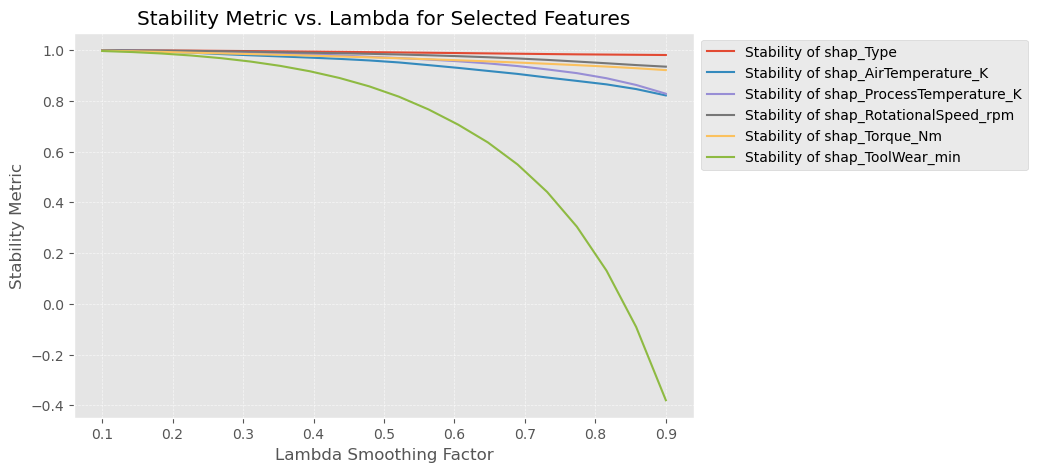

In [915]:
# Define the features to analyze
feature_names = shap_values_df_sim.columns 

# Define lambda values to test (from 0.1 to 0.9)
lambda_values = np.linspace(0.1, 0.9, 20)

# Compute stability metric for each lambda value and each feature
stability_scores = {feature: [] for feature in feature_names}

for l in lambda_values:
    stability_metric = compute_stability_metric(shap_values_df_sim, model_performance, lambda_smoothing=l)
    for feature in feature_names:
        stability_scores[feature].append(stability_metric[feature])

# Plot results
plt.figure(figsize=(8, 5))

for feature in feature_names:
    plt.plot(lambda_values, stability_scores[feature], linestyle='-', label=f"Stability of {feature}")

# Customize plot appearance
plt.xlabel("Lambda Smoothing Factor")
plt.ylabel("Stability Metric")
plt.title("Stability Metric vs. Lambda for Selected Features")
plt.legend(bbox_to_anchor=(1, 1))
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
plt.show()

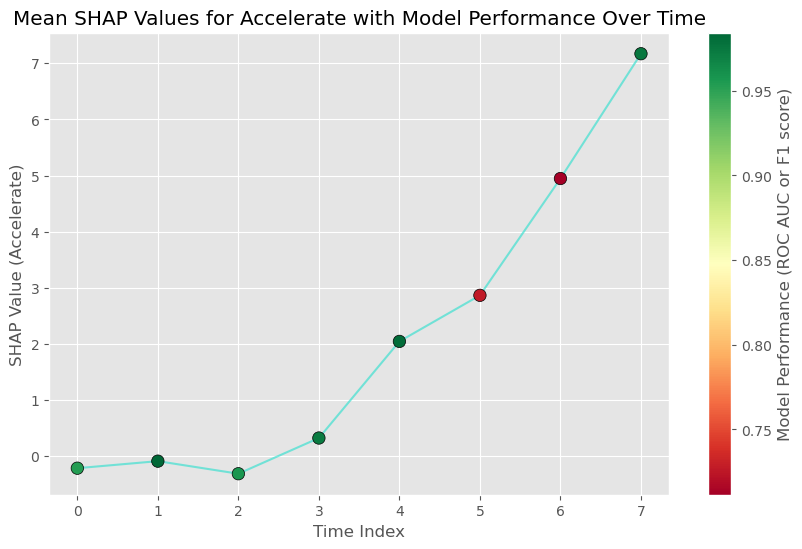

In [916]:
# Extract SHAP values for 'shap_jitter' and model performance
shap_values_jitter = shap_values_df_sim['shap_ToolWear_min']
roc_auc_values = model_performance

# Create a figure
fig, ax = plt.subplots(figsize=(10, 6))

# Create a colormap to color the markers by model performance values
scatter = ax.plot(range(len(shap_values_jitter)), shap_values_jitter, color='turquoise', marker='o', markersize=6, label='SHAP accelerate', alpha=0.7)

# Use a scatter plot with colormap to color the markers by model performance
sc = ax.scatter(range(len(roc_auc_values)), shap_values_jitter, c=roc_auc_values, cmap='RdYlGn', edgecolors='k', s=80, zorder=5)

# Set the labels
ax.set_xlabel('Time Index')
ax.set_ylabel('SHAP Value (Accelerate)')

# Add a colorbar for the model performance values
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Model Performance (ROC AUC or F1 score)')

# Add title
plt.title('Mean SHAP Values for Accelerate with Model Performance Over Time')

# Show the plot
plt.grid(True)
plt.show()

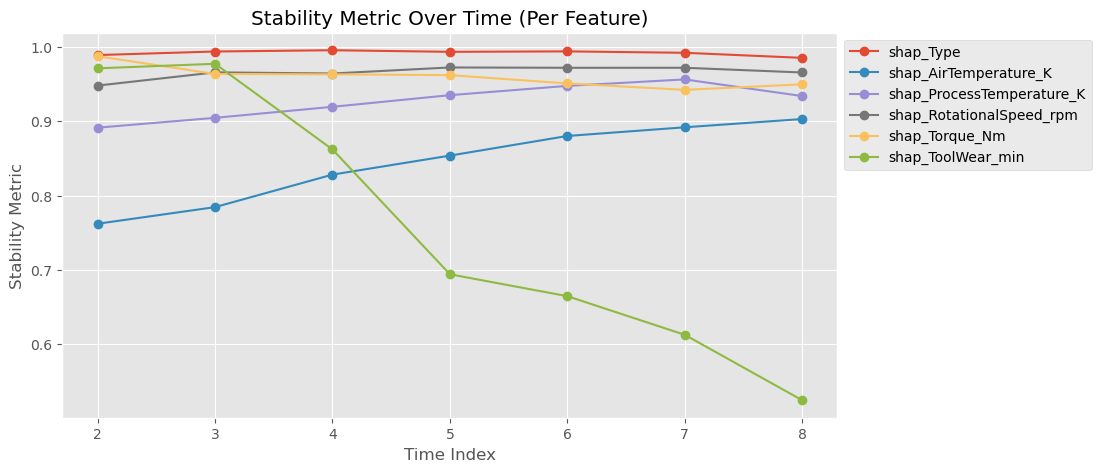

In [917]:
stability_values_SH = {feature: [] for feature in shap_values_df_sim.columns}

for t in range(1, len(time_index)):
    SH_subset = shap_values_df_sim.iloc[:t+1, :]
    
    stability_result = compute_stability_metric(SH_subset, model_performance.iloc[:t+1], standardize=False)
    
    for feature, value in zip(shap_values_df_sim.columns, stability_result):
        stability_values_SH[feature].append(value)

# Plot each feature separately
plt.figure(figsize=(10, 5))
for feature, values in stability_values_SH.items():
    plt.plot(time_index_trimmed, values, marker='o', linestyle='-', label=feature)

plt.xlabel("Time Index")
plt.ylabel("Stability Metric")
plt.title("Stability Metric Over Time (Per Feature)")
plt.legend(bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

In [918]:
# 1. Extract Feature Importance values (all columns except 'time_index' and 'roc_auc')
FI_df_sim = results_sim_FI.drop(columns=['interval_index', 'model performance'])

# 2. Extract model performance
model_performance_FI = results_sim_FI['model performance']

# 3. Call compute_stability_metric function
stability_metric_FI = compute_stability_metric(FI_df_sim, model_performance=model_performance_FI, standardize=False)

# 4. Display the stability metric for each feature
print(stability_metric_FI)

FI_Type                    0.997331
FI_AirTemperature_K        0.998930
FI_ProcessTemperature_K    0.999293
FI_RotationalSpeed_rpm     0.996445
FI_Torque_Nm               0.998126
FI_ToolWear_min            0.994308
dtype: float64


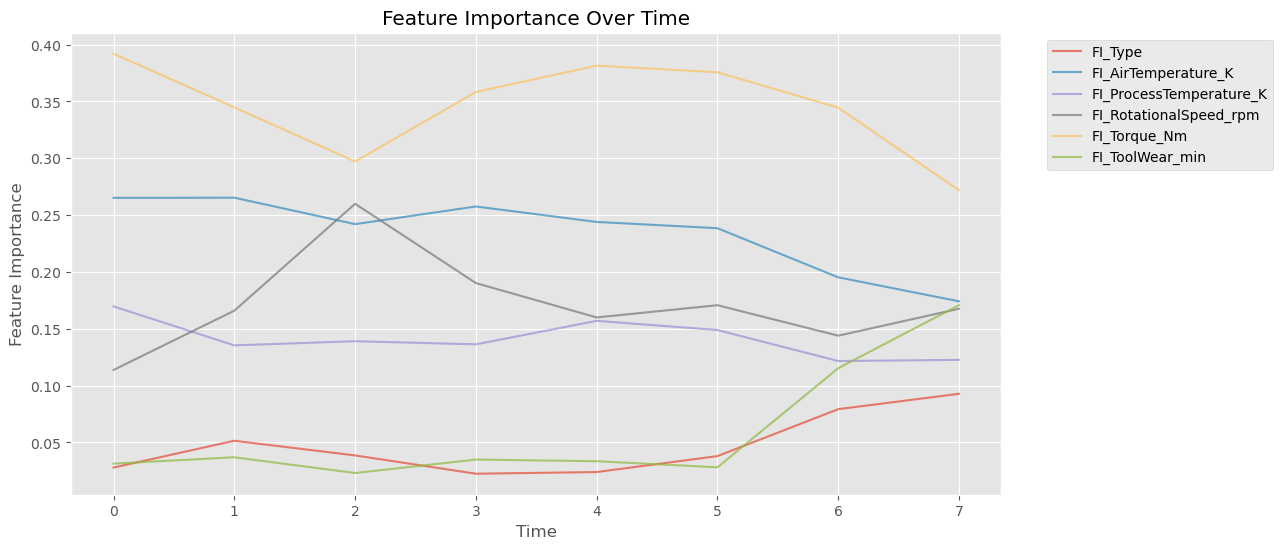

In [919]:
# Call the function to plot
plot_FI_over_time(FI_df_sim)

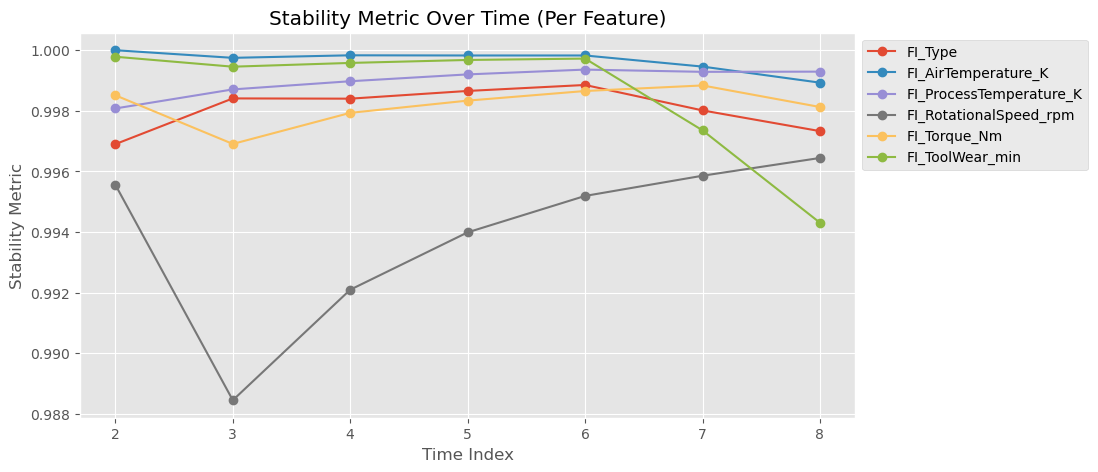

In [920]:
stability_values = {feature: [] for feature in FI_df_sim.columns}

for t in range(1, len(time_index)):
    FI_subset = FI_df_sim.iloc[:t+1, :]
    
    stability_result = compute_stability_metric(FI_subset, model_performance=model_performance_FI.iloc[:t+1], standardize=False)
    
    for feature, value in zip(FI_df_sim.columns, stability_result):
        stability_values[feature].append(value)

# Plot each feature separately
plt.figure(figsize=(10, 5))
for feature, values in stability_values.items():
    plt.plot(time_index_trimmed, values, marker='o', linestyle='-', label=feature)

plt.xlabel("Time Index")
plt.ylabel("Stability Metric")
plt.title("Stability Metric Over Time (Per Feature)")
plt.legend(bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

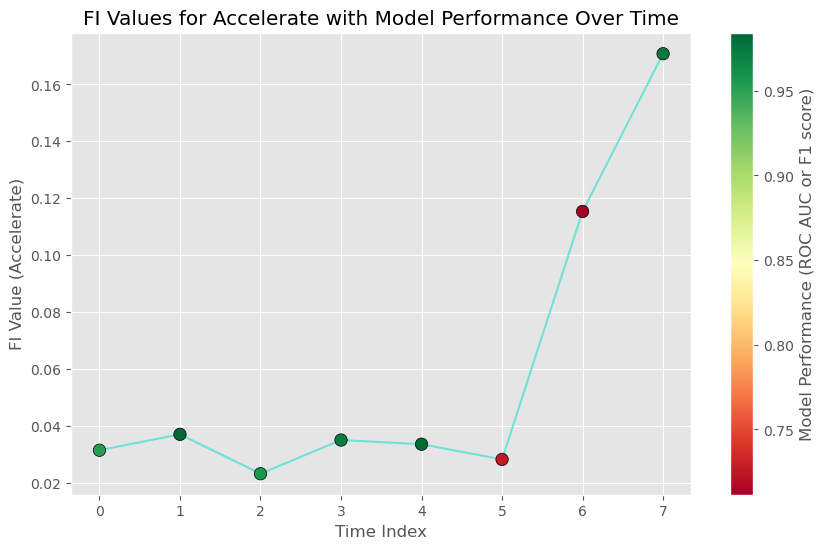

In [921]:
# Extract Feature Importance values for 'shap_jitter' and model performance 
FI_jitter = FI_df_sim['FI_ToolWear_min']
roc_auc_values = model_performance_FI

# Create a figure
fig, ax = plt.subplots(figsize=(10, 6))

# Create a colormap to color the markers by model performance values
scatter = ax.plot(range(len(FI_jitter)), FI_jitter, color='turquoise', marker='o', markersize=6, label='FI accelerate', alpha=0.7)

# Use a scatter plot with colormap to color the markers by model performance
sc = ax.scatter(range(len(roc_auc_values)), FI_jitter, c=roc_auc_values, cmap='RdYlGn', edgecolors='k', s=80, zorder=5)

# Set the labels
ax.set_xlabel('Time Index')
ax.set_ylabel('FI Value (Accelerate)')

# Add a colorbar for the model performance values
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Model Performance (ROC AUC or F1 score)')

# Add title
plt.title('FI Values for Accelerate with Model Performance Over Time')

# Show the plot
plt.grid(True)
plt.show()

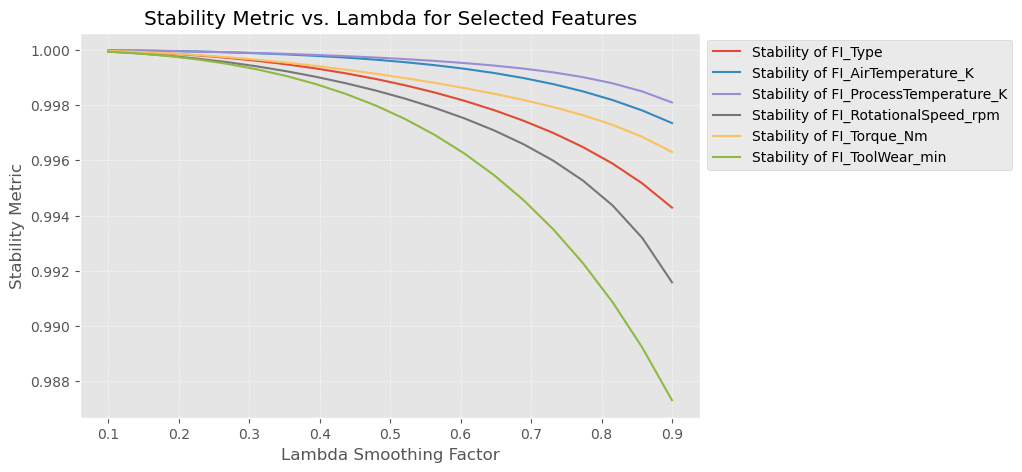

In [922]:
# Define the features to analyze
feature_names = FI_df_sim.columns

# Define lambda values to test (from 0.1 to 0.9)
lambda_values = np.linspace(0.1, 0.9, 20)

# Compute stability metric for each lambda value and each feature
stability_scores_FI = {feature: [] for feature in feature_names}

for l in lambda_values:
    stability_metric_FI = compute_stability_metric(FI_df_sim, model_performance_FI, lambda_smoothing=l)
    for feature in feature_names:
        stability_scores_FI[feature].append(stability_metric_FI[feature])

# Plot results
plt.figure(figsize=(8, 5))

for feature in feature_names:
    plt.plot(lambda_values, stability_scores_FI[feature], linestyle='-', label=f"Stability of {feature}")

# Customize plot appearance
plt.xlabel("Lambda Smoothing Factor")
plt.ylabel("Stability Metric")
plt.title("Stability Metric vs. Lambda for Selected Features")
plt.legend(bbox_to_anchor=(1, 1))
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
plt.show()